# <center><font color='red'>Telecom Project</font></center>

### Importing Necessary Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
pd.set_option('display.max_columns',100)

# For statistical analysis of the data
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.multicomp import pairwise_tukeyhsd 
import scipy.stats as stats

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,plot_roc_curve,f1_score,recall_score,precision_score, accuracy_score

# For GUI and SQLite
from tkinter import *
from tkinter import messagebox
from tkinter import ttk
import sqlite3, csv

import warnings
warnings.filterwarnings("ignore")

In [37]:
# Setting the parameters of matplotlib library for Visual Treat
plt.rcParams['axes.labelsize'] = 18.
plt.rcParams['xtick.labelsize'] = 14.
plt.rcParams['ytick.labelsize'] = 14.
plt.rcParams['figure.figsize'] = [12.,8.]
plt.rcParams['legend.fontsize'] = 12.

### Import and warehouse data

Instead of using MySQL, I am using SQLite3 python library which is an alternative to MySQL in python. 

In [38]:
# Creating SQL Database, creating tables in it, and entering data of both the csv files in their respective tables 

conn = sqlite3.connect("TelecomCustomer_project.db")
c = conn.cursor()
c.execute(""" CREATE TABLE TelecomCustomer_Churn_1 (
                customerID TEXT,
                gender TEXT,
                SeniorCitizen INTEGER,
                Partner TEXT,
                Dependents TEXT,
                tenure INTEGER,
                PhoneService TEXT,
                MultipleLines TEXT,
                InternetService TEXT,
                OnlineSecurity TEXT);
""")

with open('TelcomCustomer-Churn_1.csv','r') as ch1:
    dr1 = csv.DictReader(ch1)
    db1 = [(i['customerID'],
           i['gender'],
          i['SeniorCitizen'],
          i['Partner'],
          i['Dependents'],
          i['tenure'],
          i['PhoneService'],
          i['MultipleLines'],
          i['InternetService'],
          i['OnlineSecurity']) for i in dr1]
    
c.executemany("""INSERT INTO TelecomCustomer_Churn_1 (customerID,gender,SeniorCitizen,Partner,Dependents,tenure,
              PhoneService,MultipleLines,InternetService,OnlineSecurity) VALUES (?,?,?,?,?,?,?,?,?,?);""",db1)

c.execute(""" CREATE TABLE TelecomCustomer_Churn_2 (
                OnlineBackup TEXT,
                DeviceProtection TEXT,
                TechSupport TEXT,
                StreamingTV TEXT,
                StreamingMovies TEXT,
                Contract TEXT,
                PaperlessBilling TEXT,
                PaymentMethod TEXT,
                MonthlyCharges REAL,
                TotalCharges TEXT,
                Churn TEXT);

""")

with open('TelcomCustomer-Churn_2.csv','r') as ch2:
    dr2 = csv.DictReader(ch2)
    db2 = [(i['OnlineBackup'],
           i['DeviceProtection'],
          i['TechSupport'],
          i['StreamingTV'],
          i['StreamingMovies'],
          i['Contract'],
          i['PaperlessBilling'],
          i['PaymentMethod'],
          i['MonthlyCharges'],
          i['TotalCharges'],
            i['Churn']) for i in dr2]
    
c.executemany("""INSERT INTO TelecomCustomer_Churn_2 (OnlineBackup,DeviceProtection,TechSupport,StreamingTV,
                StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn) 
                VALUES (?,?,?,?,?,?,?,?,?,?,?);""",db2)
conn.commit()
conn.close()

In [39]:
# Reading the data of the tables in python dataframes

conn = sqlite3.connect("TelecomCustomer_project.db")
c = conn.cursor()

df1 = pd.read_sql_query("SELECT * FROM TelecomCustomer_Churn_1",conn)
df2 = pd.read_sql_query("SELECT * FROM TelecomCustomer_Churn_2",conn)

conn.close()

In [40]:
df1.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  
0  No phone service             DSL             No  
1                No             DSL            Yes  
2                No             DSL            Yes  
3  No phone service             DSL            Yes  
4                No     Fiber optic             No

In [41]:
df1.shape

(7043, 10)

In [42]:
df1.size

70430

In [43]:
df2.shape

(7043, 11)

In [44]:
df2.size

77473

In [45]:
df = pd.concat([df1,df2],axis=1)

In [46]:
df.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   
5               Yes     Fiber optic             No           No   
6               Yes     Fiber optic             No          Yes   
7  No phone service             DSL            Yes           No   
8               Yes     Fiber optic             No           No   
9                No             DSL            Yes          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   
5              Yes          No         Yes             Yes  Month-to-month   
6               No          No         Yes              No  Month-to-month   
7               No          No          No              No  Month-to-month   
8              Yes         Yes         Yes             Yes  Month-to-month   
9               No          No          No              No        One year   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   
5              Yes           Electronic check           99.65        820.5   
6              Yes    Credit card (automatic)           89.10       1949.4   
7               No               Mailed check           29.75        301.9   
8              Yes           Electronic check          104.80      3046.05   
9               No  Bank transfer (automatic)           56.15      3487.95   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes  
5   Yes  
6    No  
7    No  
8   Yes  
9    No

In [47]:
df.shape

(7043, 21)

In [48]:
df.size

147903

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Data cleansing:

Fow now, let's just do the temporary imputation of missing values and correct the data types of the features for the statistical analysis. We will automate the entire process through a function later and do our final imputation and one-hot encoding for all our categorical variables. 

In [50]:
churn = df.copy(deep=True) # Copied our dataframe

In [51]:
churn.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [52]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Looks like the feature <b>SeniorCitizen</b> is already label encoded. For the analysis purpose, we will bring it back to its original form of categorical variable. <br>
Secondly, it looks like the feature <b>TotalCharges</b>, which is supposed to be continuous is somehow showing to be of 'object' data type. That means it contains some values which aren't float values. 

Let's first check the null values in our dataframe.

In [53]:
churn.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

There doesn't seem to be any null values. That means in <b>TotalCharges</b>, there could be some characters or empty spaces instead of nan values. I have checked it and it's blank spaces at some places.

In [54]:
# Let's check at how many places these black spaces are there in the feature.
n = [x for x,y in enumerate(churn['TotalCharges']) if y == ' ']
len(n)

11

In [55]:
churn.loc[n,'tenure']

488     0
753     0
936     0
1082    0
1340    0
3331    0
3826    0
4380    0
5218    0
6670    0
6754    0
Name: tenure, dtype: int64

On further analysis, I found that values for <b>TotalCharges</b> are missing for all the rows where <b>tenure</b> is zero, i.e., newly joined people with the telecom company. It makes sense that total charges can only be detected at the end of the month. So, we can take total charges equal to the monthly charges for the newly joined people for the time being. 

In [56]:
# For imputation, first comvert TotalCharges to float and then impute the values
churn.loc[n,'TotalCharges'] = np.nan
churn['TotalCharges'] = churn['TotalCharges'].astype(float)
churn.loc[n,'TotalCharges'] = churn.loc[n,'MonthlyCharges']

Just for the analysis, let's revert the encoded Senior Citizen feature back to its original form. We will encode it later again. Analysis would be easy for us in this form. 

In [57]:
churn['SeniorCitizen'] = churn['SeniorCitizen'].replace({0:'No',1:'Yes'})

In [58]:
churn['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

Options in <b>PaymentMethod</b> feature are quite long and would overlap with eachother when we plot them. So, better abbreviate them for analysis. 

In [59]:
churn['PaymentMethod'] = churn['PaymentMethod'].replace({'Electronic check':'EC',
                                                         'Mailed check':'MC',
                                                         'Bank transfer (automatic)':'BT',
                                                         'Credit card (automatic)':'CC'})

Let's check the data-types of all the features before starting our statistical analysis.

In [60]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Now it seems that we have corrected all our data-types and there are no null values as well in the dataset. We are good to go for statistical analysis.

### Data analysis & visualisation:

Let's start our statistical analysis on our continuous and categorical variables.

In [61]:
churn.describe()

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.798992
std      24.559481       30.090047   2266.730170
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000

In <b>tenure and MonthlyCharges</b>, although there doesn't seem much skewness as mean and median are close by. But standard deviation is quite high for both the features, i.e., there is a lot of variability in both the features.

In <b>TotalCharges</b>, there seems a lot of skewness. Plus, it also has a very high standard deviation, i.e., it is varying greatly, which is not a good sign for our model. 

Later we will have to bucket these contiuous variables to contain there high variability. 

Now, let's analyse categorical variables, except our target variable because we will analyse it separately.

In [62]:
churn.drop(['customerID','Churn'],axis=1).describe(include='object').T

count unique             top  freq
gender            7043      2            Male  3555
SeniorCitizen     7043      2              No  5901
Partner           7043      2              No  3641
Dependents        7043      2              No  4933
PhoneService      7043      2             Yes  6361
MultipleLines     7043      3              No  3390
InternetService   7043      3     Fiber optic  3096
OnlineSecurity    7043      3              No  3498
OnlineBackup      7043      3              No  3088
DeviceProtection  7043      3              No  3095
TechSupport       7043      3              No  3473
StreamingTV       7043      3              No  2810
StreamingMovies   7043      3              No  2785
Contract          7043      3  Month-to-month  3875
PaperlessBilling  7043      2             Yes  4171
PaymentMethod     7043      4              EC  2365

<b>gender</b> seems quite balanced with proportion of both male and female almost similar.<br>
<b>SeniorCitizen</b> is certainly imbalanced. There is much less senior citizens,i.e., around one seventh of all the people are senior citizens, which is around 14%. <br>
<b>Partner</b> also seems balanced. Means there are as many married people as there are either unmarried or divorced or widowed. <br>
<b>Dependents</b> seems a bit imbalanced in favour of 'No', i.e., there are less customers of the company who have dependents, either parents or kids. Either they are unmarried or falls in the above age bracket.<br>
<b>PhoneService</b> also seems quite imbalanced in favour of 'Yes', which is a good news for the company, i.e., most of the customers use company's phone service.<br>
<b>PaperlessBilling</b> doesn't seem that imbalanced but there are more people going for Paperless Billing which is a good thing for both the company and the environment. 

Where there are more than 2 categories inside a categorical variable, we need to further inspect them. Can't conclude anything simply by above table. So, We will analyse rest of the variables in our further analysis.

### Univariate Analysis:

Let's start with continous variables:

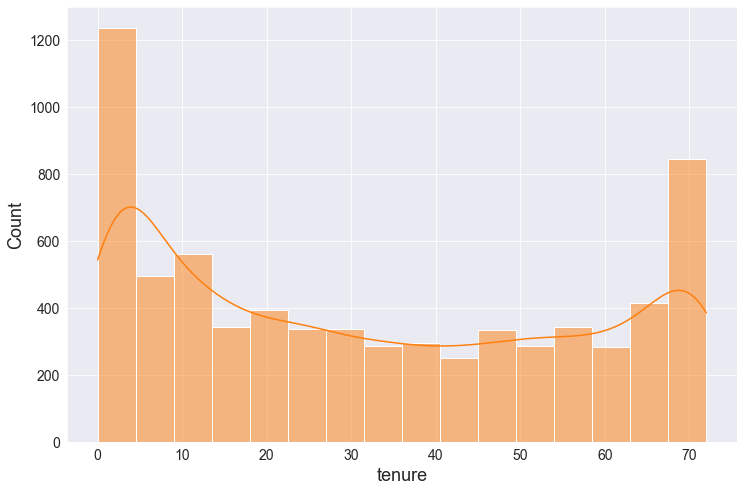

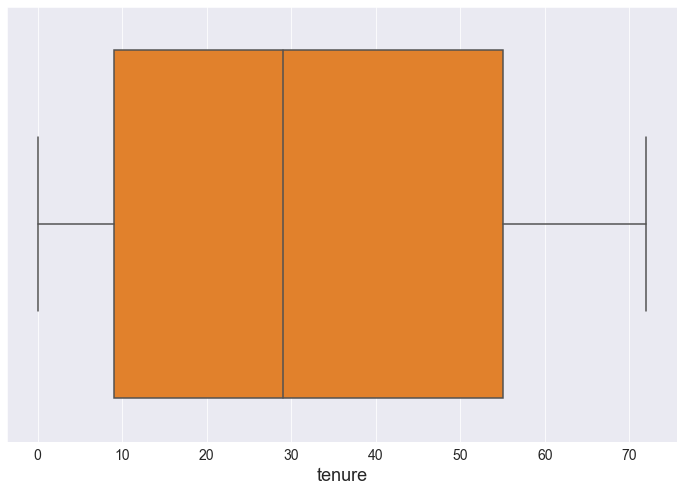

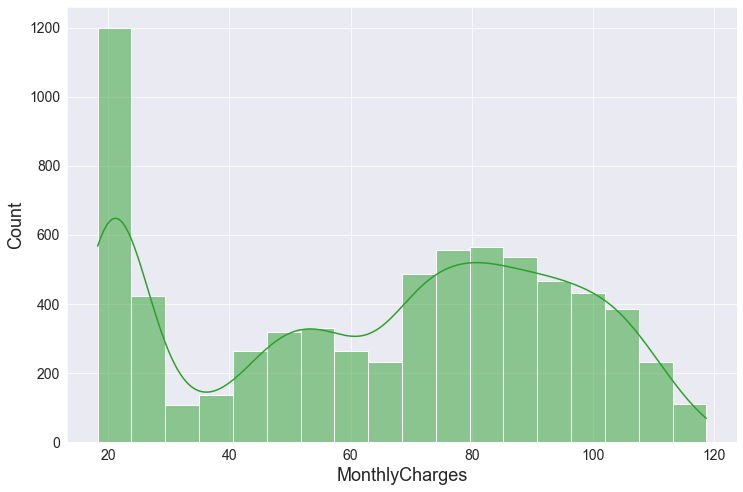

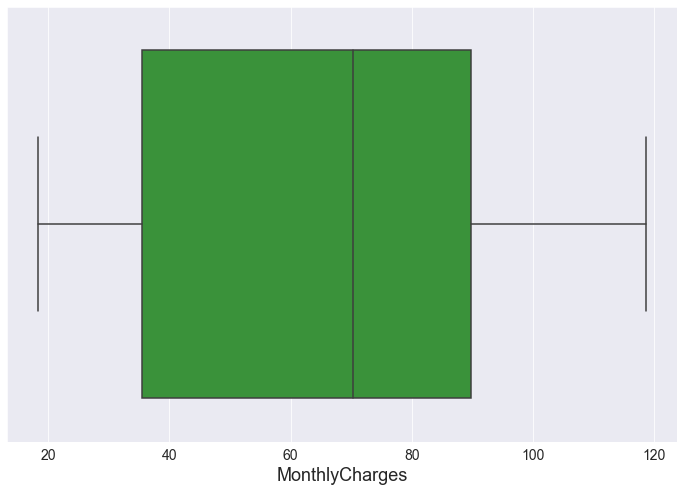

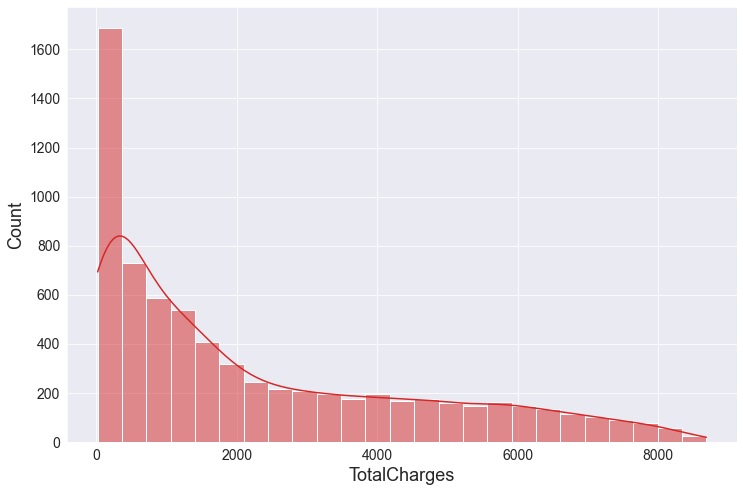

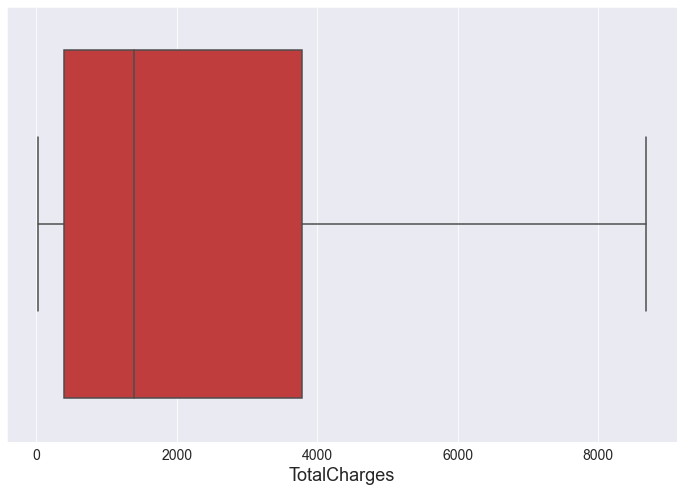

In [63]:
cols = churn.select_dtypes(exclude='object').columns

for i,j in enumerate(cols):
    sns.histplot(data=churn,x=j,kde=True,color=sns.color_palette()[i+1])
    plt.show()
    sns.boxplot(data=churn,x=j,color=sns.color_palette()[i+1])
    plt.show()

In <b>tenure</b> feature, it seems to be mostly normally distributed with starting and end being an exception. 

In <b>MonthlyCharges</b> feature, it seems to be distributed in two zones. One is lower charged people and one is on the higher side. 

In <b>TotalCharges</b> feature, it seems right skewed. Plus, there seems quite a lot of variation as seen in our statistical analysis earlier.

Let's check the skewness in our continuous variables.

In [64]:
churn[['tenure','MonthlyCharges','TotalCharges']].skew()

tenure            0.239540
MonthlyCharges   -0.220524
TotalCharges      0.963316
dtype: float64

It is in line with the observations that we made above. Tenure and MonthlyCharges aren't that skewed but TotalCharges is highly skewed. But all of them have high variability, which is a cause of concern. We will try to reduce their variability by binning them before building any model.

Now, let's do univariate analysis of our categorical variables except our target variable.

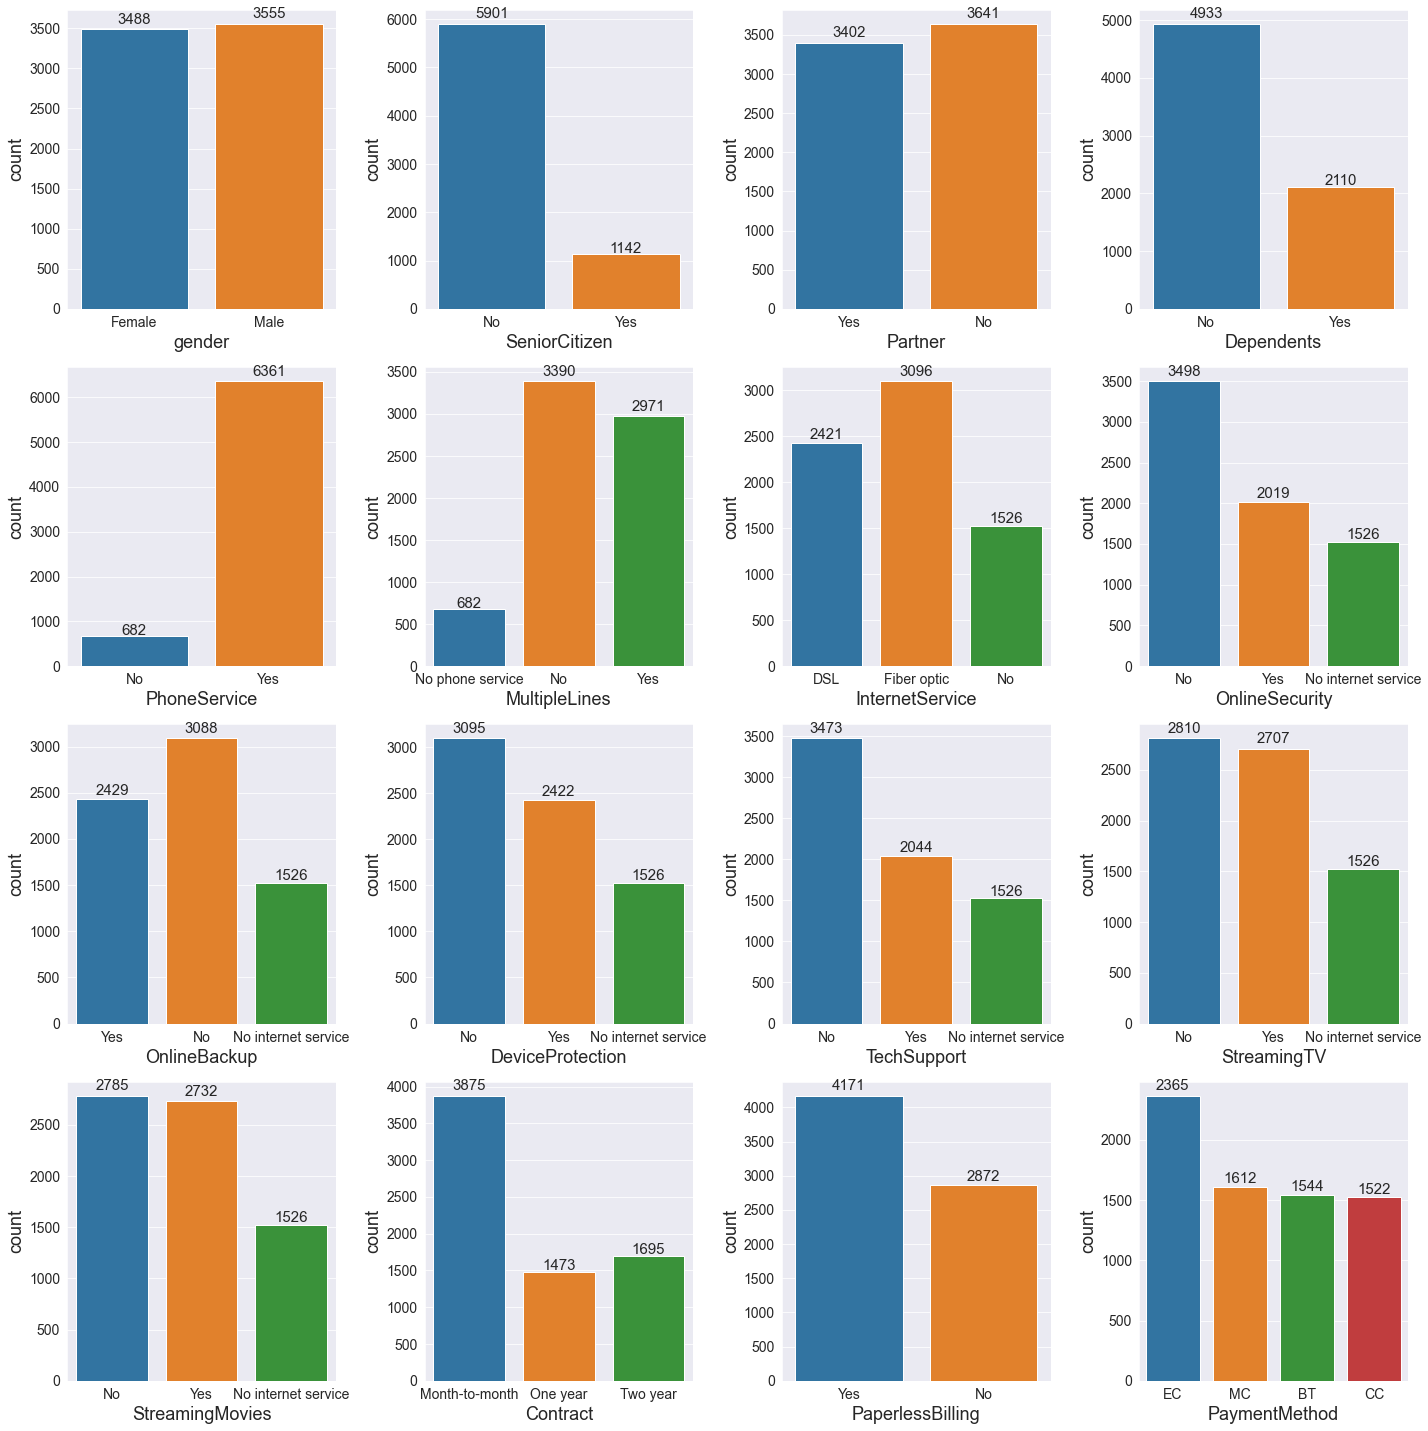

In [65]:
obj_cols = churn.drop(['customerID','Churn'],axis=1).select_dtypes(include='object').columns
m=0
fig , ax = plt.subplots(nrows= 4, ncols = 4, figsize=[20,20])
for i in range(0,4):
    for j in range(0,4):
        bar = sns.countplot(data=churn,x=obj_cols[m],ax=ax[i][j])
        for k in bar.patches: #label each rectangle
            height = k.get_height()
            ax[i][j].text(k.get_x()+k.get_width()/2,height*1.02,height,ha="center",fontsize=15)
        m +=1
plt.tight_layout()
plt.show()

As we can see that the analysis of variables with only 2 categories <b>(gender, SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling)</b> are in line with the analysis that we did earlier during our statistical analysis. 

Let's do analysis of rest of the categorical variables that we haven't done till now.

In <b>MultipleLines</b>, out of the people who have PhoneService, there are less people who have multiple lines. Most of the people have single phone line. <br>
In <b>InternetService</b>, most of the people have internet service activated. Some have DSL internet service but there are more people who have chosen Fibre Optic internet service.<br>
In <b>OnlineSecurity</b>, out of the people who have internet service, not many people have opted for online security. There could be many factors. Either people aren't aware or careful of their online risk and hence, don't care about online security. With time, awareness is going to increase, but it is recommended to the company to increase the awareness among their customers which would benefit both the customers and the company.<br>
In <b>OnlineBackup</b> as well, out of the people who have internet service, not many people are interested in opting for online backup. Either they don't have that much data to backup online or company's pricing is the issue since there are a lot of cheap online backup facilities in the market. Company should also look into this.<br>
In <b>DeviceProtection</b> as well, the trend continues. Either people are not aware of the service or it is too costly. Either ways, company should certain run awareness campaigns for their customers, as well as look at the pricing and make them competitive.<br>
In <b>TechSupport</b> as well, not many people who have internet service are interested. Either they are themselves tech savvy and capable of handling technology or reviews of your techsupport must not have been good to convince the customers to opt for it.<br>
This trend is slightly defied in <b>StreamingTV and StreamingMovies</b> features. People are actually opting for it, which means company should focus on that and bring more attractive plans to lure more customers towards it since these are the trending things in the world.<br> 
In <b>contract</b>, it seems most people are interested in the short term plans of monthly billing than of the long term plans like of one year or two years. I think this area also company could focus in and bring in more attractive plans to lure customers towards longer term plans.<br> 
In <b>PaymentMethod</b>, it seems the most preferred way to pay the bills is via Electronic Checks. To be honest, it doesn't matter how a customer pays his/her bill as long as (s)he pays. 

<b>Let's do our analysis of our target variable and see whether it is imbalanced or not.

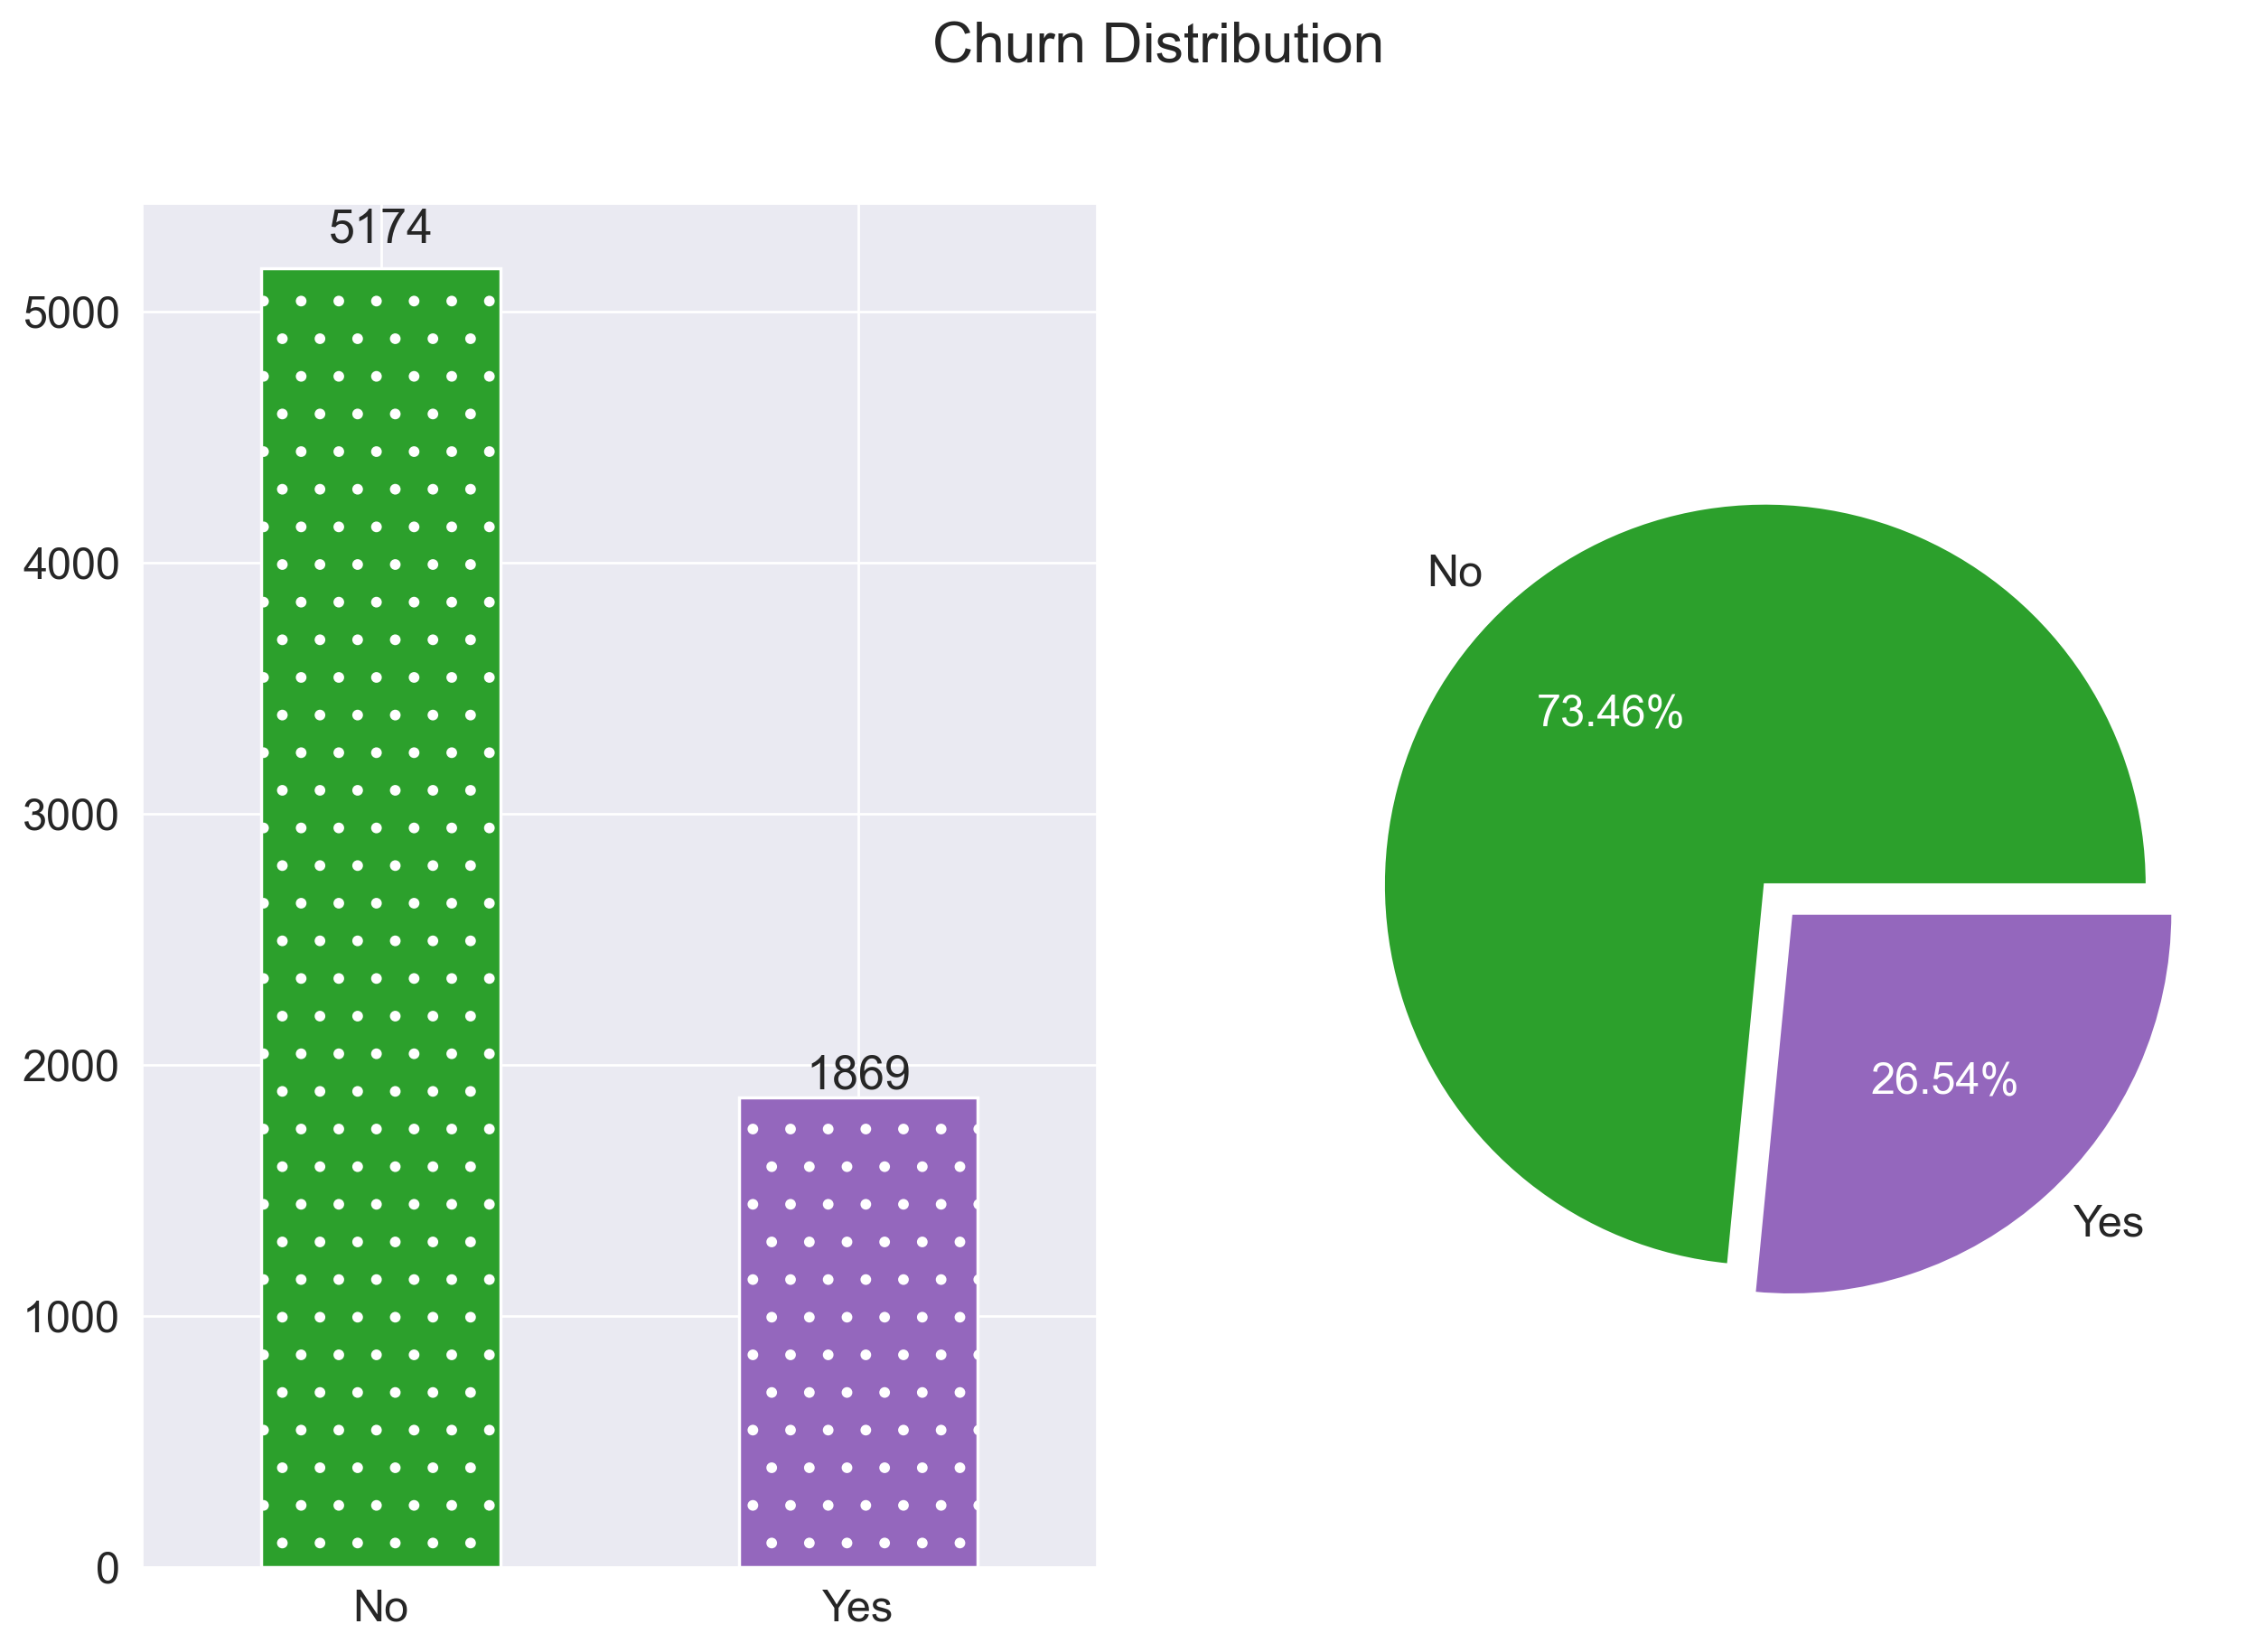

In [66]:
fig , ax = plt.subplots(1,2,dpi=250)

fig.suptitle('Churn Distribution',fontsize=18.)

bar = churn['Churn'].value_counts().plot.bar(ax=ax[0],
rot=0,color=[sns.color_palette()[2],sns.color_palette()[4]],hatch='.')
for i in bar.patches: 
    height = i.get_height()
    ax[0].text(i.get_x()+i.get_width()/2,height*1.02,height,ha="center",fontsize=15)

p = churn['Churn'].value_counts().plot.pie(ax=ax[1],autopct="%.2f%%",fontsize=14.,
colors=[sns.color_palette()[2],sns.color_palette()[4]],explode=(0,0.1)),
ax[1].texts[1].set_color('white'),ax[1].texts[3].set_color('white')
ax[1].set_ylabel("")
plt.show()

Our target variable is certainly imbalanced and seems it need some kind of treatment of over or under sampling while doing our model building.

<b>Bivariate Analysis:</b><br>
Let's start with numerical columns
    

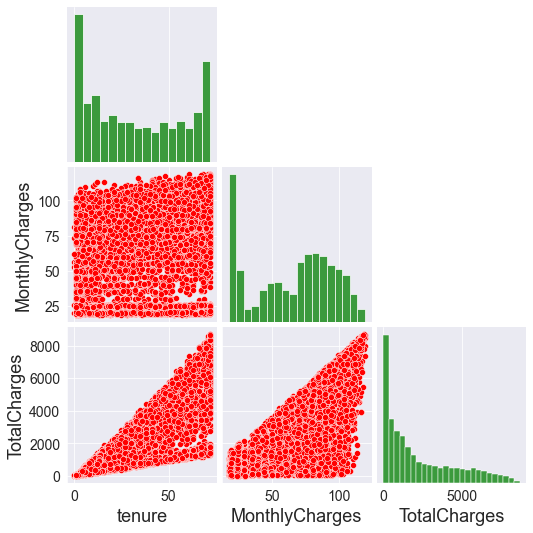

In [67]:
sns.pairplot(data=churn,corner=True,plot_kws={'color':'red'},diag_kws={'color':'green'})

Tenure and MonthlyCharges doesn't seem to be related but TotalCharges seems to be related with both tenure and MonthlyCharges. 
It seems there are some fixed monthly charges which doesn't change with tenure. But TotalCharges seems to get affected by both tenure and MonthlyCharges.

Now, let's do bivariate analysis of continuous and categorical variables.

In [68]:
# Re-setting the legend parameter of matplotlib for the sub-plots.
plt.rcParams['legend.fontsize'] = 10.

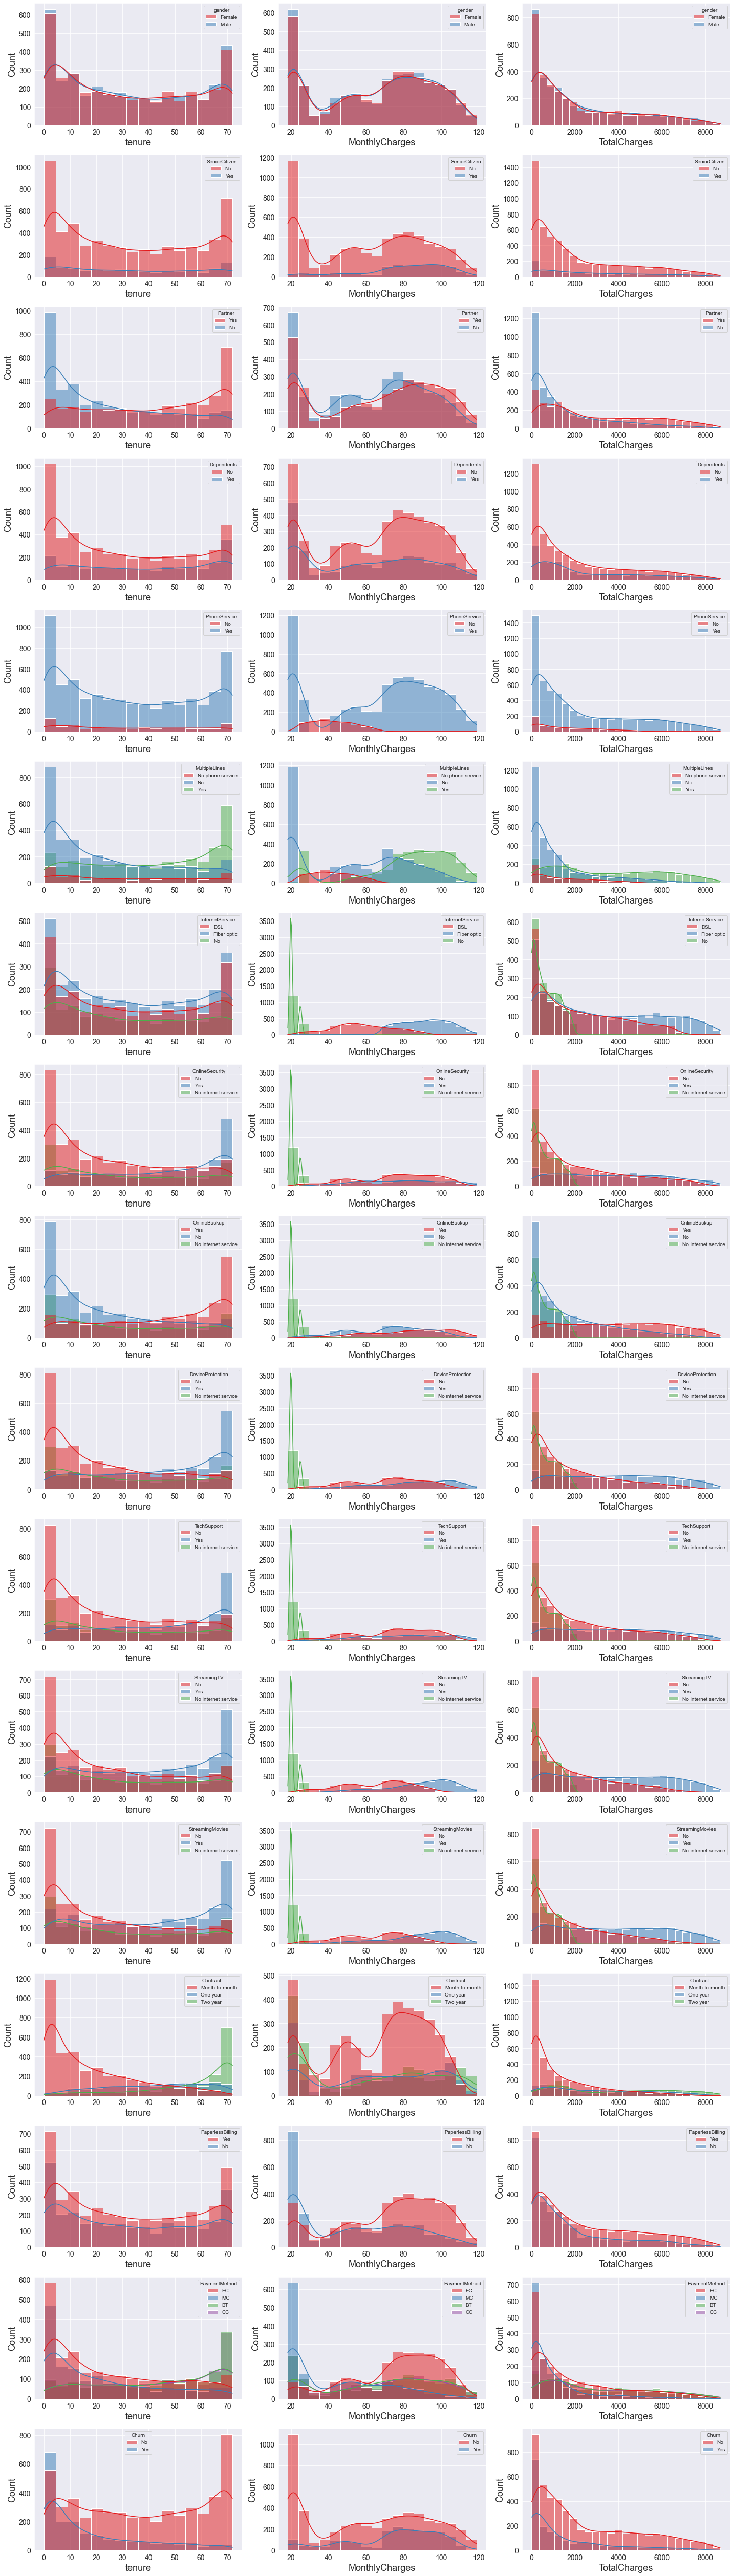

In [69]:
obj_cols = churn.drop(['customerID'],axis=1).select_dtypes(include='object').columns
num_cols = churn.select_dtypes(exclude='object').columns

fig, ax = plt.subplots(nrows=len(obj_cols),ncols=len(num_cols),figsize=[20.,70.])

for i,obj in enumerate(obj_cols):
    for j,num in enumerate(num_cols):
        p = sns.histplot(data=churn,x=num,hue=obj,kde=True,ax=ax[i][j],palette='Set1')
        
plt.tight_layout()
plt.show()

<b>gender</b> doesn't seem to have affect any numerical variable. Both Males and Females are using the services equally.<br>
<b>SeniorCitizen</b> also doesn't seem to affect significantly. There are less number of senior citizens but they are equally distributed across all the continuous variables.<br>
<b>Partner</b> certainly seems to show some variation in the sense customers with no partners seems to opt for lesser tenure and also have lesser Monthly and Total Charges. Which means the company should focus on customers with partners since they seem to be more reliant.<br>
<b>Dependents</b> doesn't show considerable variation. The ones with dependents and the ones with no dependents are spread uniformly across all the continuous variables.<br>
<b>PhoneService</b> certainly seems to have impact specially on the MonthlyCharges and to some extent even on TotalCharges. People having phone service seems to have higher monthly charges than the ones who don't have it.<br>
<b>MultipleLines</b> certainly have impact on all the continuous variables. People with Multiple Lines certainly opt for longer tenure, have higher monthly charges as well as total charges. People with no phone service don't have high total charge.<br>
<b>InternetService</b> certainly have impact on continuous variables. People with internet service seems to have higher monthly and total charges. People having Fiber Optics internet service seems to have higher spendings followed by DSL.<br>
<b> All the services based on Internet service seems to have similar trend on continuous variables as seen in Internet Service from OnlineSecurity till StreamingMovies, people opting for the service have higher spendings than those with either no internet service or not opting for the service.</b><br>
<b>contract</b> obviously has a hugh impact on all the continuous variables. People with contract of one or two years have slightly more spendings than short term contract customers.<br>
<b>PaperlessBilling</b> doesn't have any significant impact on continuous variables.<br>
<b>PaymentMethod</b> also largely doesn't seem to have a significant impact other than the trend that people with high tenure seems to pay via Bank Transfer and people using Mailed Check seems to have a lower monthly and total charges.<br>

<b>Our target Variable 'Churn' seems to have significant effect on mainly tenure and TotalCharges. People who churn usually have lower tenure and lower total charges. It is a good sign that high paying customers are being retained by the company. 



<b>Now, let's do the Bivariate analysis of just categorical variables.</b> Since there are a lot of categorical variables and it would not be possible for me to explain each and every graph. I will only focus on the ones showing some significant variation. 
But I would explain in detail the impact of our target variable on our categorical features.

In [70]:
def plot_cat(churn,feature):
    obj_cols = churn.drop(['customerID',feature],axis=1).select_dtypes(include='object').columns
    m=0
    fig , ax = plt.subplots(nrows= 4, ncols = 4, figsize=[20,20])
    for i in range(0,4):
        for j in range(0,4):
            bar = sns.countplot(data=churn,x=obj_cols[m],hue=feature,ax=ax[i][j])
#             for k in bar.patches: #label each rectangle
#                     height = k.get_height()
#                     ax[i][j].text(k.get_x()+k.get_width()/2,height*1.02,height,ha="center",fontsize=15)
            m +=1
    plt.tight_layout()
    plt.show()

In [71]:
cols = churn.drop(['customerID'],axis=1).select_dtypes(include='object').columns

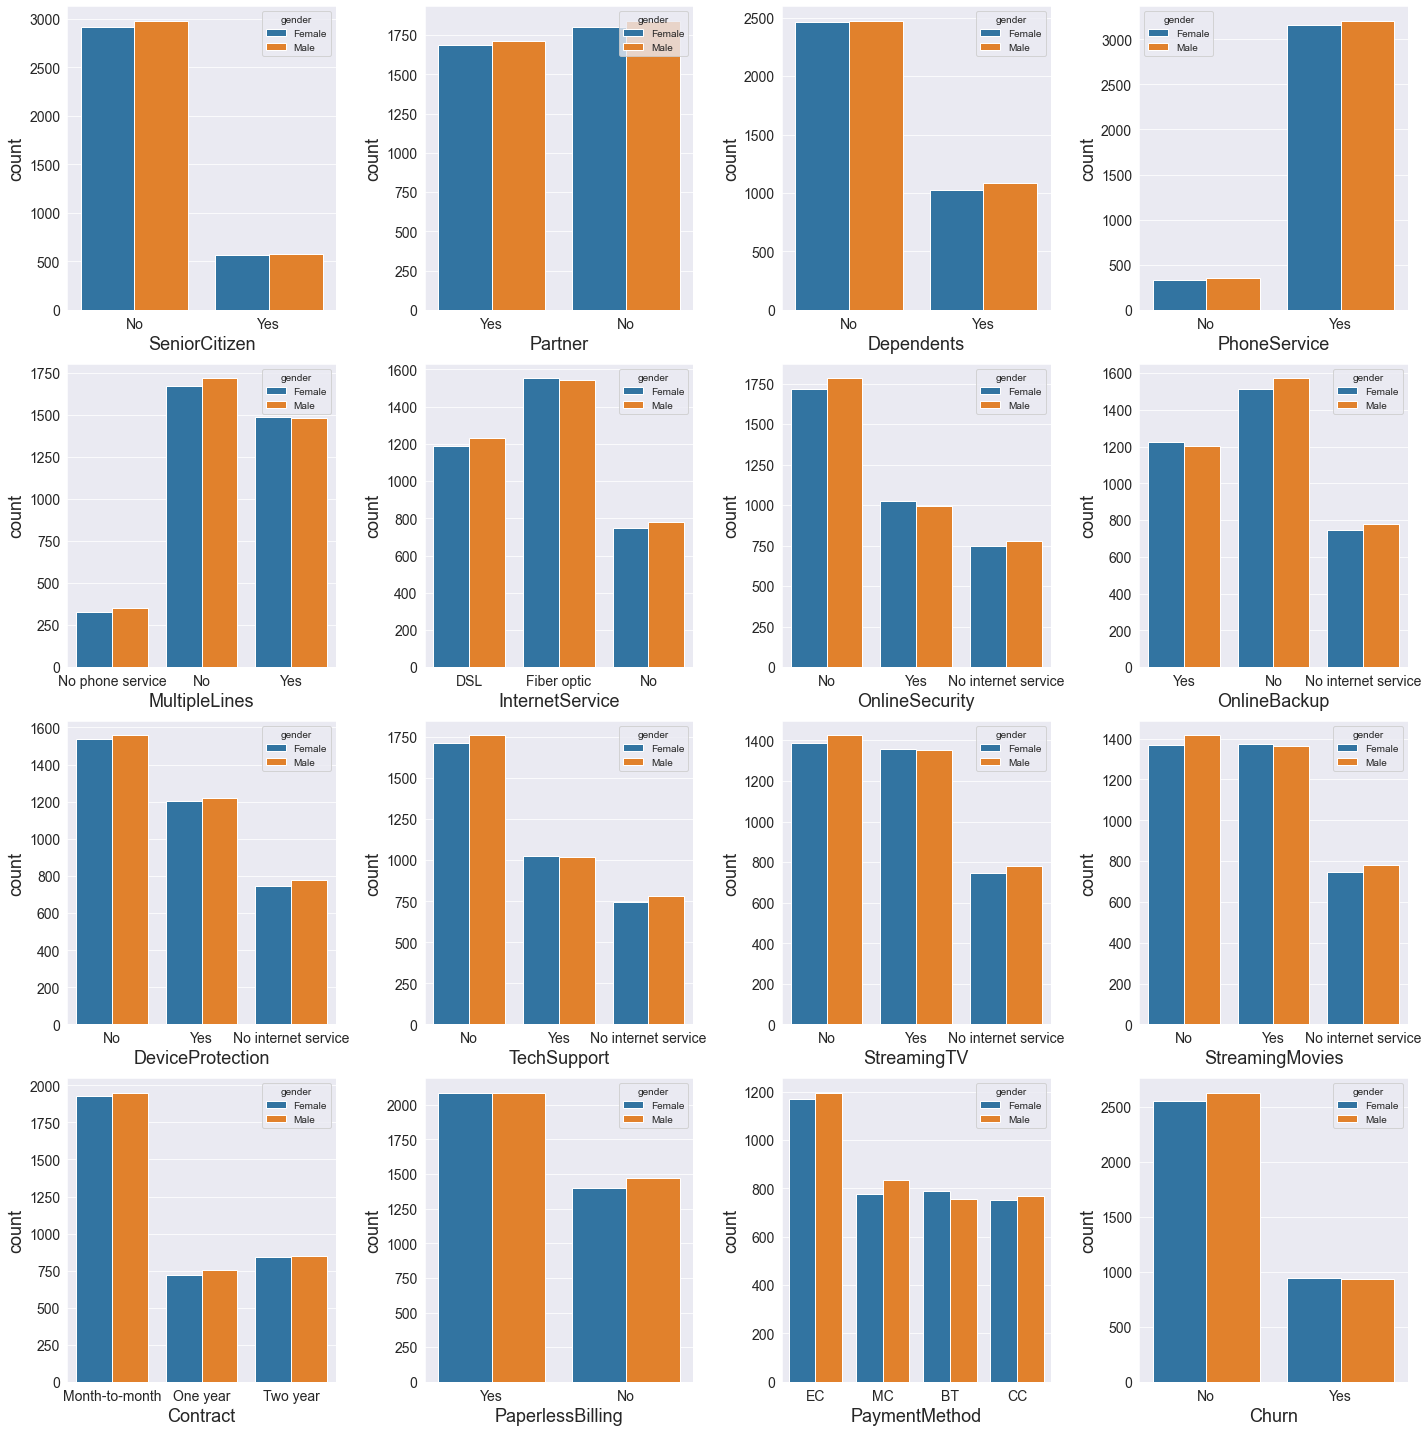

In [72]:
plot_cat(churn,cols[0])

<b>Gender doesn't seem to have impact on any categorical value. 

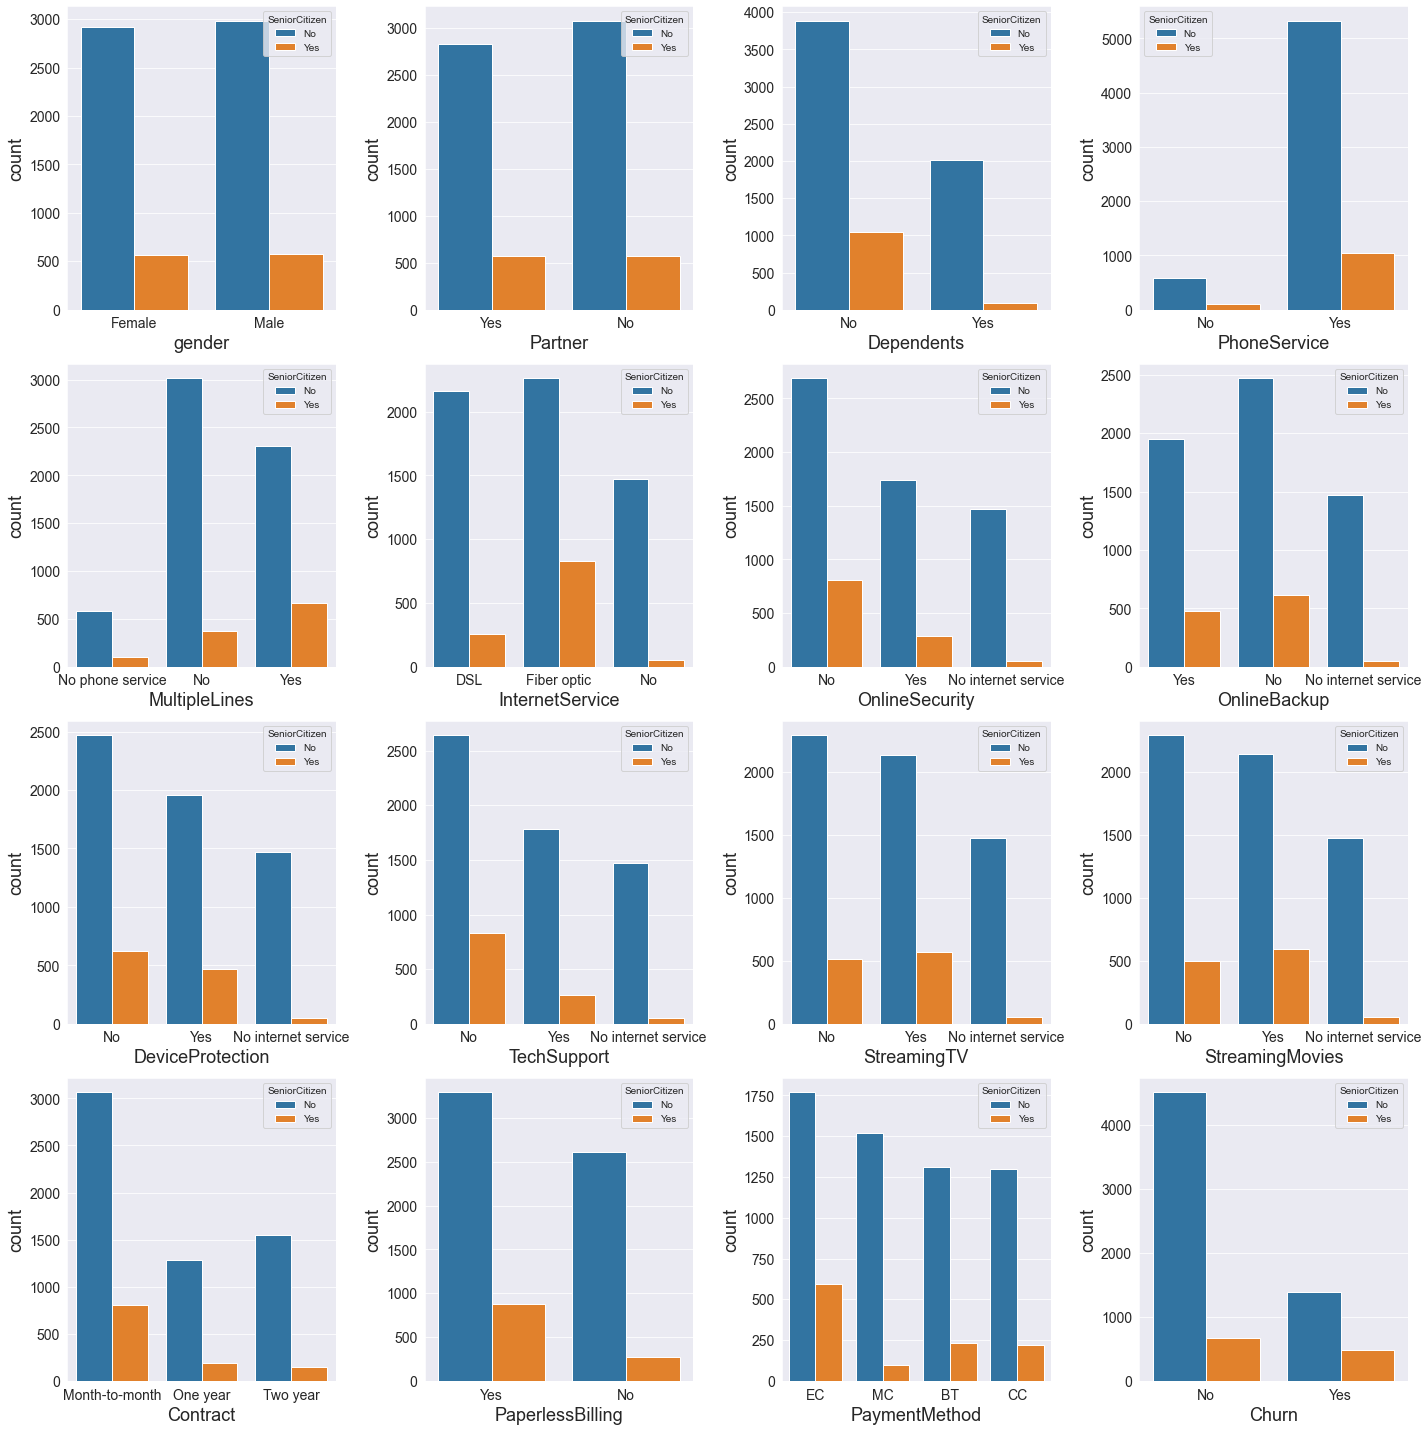

In [73]:
plot_cat(churn,cols[1])

<b>Senior Citizens seems to opt for multiple lines and in internet services, they seem to prefer Fiber Optics. They prefer Electonic checks more than any other. And on the churning side, they seem be on the higher side of churning. 

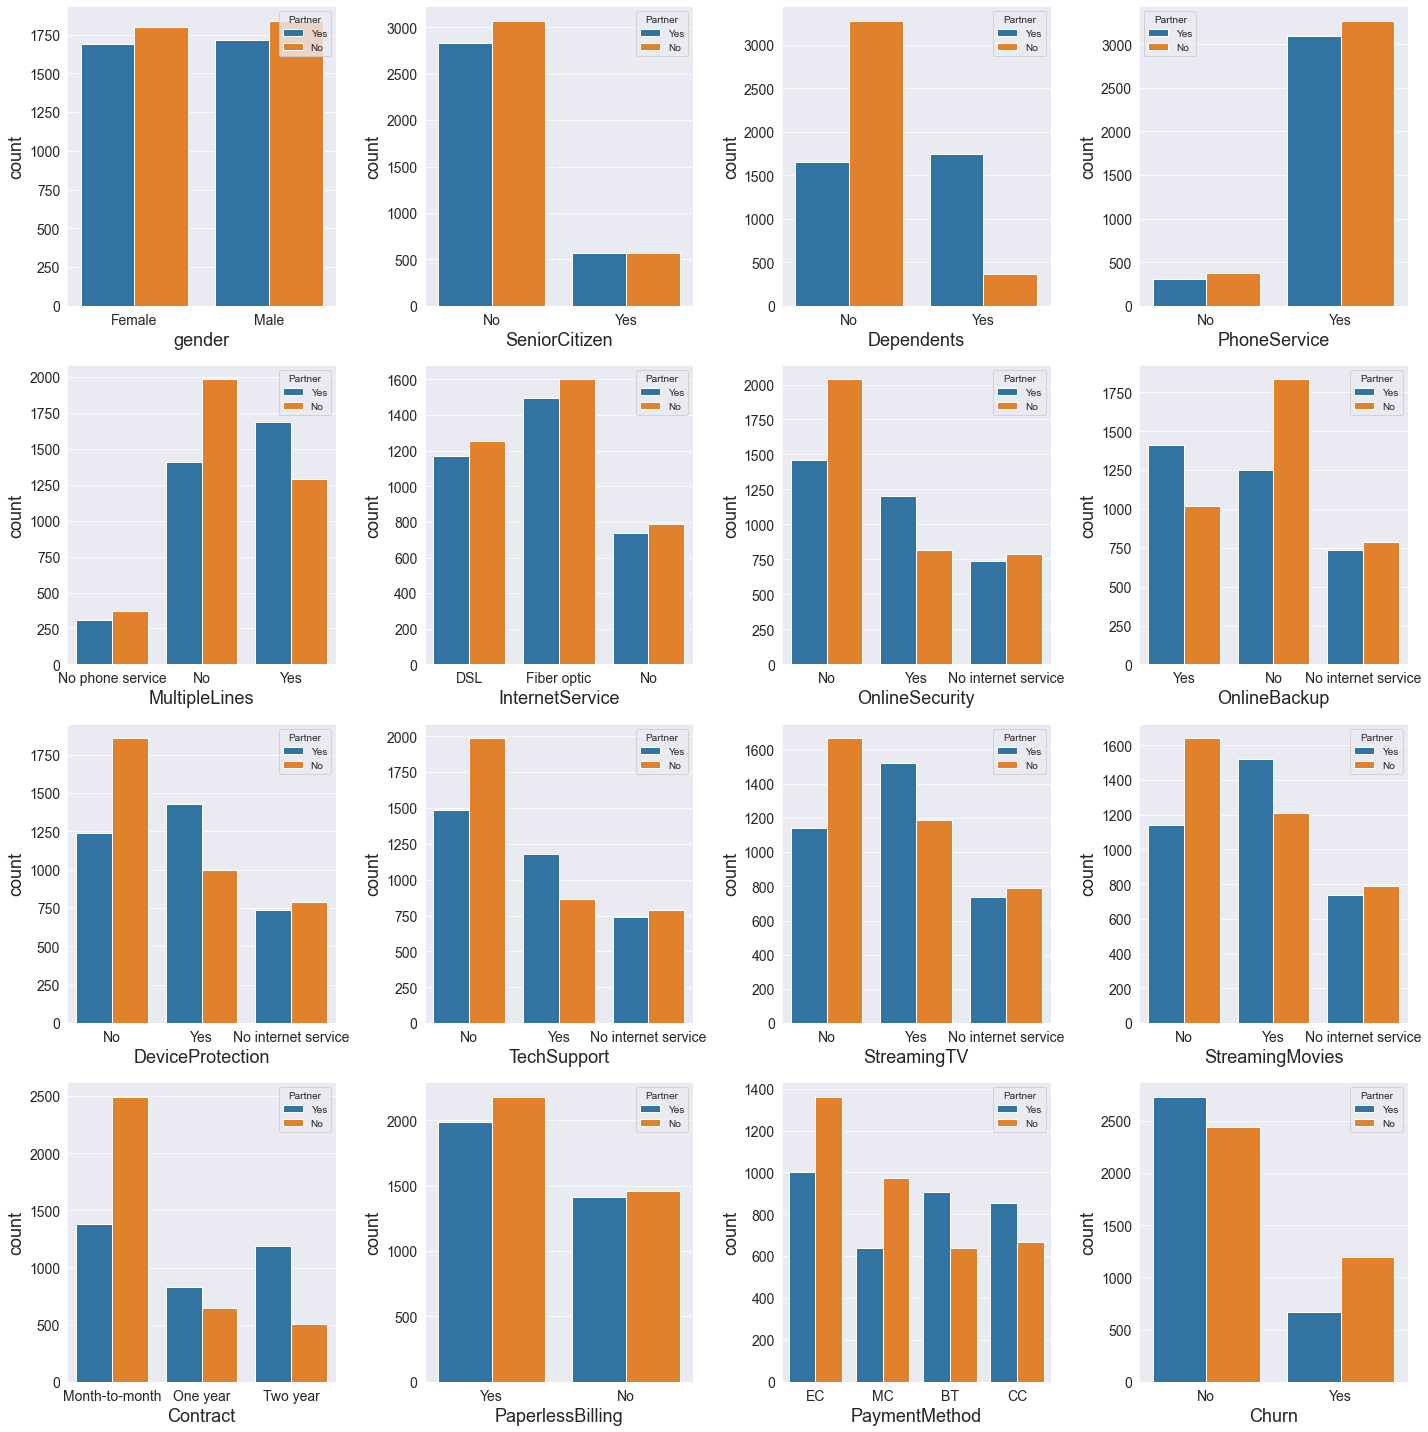

In [74]:
plot_cat(churn,cols[2])

<b>People with partners seems to have more dependents. That makes sense also. They also prefer Multiple lines a bit. People with partners who opt for internet services also opt for other services related to internet as well. They seem to have higher proportion of choosing long tern contracts. They seem to prefer Bank Transfers and Credit Card payments over other means.

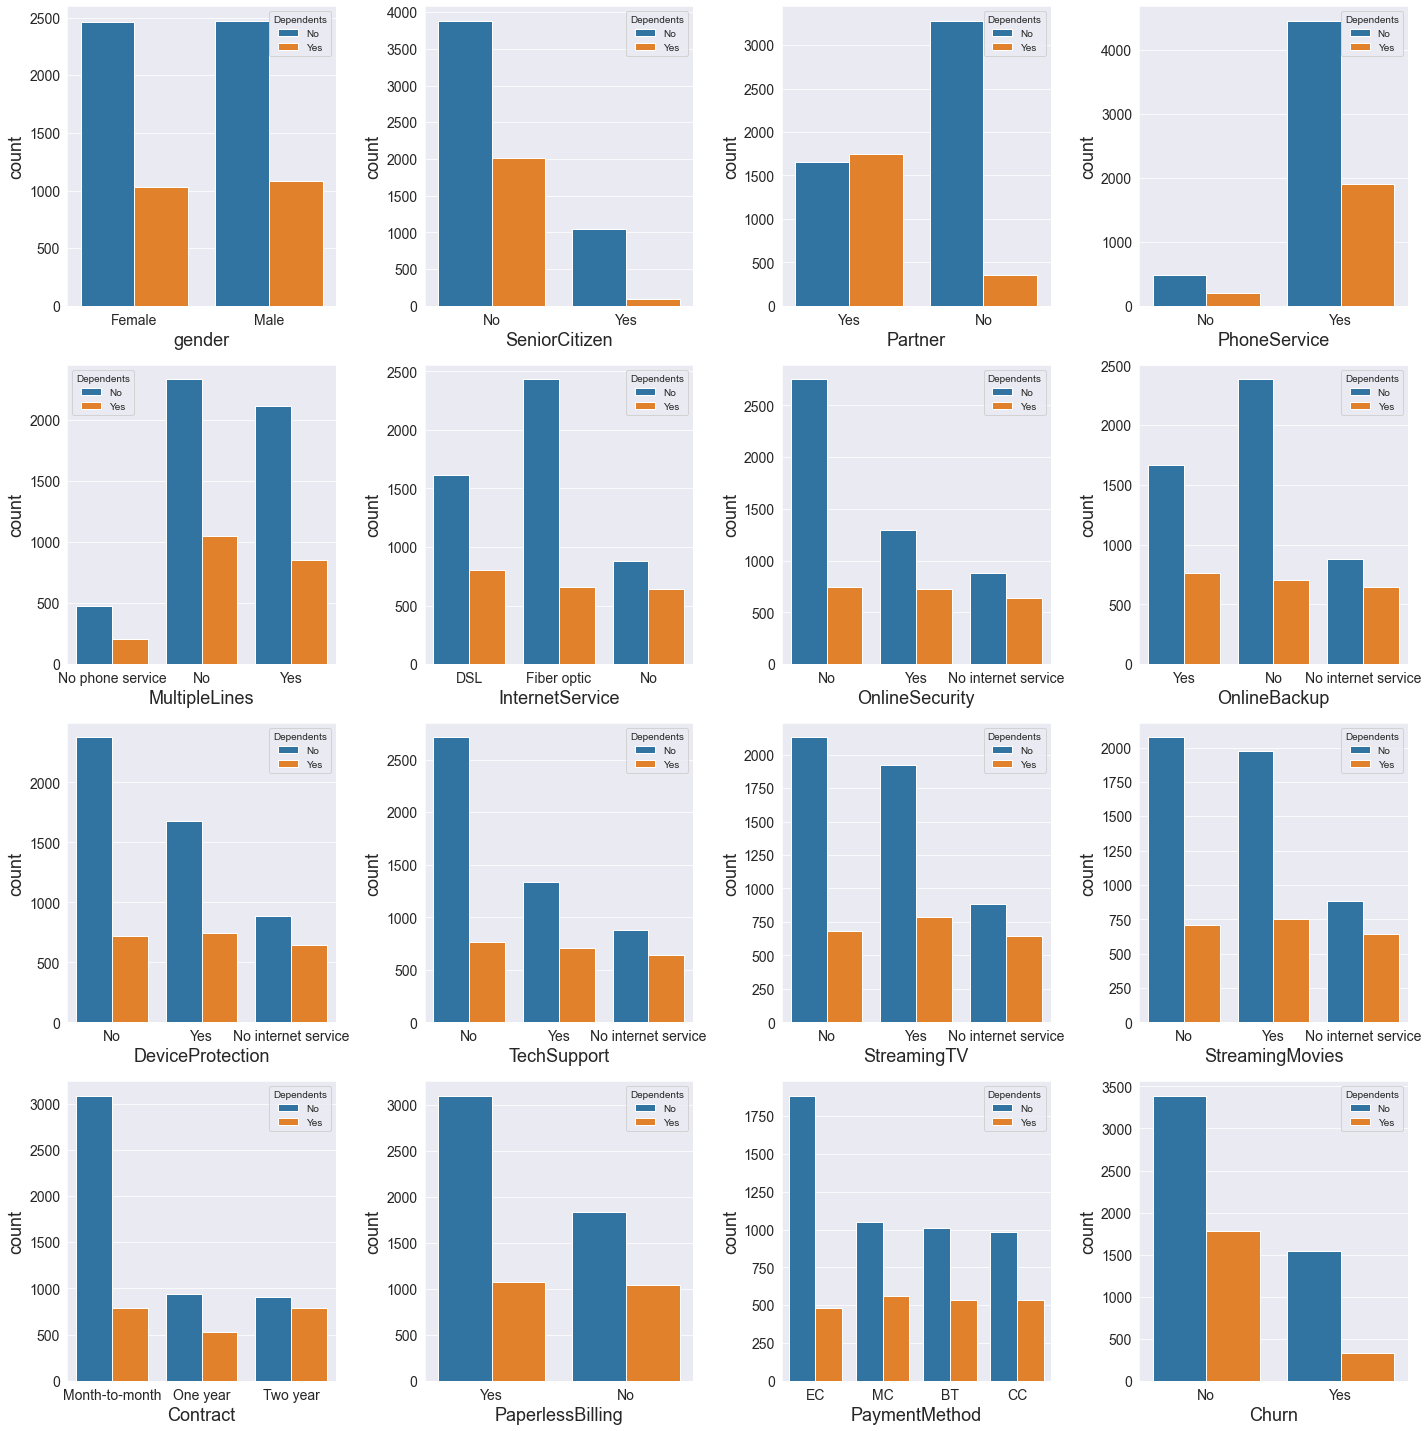

In [75]:
plot_cat(churn,cols[3])

<b>It seems senior citizens don't have much dependents. Plus, customers who have no partners have very less dependents. That makes sense. People with dependents seem to prefer DSL internet Service and also higher contract term. People with dependents don't seem to churn much. 

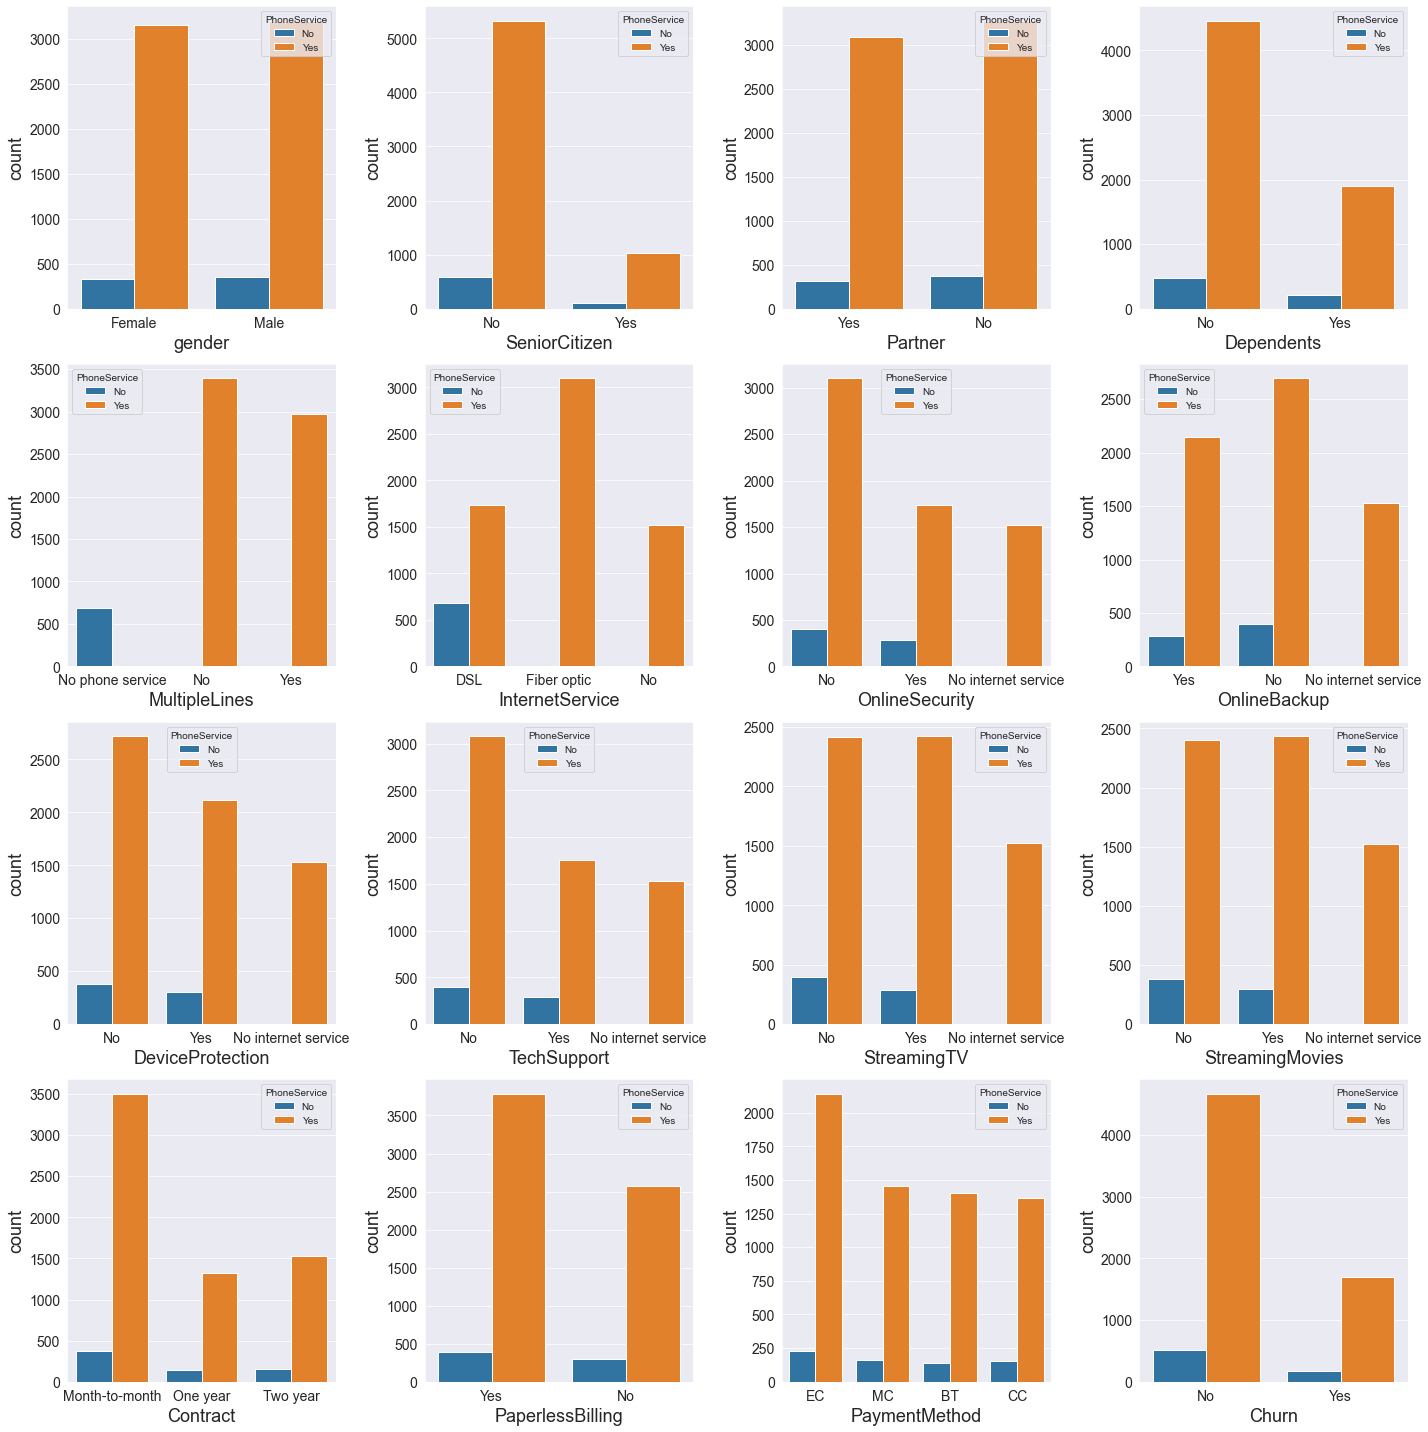

In [76]:
plot_cat(churn,cols[4])

<b>Most of the Senior Citizens seem to opt for phone service. All the people who don't have internet service have phone service. Plus, all the people who opt for Fiber Optics have phone service. Seems phone service is somewhere related to Fiber Optic service, whereas DSL doesn't seem to relate to phone service. 

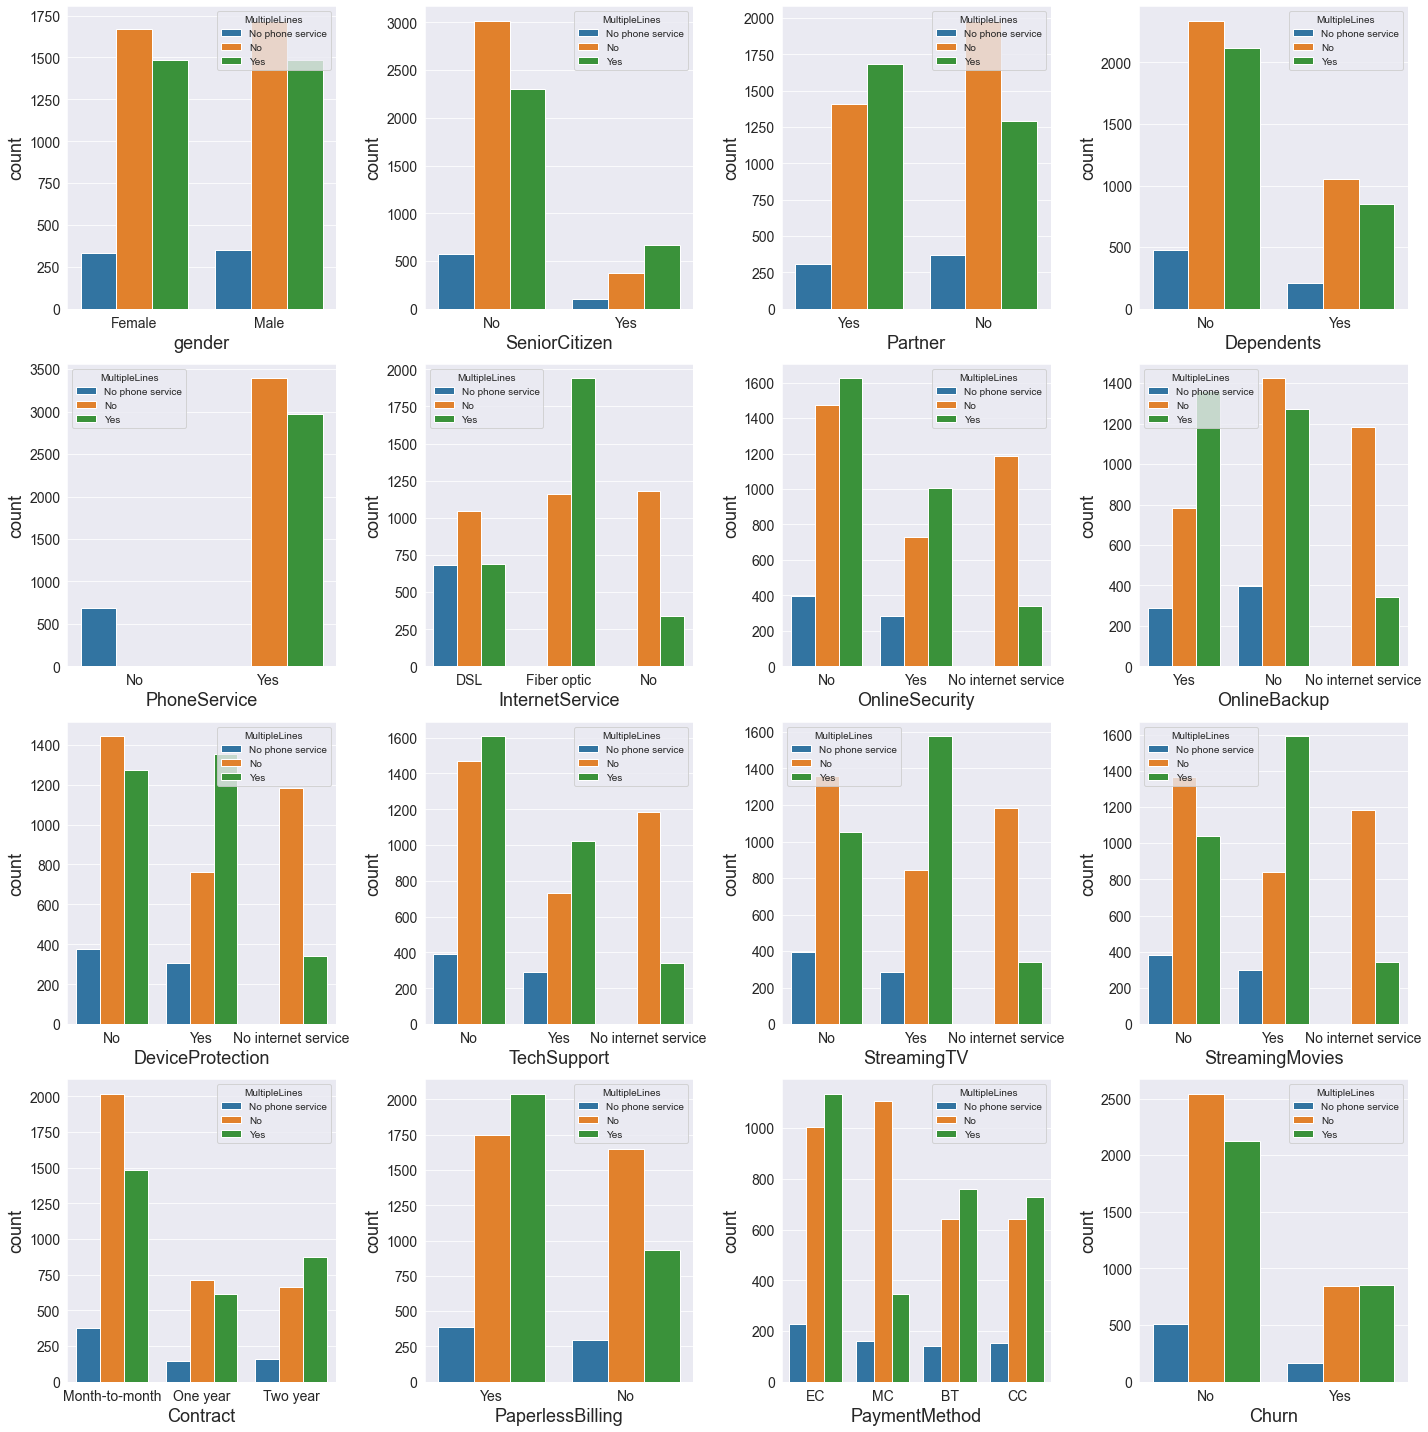

In [77]:
plot_cat(churn,cols[5])

<b>Senior citizens seem to prefer multiple lines and so do people with partners. People opting for Fiber Optics seem to prefer Multiple Lines. Seems they need multiple internet connections and fiber optics is related to phone service. People who opt for internet service, they have higher probability of choosing for other internet services if they have multiple lines. Downside is that people having multiple lines are also on the higher side of churning. It is bad that company is not able to retain potentially extravagent customers.

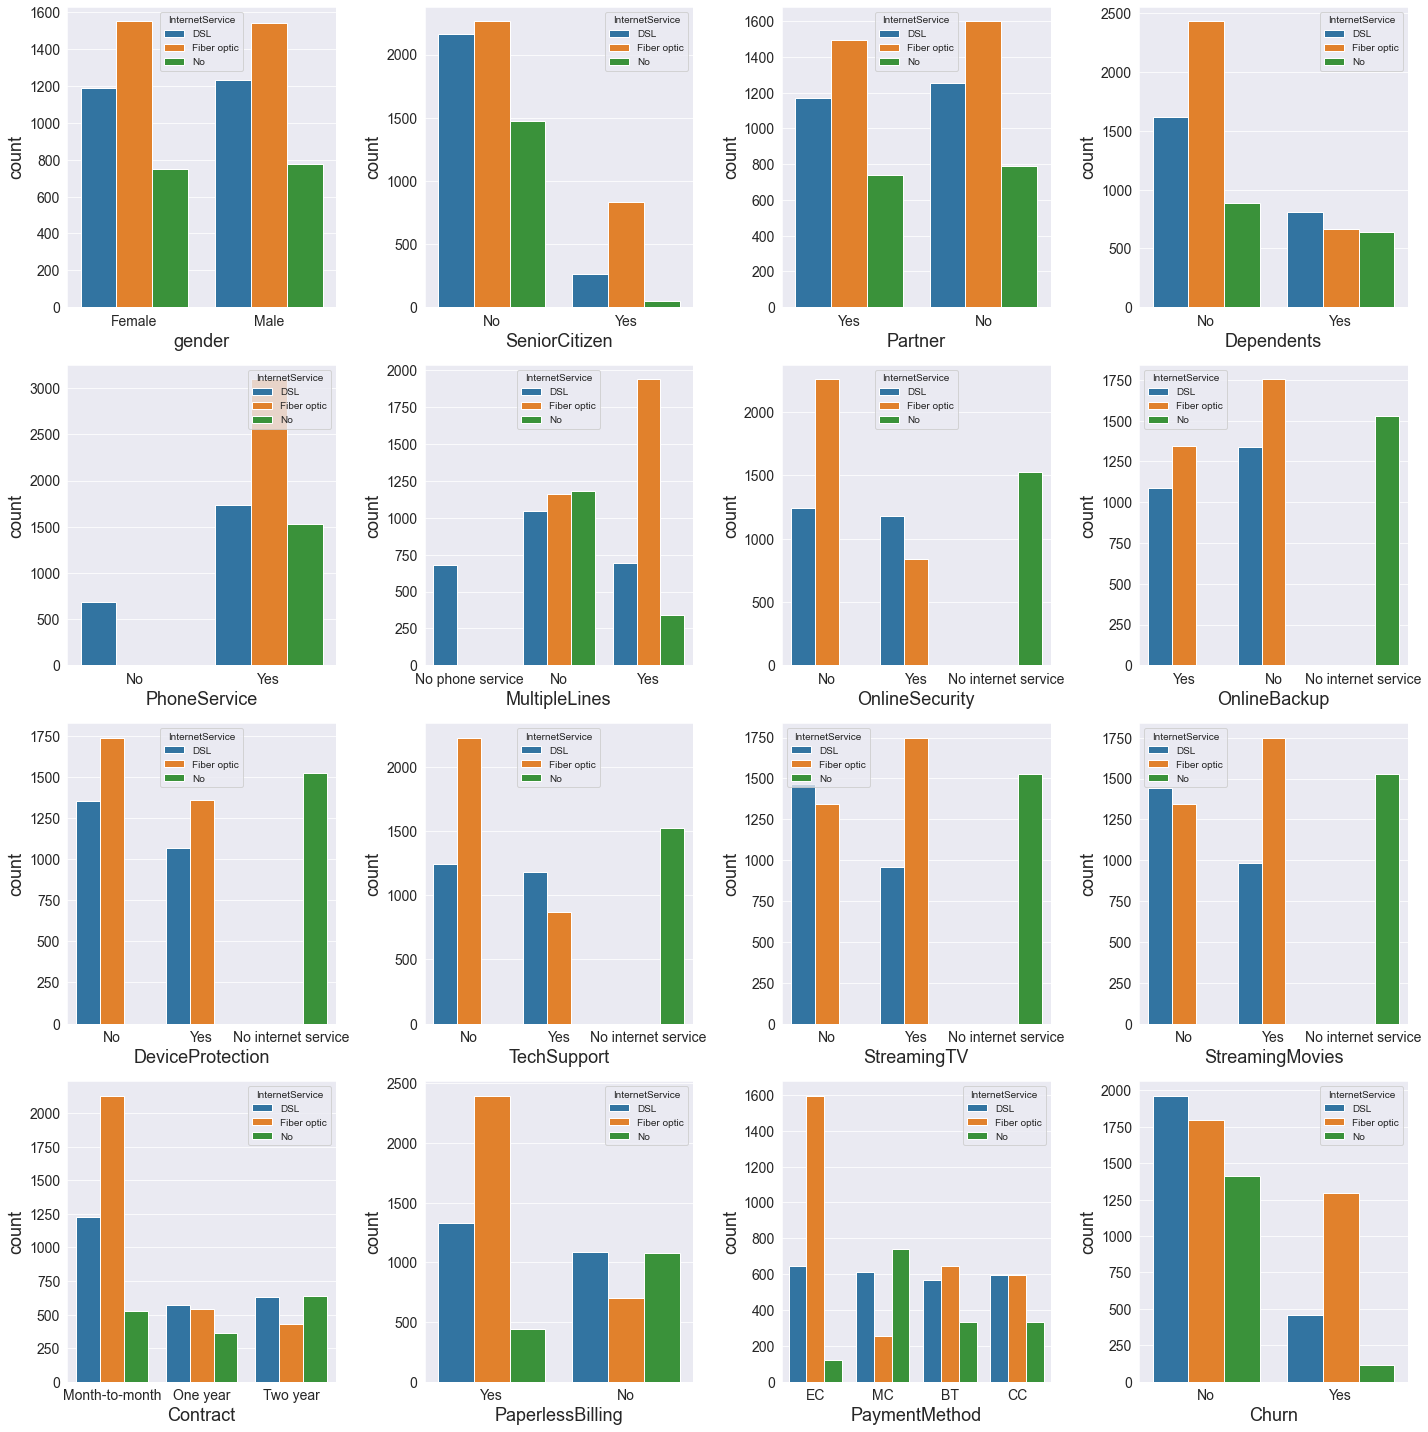

In [78]:
plot_cat(churn,cols[6])

<b>Senior Citizens seem to prefer Fiber Optics. People with no dependents also prefer fiber optics but people with dependents seem to prfer DSL. All the people who don't opt for phone service, take the connection of the company for DSL internet Service. People with DSL seem to opt for Techsupport more. It means DSL service is a bit complicated to understand and handle. People with Fiber Optics seems to opt for Streaming TV and Streaming movies a lot. People with fiber optics choose lower tenure. That means people don't have much trust on Fiber Optics service of the company. This should be an alarming bell and company needs to improve its Fiber optics service. It is also reflected in the target variable that people with Fiber Optics seem to churn more. 

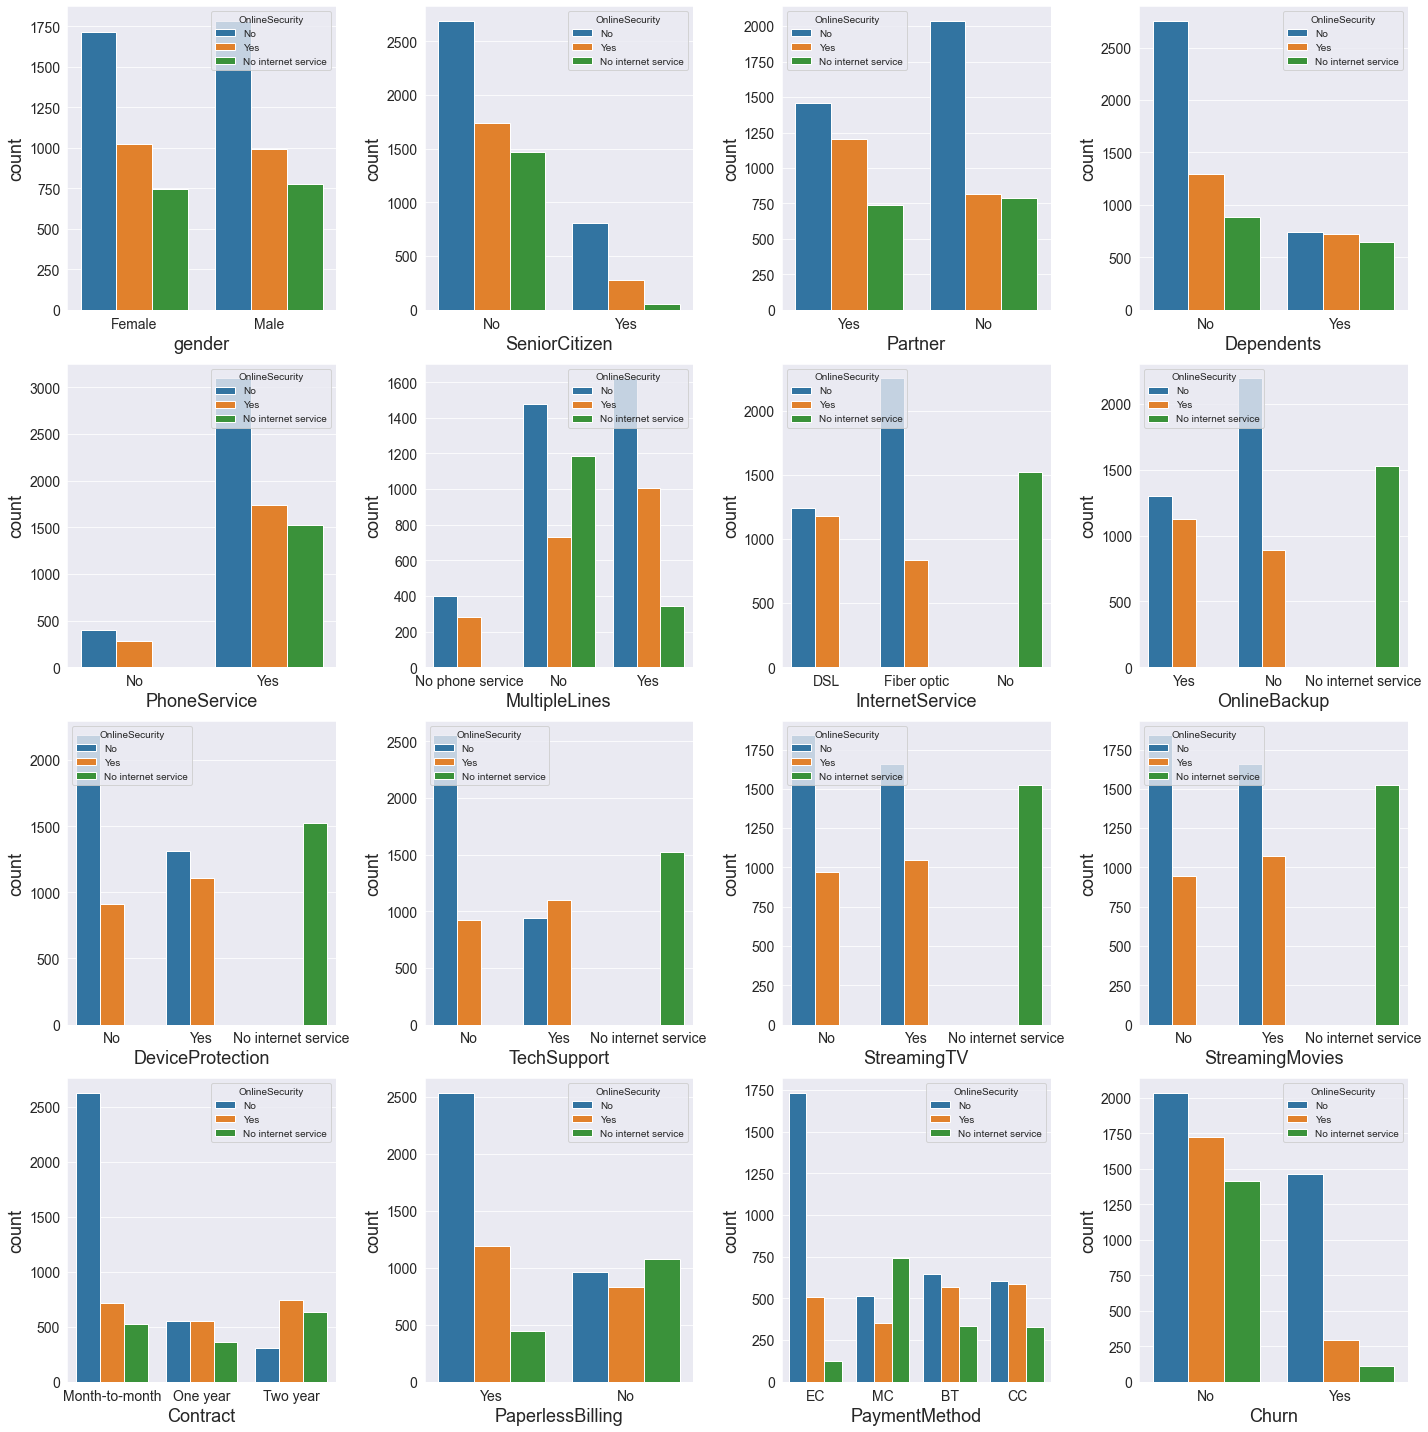

In [79]:
plot_cat(churn,cols[7])

<b>There is no considerably singinficant trend other than the contract term in which people who have opted for OnlineSecurity also have longer contract. Most of the trend that is followed in internet service is also followed here.

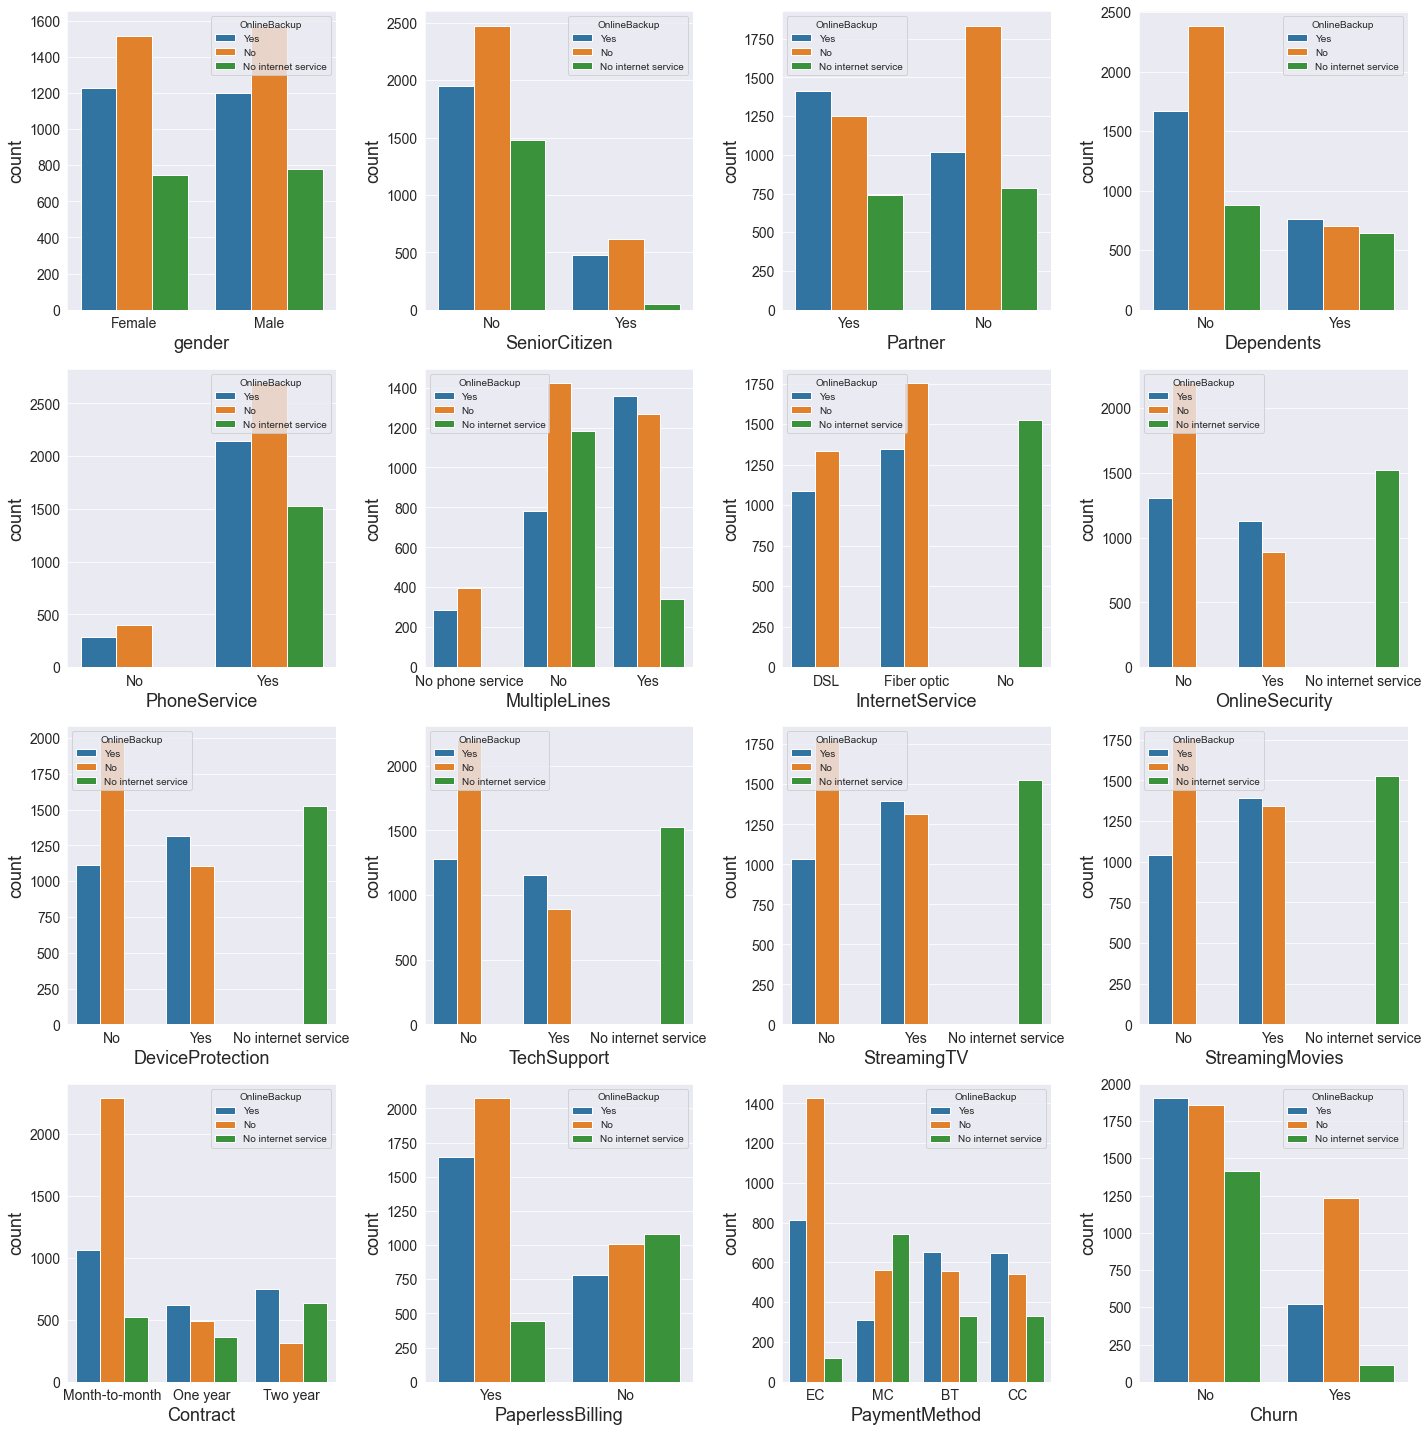

In [80]:
plot_cat(churn,cols[8])

<b>People having no online backup also choose lower contract term. Also they seem to churn more. 

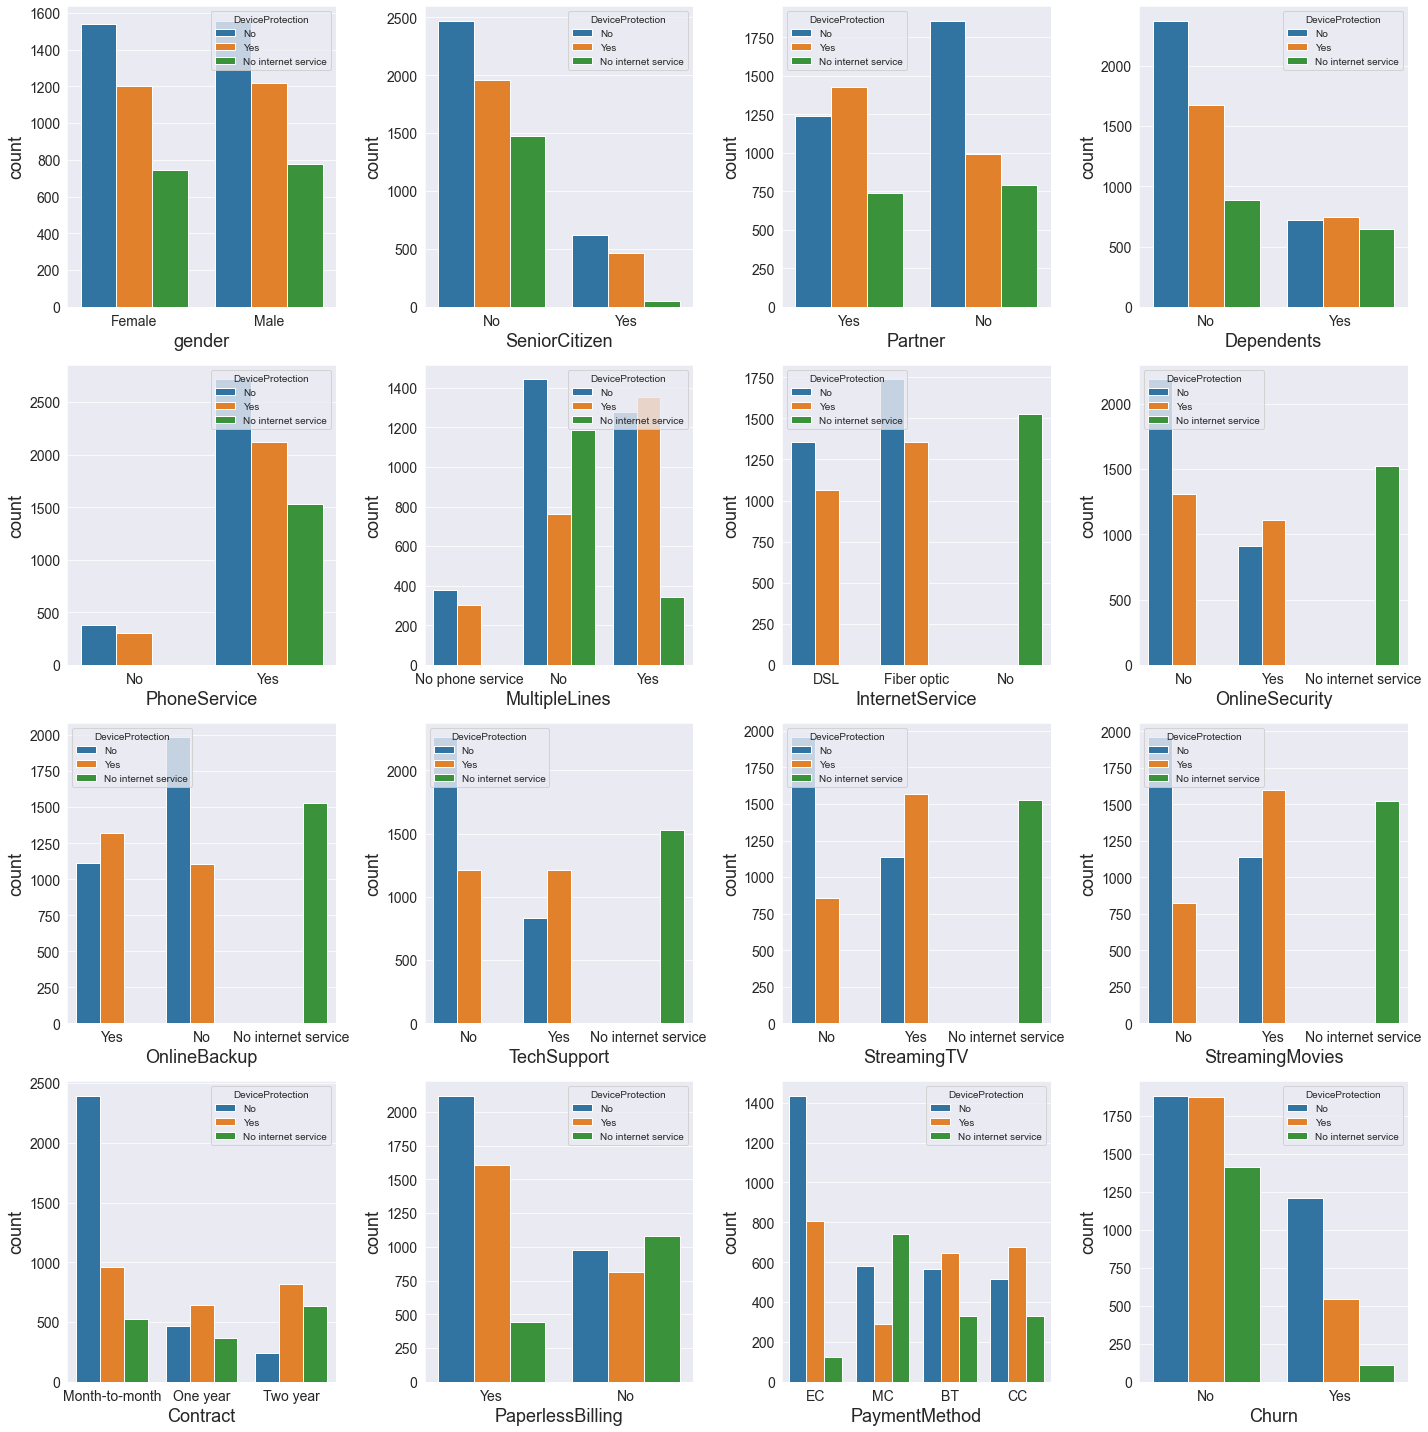

In [81]:
plot_cat(churn,cols[9])

<b>People with partners and dependents seem to choose for device protection more. Customers with multiple lines also choose this more. Rest of the trends are similar to internet service.

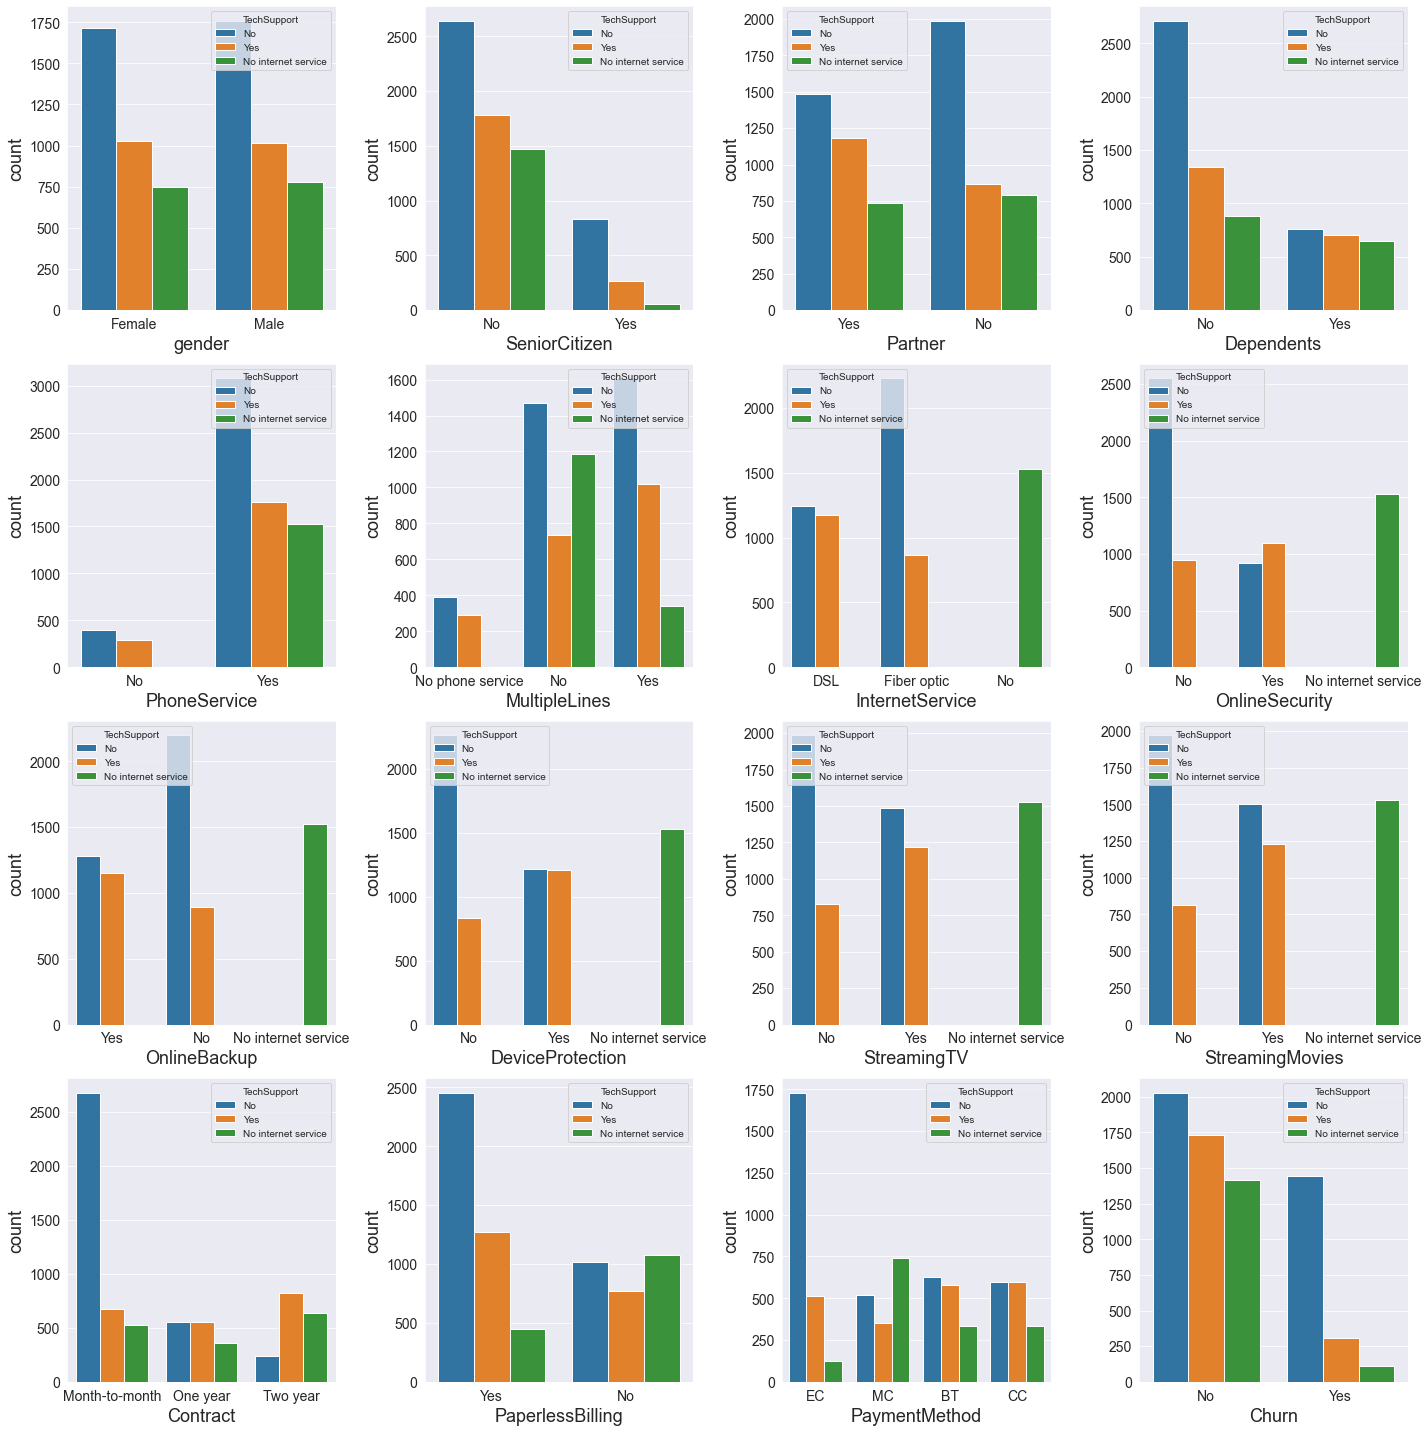

In [82]:
plot_cat(churn,cols[10])

<b>People with DSL seem to choose techsupport more. Also they choose for device protection more. They have higher contract term than others. People with no techsupport seem to churn more than others. 

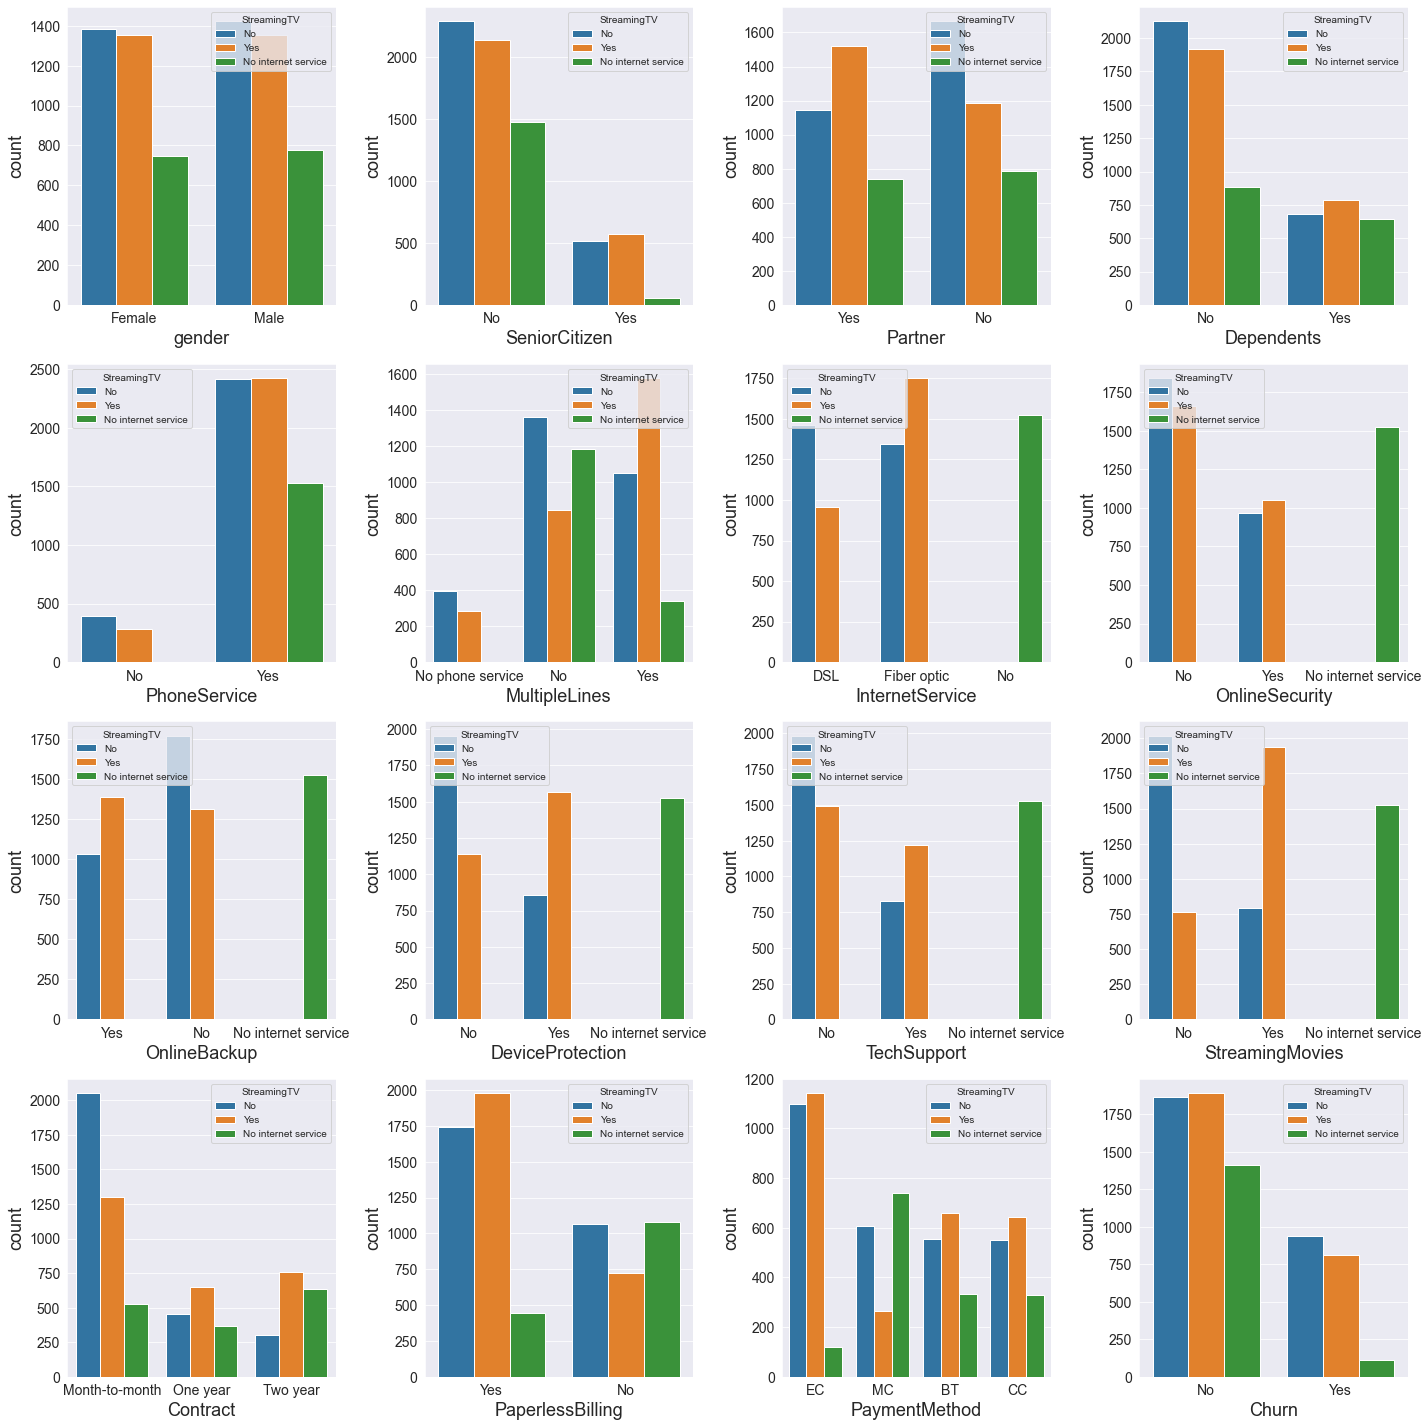

In [83]:
plot_cat(churn,cols[11])

<b>Senior Citizens, people with partners and dependents seem to prefer Streaming TV. This seems to be the choice of all. People with Multiple lines specially chooses Streaming TV. Also people with Fiber Optics seem to opt for it. People also choose device protection and streaming movies who choose streaming TV. They have higher contract and have slightly less chance of churning. 

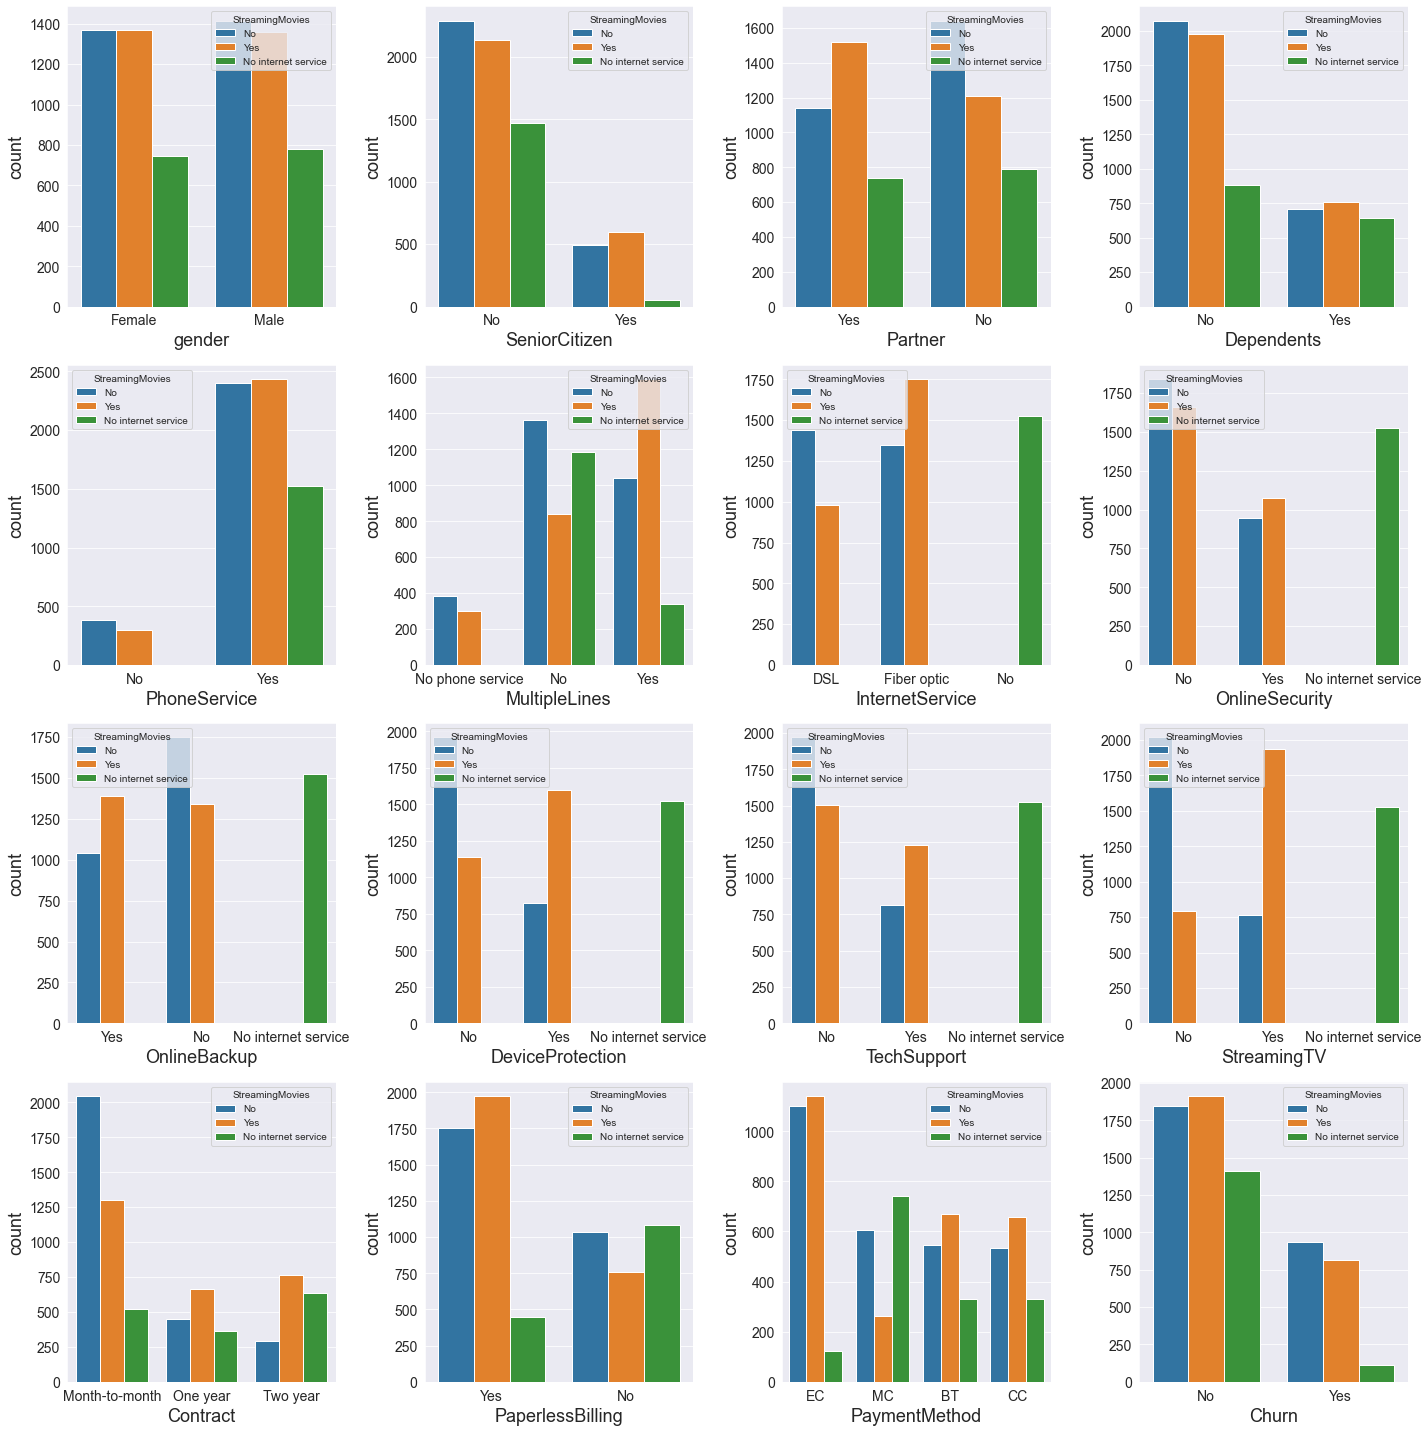

In [84]:
plot_cat(churn,cols[12])

<b>All the trends are similar to what we observed in Streaming TV. 

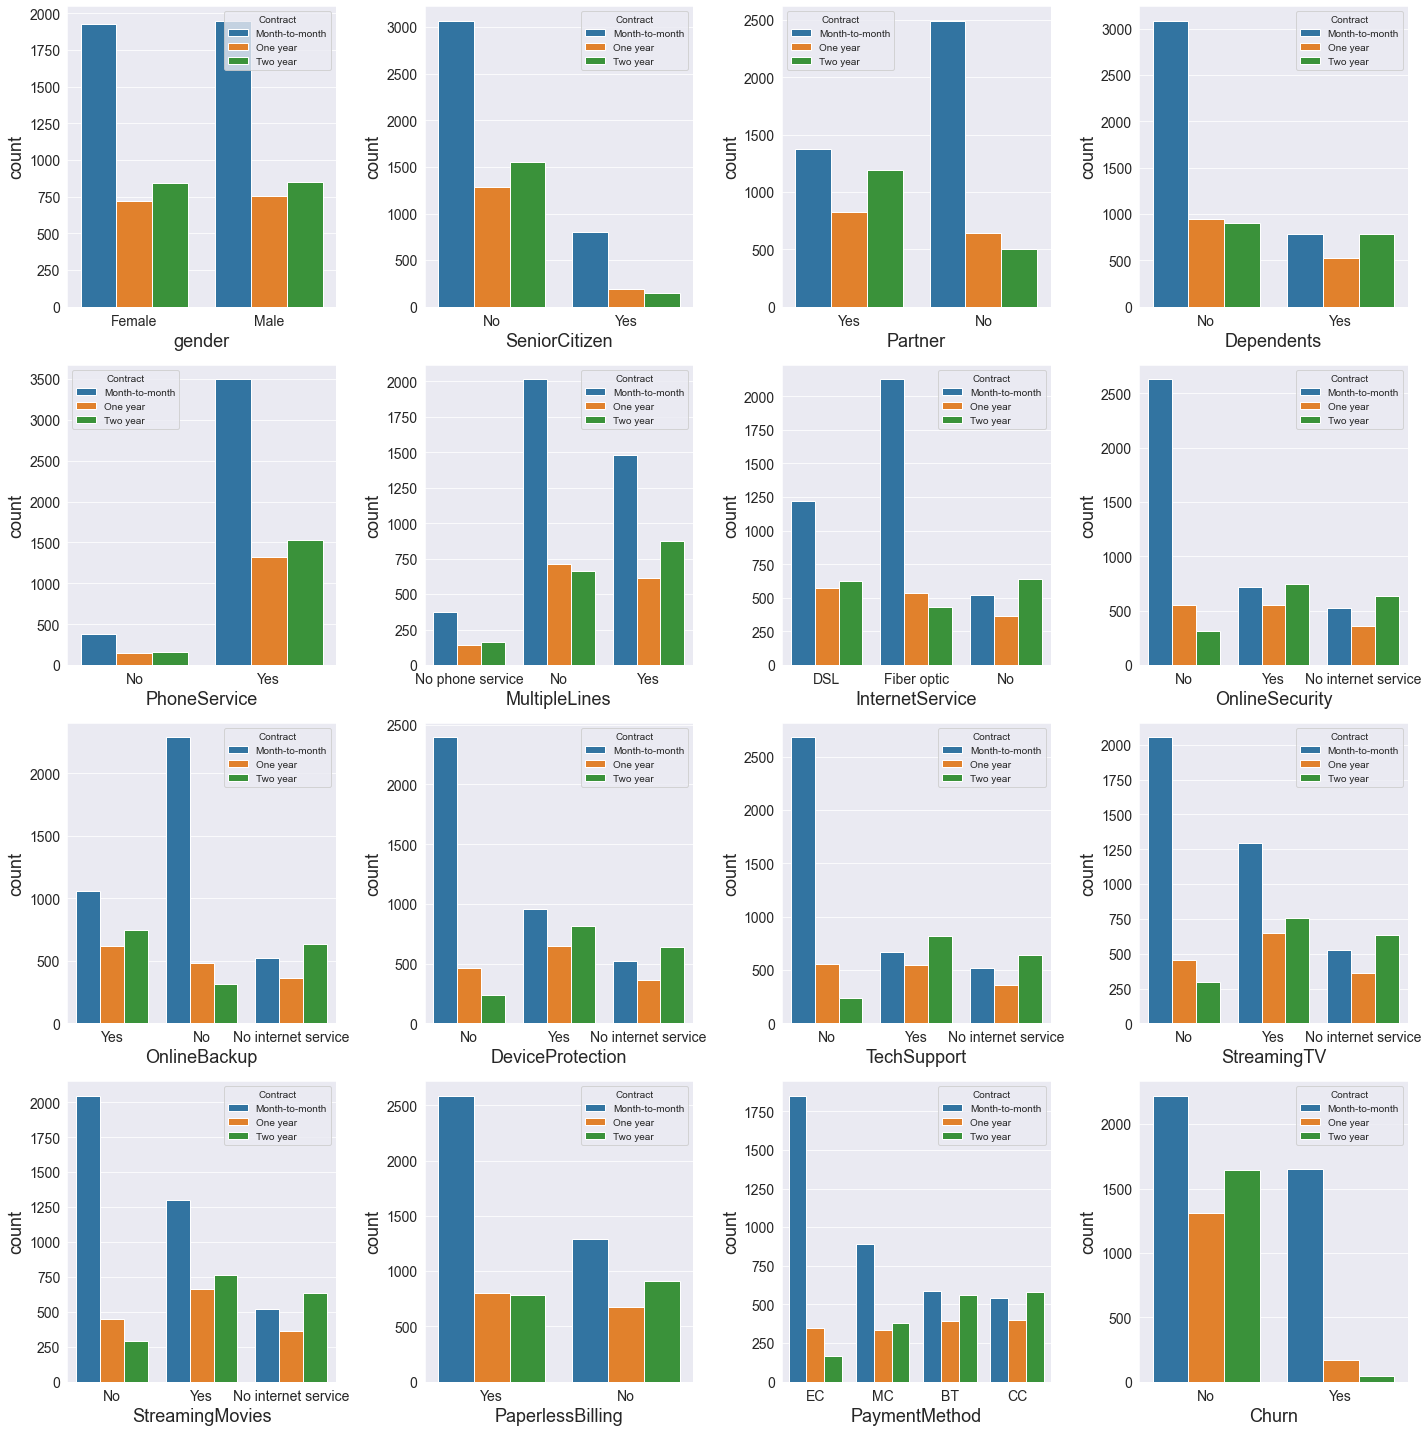

In [85]:
plot_cat(churn,cols[13])

<b>Not many senior citizens go for long term contracts, whereas people with partners and dependents go for it. People with Multiple lines also prefer long contracts. Strange part is people who don't opt for internet service have more probability for choosing higher contract. Which is a cause of concern. Which is also reflected in the target variable that people with less contracts seem to churn more. It also makes sense. 

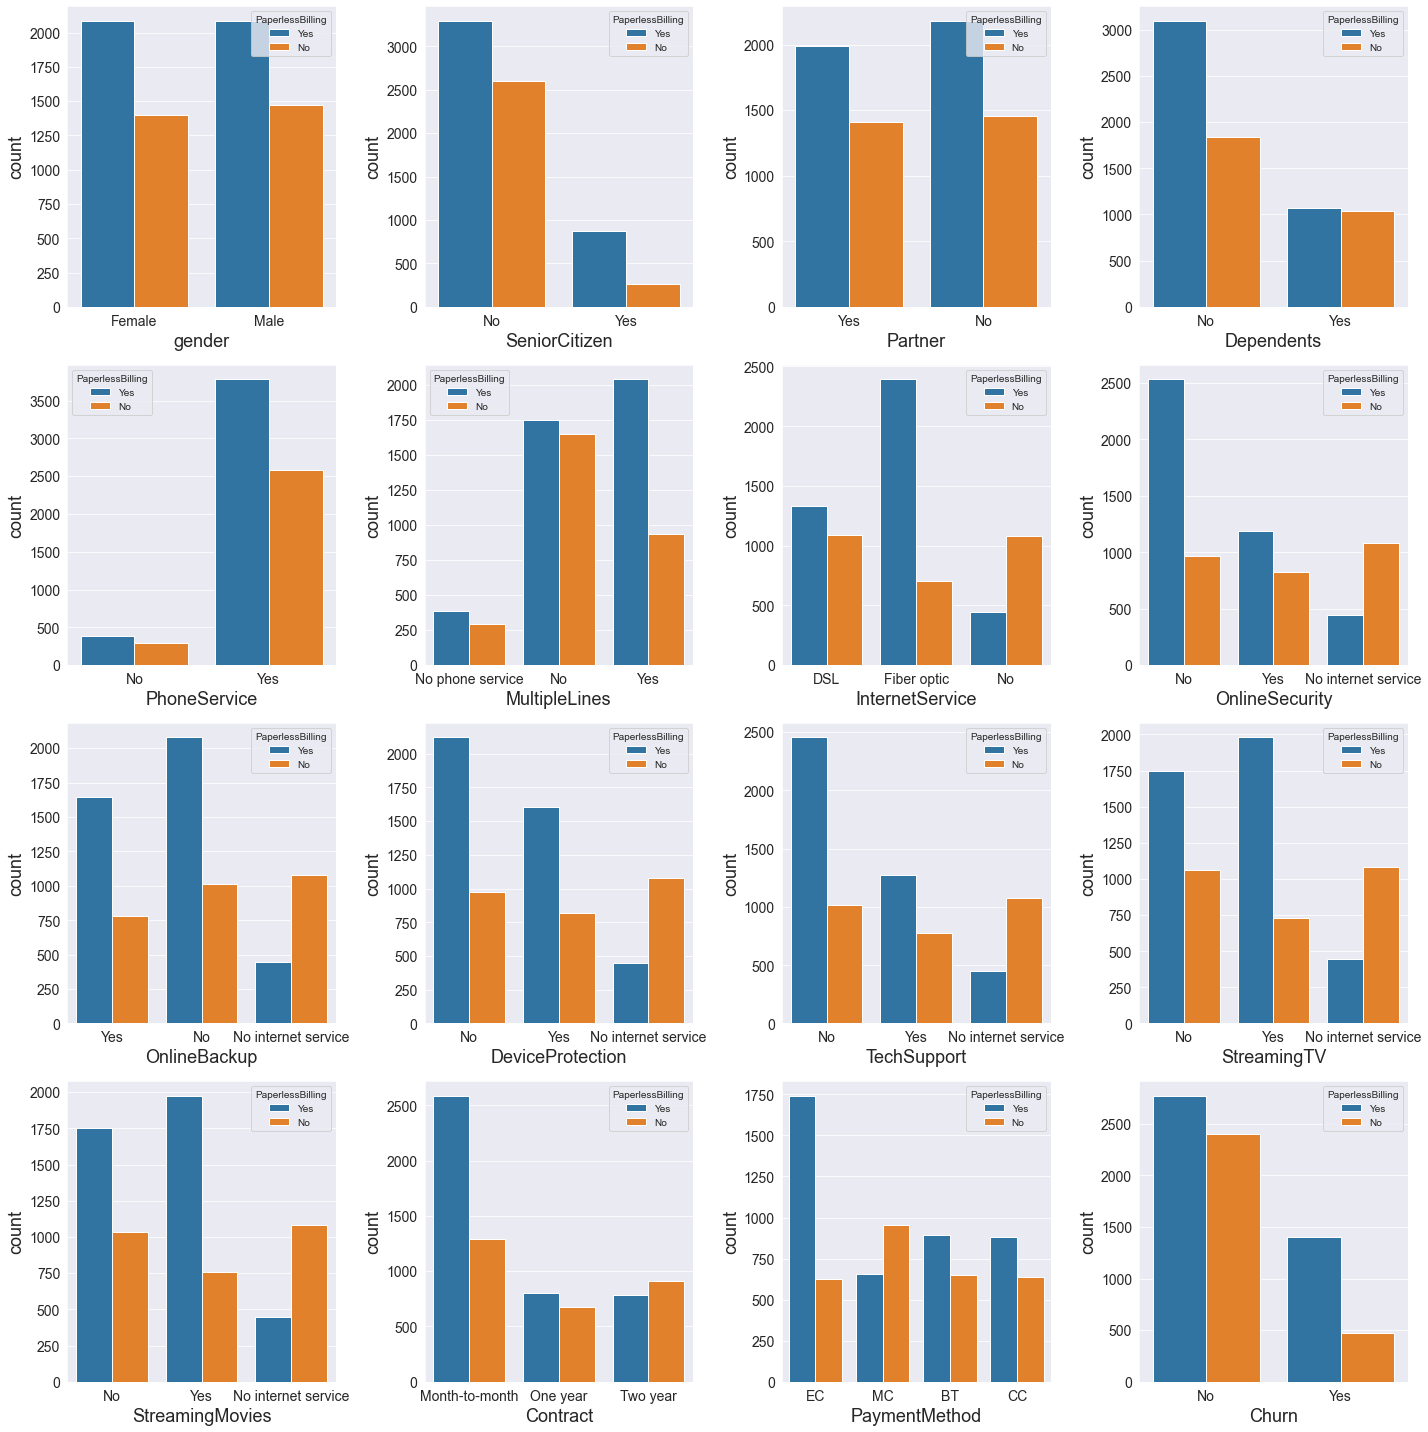

In [86]:
plot_cat(churn,cols[14])

<b>People having dependents seem to opt for paperless billing. Similarly, people with multiple lines also choose paperless billing. People who choose fiber optics also seem to prefer paperless billing. Interestingly, people who don't choose any internet service seem to not prefer paperless billing. People with longer contracts don't choose paperless billings. Mainly it involves Mailed cheques. 

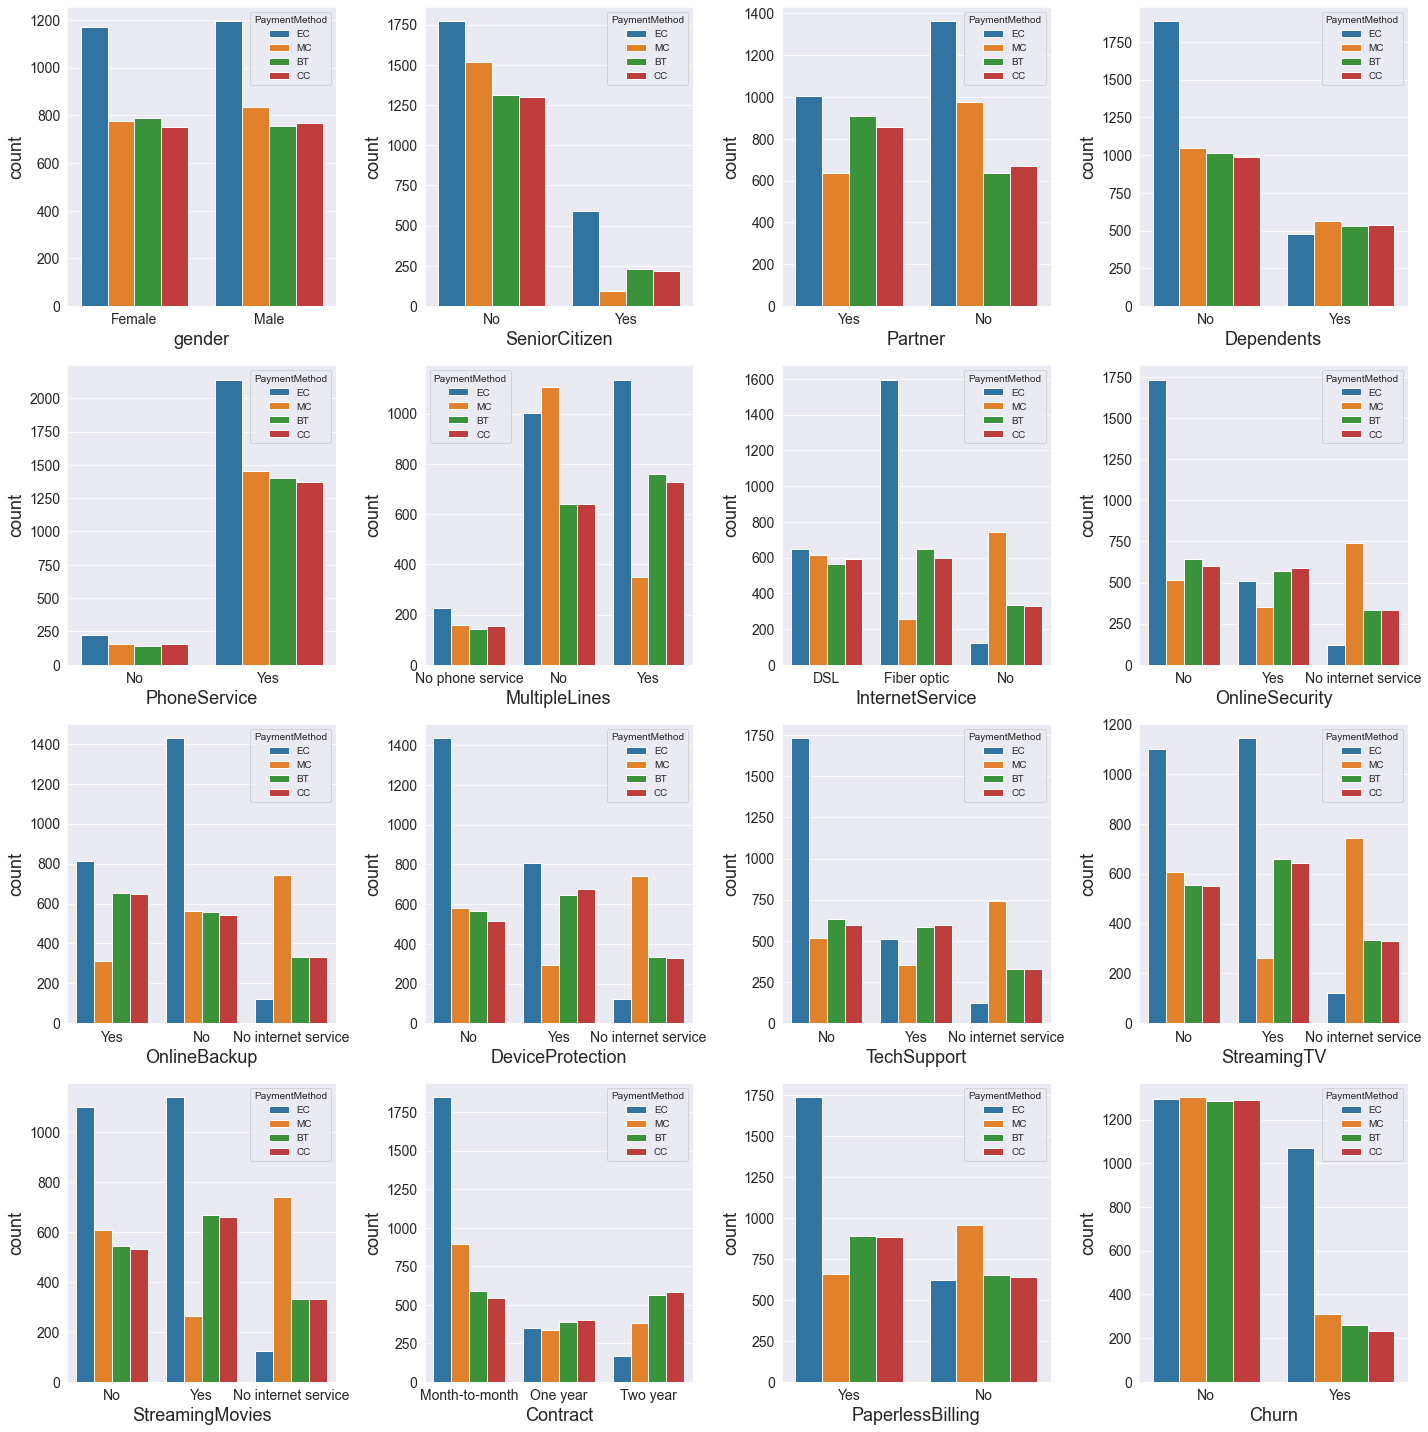

In [87]:
plot_cat(churn,cols[15])

<b>Senior citizens choose Electronic cheques more. People who have no internet service choose Mailed Cheque more. People with credit card and bank transfer have higher contracts. People with Electronic Cheques seem to churn more.

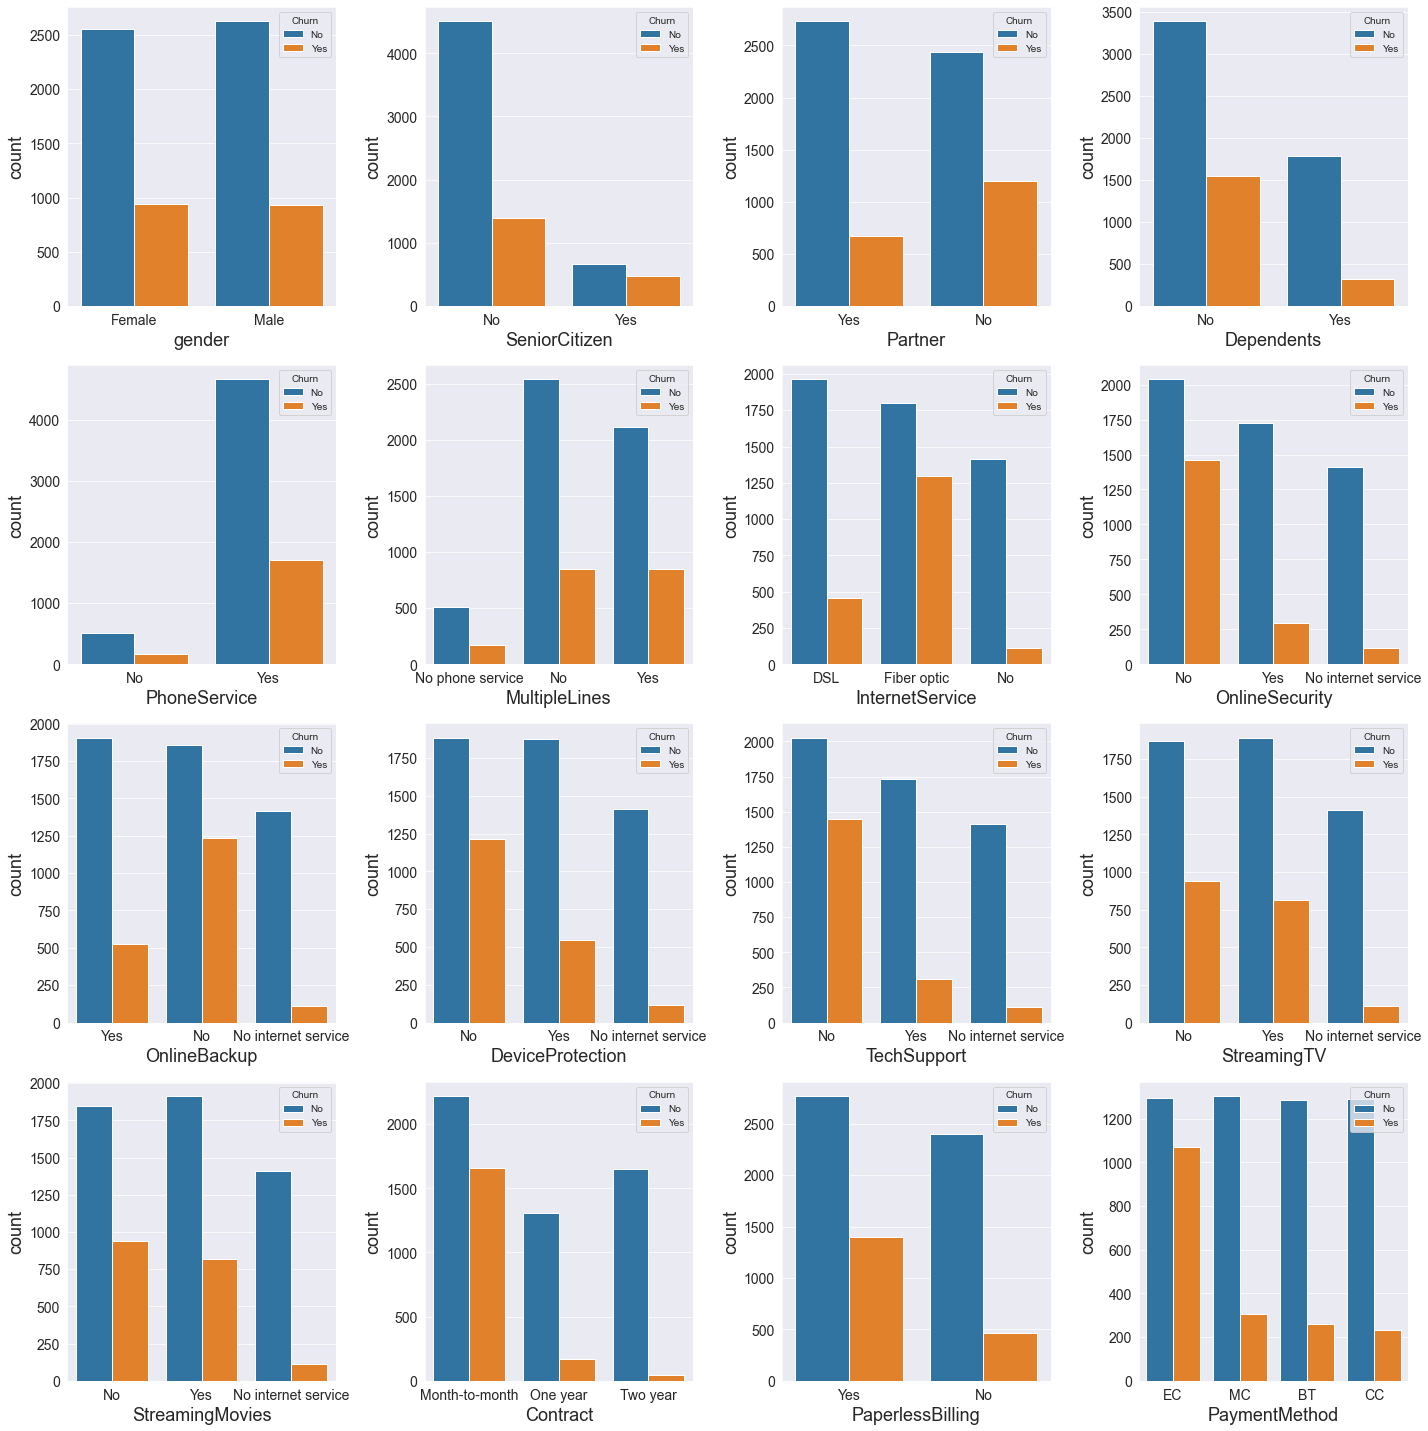

In [88]:
plot_cat(churn,cols[16])

<b>gender</b> doesn't seem to have impact on churning.<br>
<b>SeniorCitizens</b> seem to churn more. <br>
People with <b>partner</b> don't churn much.<br>
Similarly, people with <b>dependents</b> don't churn much.<br>
On <b>PhoneService</b>, churning doesn't seem have much impact. <br>
But people with <b>MultipleLines</b> seem to churn more. Which is a cause of worry. Seems they are not satisfied with the service and are churning away. Company needs to look into it.<br>
This is probably the most alarming thing for the company. People opting for <b>Fiber Optics in InternetService</b> seem to churn the most. That means Fiber Optics service of the company is not upto the mark. Plus there seems to be a better option available to the customers to switch. <br>
People who despite having InternerService don't opt for Internet related services seem to churn more.<br> 
People having short term <b>contracts</b> seem to the churn the most.<br>
People opting for <B>paperless billing</B> also churn more. But this seems it is related to something else and not on paperless billing.<br>
People who opt for <b>Electronic Cheques as PaymentMethod</b> seem to churn the most.

### Now let's do Multi-variate Analysis:

Since there are so many permutation and combination of features that can be formed for this. I am going to stick to importance features and our target variable. 

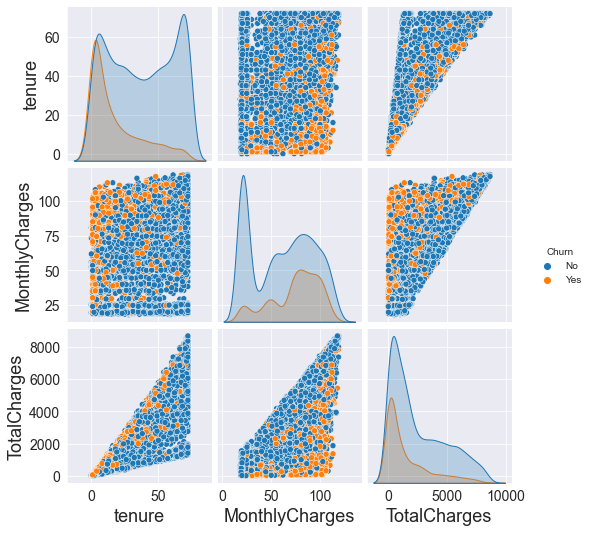

In [89]:
sns.pairplot(data=churn,hue='Churn')

<b>It seems like people who have lower tenure but higher MonthlyCharges seem to churn more. Similarly, people having higher MonthlyCharges but lower TotalCharges seem to churn more. 

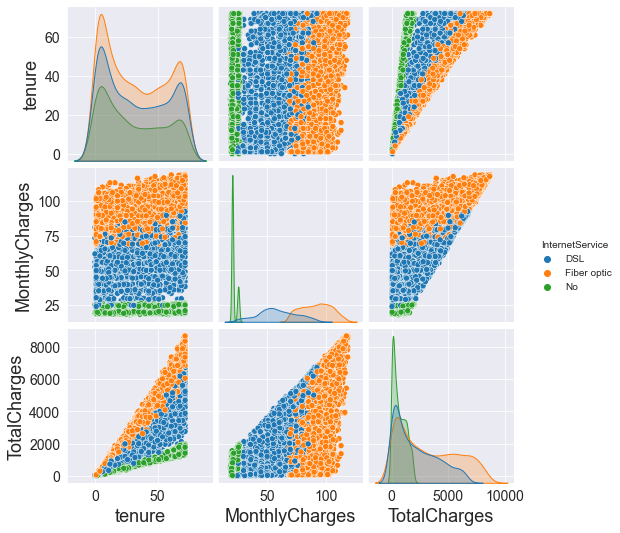

In [90]:
sns.pairplot(data=churn,hue='InternetService')

<b>This seem quite intriguing and forming clear clusters. People with No Internet Service seems to have lower MonthlyCharges and TotalCharges irrespective of their tenure. People with Fiber Optics seems to have the highest Monthly and Total Charges irrespective of their tenure. This seems to be the primary reason many of the people who have Fiber Optics seem to churn. Company seriously need to re-think their pricing of Fiber Optics and give a more competitive pricing to retail these customers. 

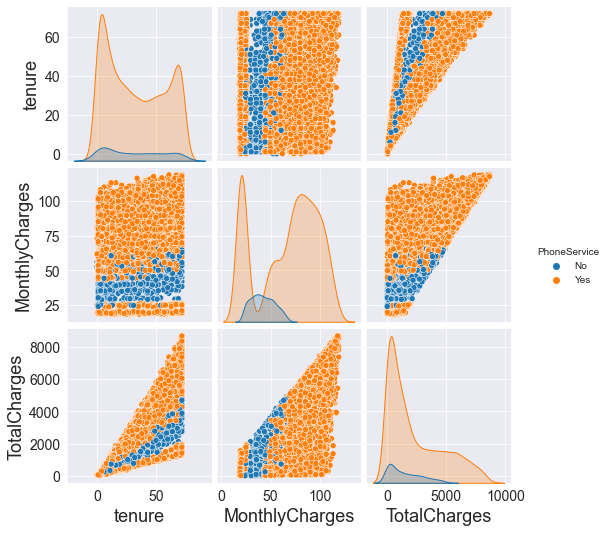

In [91]:
sns.pairplot(data=churn,hue='PhoneService')

Seems like people who have phone service as well as internet service seems to have higher Monthly and Total Charges irrespective of tenure. 

Now, let's do for categorical variables:

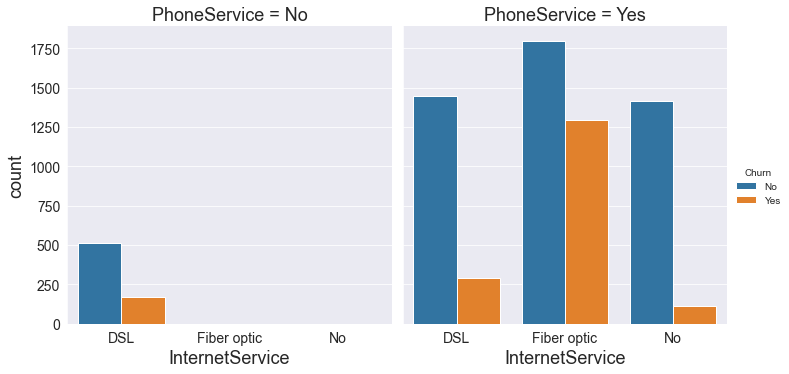

In [92]:
sns.catplot(data=churn,x='InternetService',hue='Churn',col='PhoneService',kind='count')

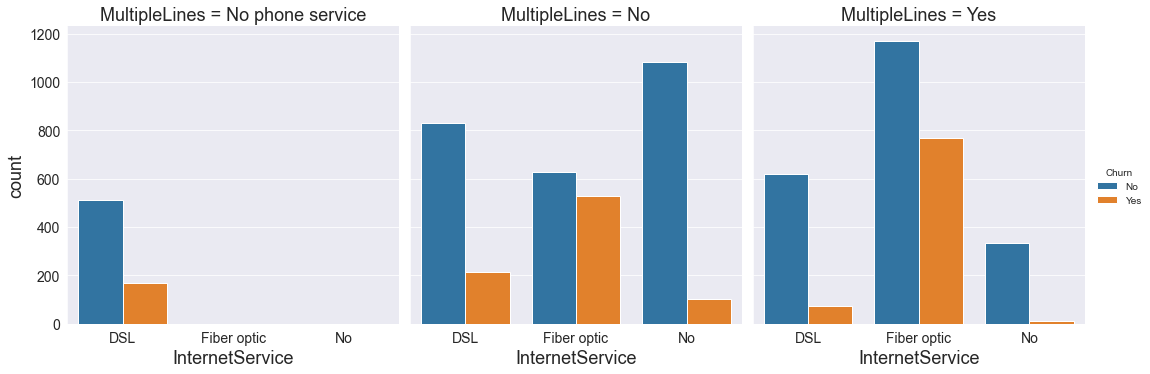

In [93]:
sns.catplot(data=churn,x='InternetService',hue='Churn',col='MultipleLines',kind='count')

Both the above plots tells us that customers with Fiber Optics seem to churn the most.

Now is the time to quantify these observations by doing the appropriate statistical tests over our predictors w.r.t. to our target variable to see which feature is statistically significant in predicting our target variable and which isn't. 

But before that let's see which are the appropriate tests and set the rules for them.<br>

<b>For continuous variables w.r.t. our target variable, i.e., Churn, we will perform ANOVA test</b><br>
1. What is ANOVA test?<br>

ANOVA(Analysis Of Variance) test is a hypothesis testing technique which tests the equality of two or more population means by examining the variances of samples that are taken.

2. Define Null and Alternate Hypothesis:

* $H_0$: Means(i.e. $\mu$) of all the samples are same.
* $H_A$: At least one mean (i.e., $\mu$) differs

3. Let's decide our significance level:

### <center>$\alpha$ = 0.05</center>

4. Let's identify our test statistic:

ANOVA uses F-tests and F-statistic to statistically test the equality of means

5. Set the rules to accept or reject the Null Hypothetis:

* If p-value comes out to be greater than our significance level, i.e., 0.05, then we will fail to reject Null Hypothesis.
* If p-value comes out to be less than our significance level, we will reject our Null Hypothesis.

<b>For Categorical variables w.r.t. our target variable, i.e., Churn, we will perform Chi-Square Test for Independence:</b>

1. What is Chi-square test for Independence?

The Chi-Square Test of Independence determines whether there is an association between categorical variables (i.e., whether the variables are independent or related). It is a non-parametric test.

This test utilizes a contingency table to analyze the data. A contingency table is an arrangement in which data is classified according to two categorical variables. The categories for one variable appear in the rows, and the categories for the other variable appear in columns.


$\chi^2$ = $\sum_{i=1}^{n}\sum_{j=1}^{m}\frac{({O_{ij}-E_{ij}})^2}{E_{ij}}$

where

${O_{ij}}$ is the observed cell count in the ith row and jth column of the contingency table

${E_{ij}}$ is the expected cell count in the ith row and jth column of the contingency table

The corresponding degrees of freedom is (r - 1) * ( c  - 1) , where r is the number of rows and c is the number of columns in the contingency table.

2. Let's decide Null Hypothesis and Alternate Hypothesis:

* $H_0$: Proportions of observed and expected values are same.
* $H_A$: Proportions of observed and expected values are different.

3. Let's decide our significance level:

### <center>$\alpha$ = 0.05</center>

4. Let's identify our test statistic:

Chi-square test uses $\chi^2$ statistic to find out the independence of categorical variables.

5. Set the rules to accept or reject the Null Hypothetis:

* If p-value comes out to be greater than our significance level, i.e., 0.05, then we will fail to reject Null Hypothesis.
* If p-value comes out to be less than our significance level, we will reject our Null Hypothesis.

In [94]:
obj_cols = churn.drop(['customerID','Churn'],axis=1).select_dtypes(include='object').columns
num_cols = churn.select_dtypes(exclude='object').columns
start = "\033[1m"
end = '\033[0m'

for i in num_cols:
    data = pd.concat([churn[i],churn['Churn']],axis=1).dropna().copy(deep=True)    
    mod = ols("%s ~ Churn" %i,data=data).fit()
    anova = sm.stats.anova_lm(mod,typ=2)
    print(start+"\t\t\t Statistical Analysis of %s \n" %i + end)
    print(anova)
    print('\n')
    print('.'*100)

for i in obj_cols:
    print(start+"\t\tContingency Table for Analysis of %s with Churn is:" %i+end)
    print(pd.crosstab(churn[i],churn['Churn'],margins=True))
    print('\n')
    print('.'*100)
    obs = np.array(pd.crosstab(churn[i],churn['Churn']))
    chi_sq_Stat, p_value, deg_freedom, exp_freq = stats.chi2_contingency(obs)
    print(start+"\t\t\t Statistical Analysis of %s \n" %i + end)
    print("P-Value of the test is:",p_value)
    print('\n')
    print('_'*100)


			 Statistical Analysis of tenure 

                sum_sq      df          F         PR(>F)
Churn     5.269675e+05     1.0  997.26801  7.999058e-205
Residual  3.720542e+06  7041.0        NaN            NaN


....................................................................................................
			 Statistical Analysis of MonthlyCharges 

                sum_sq      df           F        PR(>F)
Churn     2.383740e+05     1.0  273.463704  2.706646e-60
Residual  6.137530e+06  7041.0         NaN           NaN


....................................................................................................
			 Statistical Analysis of TotalCharges 

                sum_sq      df           F        PR(>F)
Churn     1.423466e+09     1.0  288.347899  2.057692e-63
Residual  3.475879e+10  7041.0         NaN           NaN


....................................................................................................
		Contingency Table for Analysis of gender with Churn

Churn               No   Yes   All
PaperlessBilling                  
No                2403   469  2872
Yes               2771  1400  4171
All               5174  1869  7043


....................................................................................................
			 Statistical Analysis of PaperlessBilling 

P-Value of the test is: 4.073354668665985e-58


____________________________________________________________________________________________________
		Contingency Table for Analysis of PaymentMethod with Churn is:
Churn            No   Yes   All
PaymentMethod                  
BT             1286   258  1544
CC             1290   232  1522
EC             1294  1071  2365
MC             1304   308  1612
All            5174  1869  7043


....................................................................................................
			 Statistical Analysis of PaymentMethod 

P-Value of the test is: 3.6823546520097993e-140


________________________________________

<b>All our continuous variables <b>Tenure, MonthlyCharges and TotalCharges</b> seem to be quite significant. Hence, we can comfortably reject the Null Hypothesis for them. 

As for Categorical Variables are concerned:
    
Gender: Not significant. Fail to reject the Null Hypothesis.

SeniorCitizen: Significant. Can Comfortably reject Null Hypothesis.

Partner: Significant. Can Comfortably reject Null Hypothesis.
    
Dependents: Significant. Can Comfortably reject Null Hypothesis.

PhoneService: Not significant. Fail to reject the Null Hypothesis.

MultipleLines: Significant. Can Comfortably reject Null Hypothesis.

InternetService: Significant. Can Comfortably reject Null Hypothesis.

OnlineSecurity: Significant. Can Comfortably reject Null Hypothesis.

OnlineBackup: Significant. Can Comfortably reject Null Hypothesis.

DeviceProtection: Significant. Can Comfortably reject Null Hypothesis.

TechSupport: Significant. Can Comfortably reject Null Hypothesis.

StreamingTV: Significant. Can Comfortably reject Null Hypothesis.

StreamingMovies: Significant. Can Comfortably reject Null Hypothesis.

Contract: Significant. Can Comfortably reject Null Hypothesis.

PaperlessBilling: Significant. Can Comfortably reject Null Hypothesis.

PaymentMethod: Significant. Can Comfortably reject Null Hypothesis.

## Automating all the data-cleaning part:

<b>Let's now automate our process of imputing missing values, correcting the data-types of the data-set, one-hot encoding of categorical variables and binning of the numerical variables:

In [95]:
# Function to impute missing values

def missing_values(df):
    obj_cols = df.select_dtypes(include='object').columns
    for i in obj_cols:
        n = [x for x in df[i] if x.isdigit()]
        if len(n) > 0:
            for j in range(len(df[i])):
                try:
                    df.loc[j,i] = float(df.loc[j,i])
                except:
                    df.loc[j,i] = np.nan
            df[i] = df[i].astype(float)
            
    obj_cols = df.select_dtypes(include='object').columns # Since I am converting columns to float above, I need to re-do this
    check_null = df[obj_cols].isnull().sum().values
    for i in range(len(check_null)):
        if check_null[i] > 0:
            fill_value = df[obj_cols[i]].value_counts(sort=True).index[0]
            df[obj_cols[i]] = df[obj_cols[i]].fillna(fill_value)
            
    num_cols = df.select_dtypes(exclude='object').columns
    check_null = df[num_cols].isnull().sum().values
    
    for i in range(len(check_null)):
        if check_null[i] > 0:
            if num_cols[i] == 'tenure':
                df[num_cols[i]] = df[num_cols[i]].fillna(0)
            else:
                # Checking for already label encoded categorical variables.
                count_check = df[num_cols[i]].value_counts().index
                if len(count_check) < 5:
                    df[num_cols[i]] = df[num_cols[i]].fillna(count_check[0])
                    
                # This is for actual numerical variables.
                else:
                    q = df[df[num_cols[i]].isnull() == True].index
                    for j in q:
                        tenure_value = df.loc[j,'tenure']
                        fill_null = df[(df['tenure'] > (tenure_value-2)) & (df['tenure'] < (tenure_value + 2))][num_cols[i]].mean()
                        df.loc[j,num_cols[i]] = fill_null

                
    return df           
    

In [96]:
# Function which imputes the missing values by calling the above function and then encode it and bin it. 

def miss_label(df):
    # First treating for missing values
    df = missing_values(df)
    
    obj_cols = df.drop('customerID',axis=1).select_dtypes(include='object').columns
    
    # For the categoricals variables having values like 'No Internet Service' and 'No Phone Service'
    for i in obj_cols:
        ind_toreplace = [x for x,y in enumerate(df[i]) if y.strip().startswith('No')]
        df.loc[ind_toreplace,i] = 'No'
         
    df = pd.get_dummies(df,columns=obj_cols,drop_first=True)
    
    num_cols = df.select_dtypes(exclude='object').columns
    
    # Bucketing the numerical variables
    for i in num_cols:
        count_check = df[i].value_counts().index
        
        if len(count_check) > 5:
            df[i] = pd.qcut(df[i],q=[0,0.25,0.5,0.75,1],labels=[0,1,2,3])
            df[i] = df[i].astype(int)
    
    return df

In [97]:
# Let's perform all our operations on a new datadrame
new_df = df.copy(deep=True)

In [98]:
new_df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [99]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [100]:
#Let's call our function
new_df = miss_label(new_df)

In [101]:
new_df.head()

customerID  SeniorCitizen  tenure  MonthlyCharges  TotalCharges  \
0  7590-VHVEG              0       0               0             0   
1  5575-GNVDE              0       2               1             2   
2  3668-QPYBK              0       0               1             0   
3  7795-CFOCW              0       2               1             2   
4  9237-HQITU              0       0               2             0   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0            0            1               0                 0   
1            1            0               0                 1   
2            1            0               0                 1   
3            1            0               0                 0   
4            0            0               0                 1   

   MultipleLines_Yes  InternetService_Fiber optic  InternetService_No  \
0                  0                            0                   0   
1                  0                            0                   0   
2                  0                            0                   0   
3                  0                            0                   0   
4                  0                            1                   0   

   OnlineSecurity_Yes  OnlineBackup_Yes  DeviceProtection_Yes  \
0                   0                 1                     0   
1                   1                 0                     1   
2                   1                 1                     0   
3                   1                 0                     1   
4                   0                 0                     0   

   TechSupport_Yes  StreamingTV_Yes  StreamingMovies_Yes  Contract_One year  \
0                0                0                    0                  0   
1                0                0                    0                  1   
2                0                0                    0                  0   
3                1                0                    0                  1   
4                0                0                    0                  0   

   Contract_Two year  PaperlessBilling_Yes  \
0                  0                     1   
1                  0                     0   
2                  0                     1   
3                  0                     0   
4                  0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  Churn_Yes  
0                           0          0  
1                           1          0  
2                           1          1  
3                           0          0  
4                           0          1

In [102]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   customerID                             7043 non-null   object
 1   SeniorCitizen                          7043 non-null   int64 
 2   tenure                                 7043 non-null   int32 
 3   MonthlyCharges                         7043 non-null   int32 
 4   TotalCharges                           7043 non-null   int32 
 5   gender_Male                            7043 non-null   uint8 
 6   Partner_Yes                            7043 non-null   uint8 
 7   Dependents_Yes                         7043 non-null   uint8 
 8   PhoneService_Yes                       7043 non-null   uint8 
 9   MultipleLines_Yes                      7043 non-null   uint8 
 10  InternetService_Fiber optic            7043 non-null   uint8 
 11  InternetService_N

<b>We have converted all our features numeric type except customerID which we are going to drop it anyways.

## Data Pre-processing

Since our target variable is highly imbalanced, We will use over-sampling technique, SMOTE, to improve our model

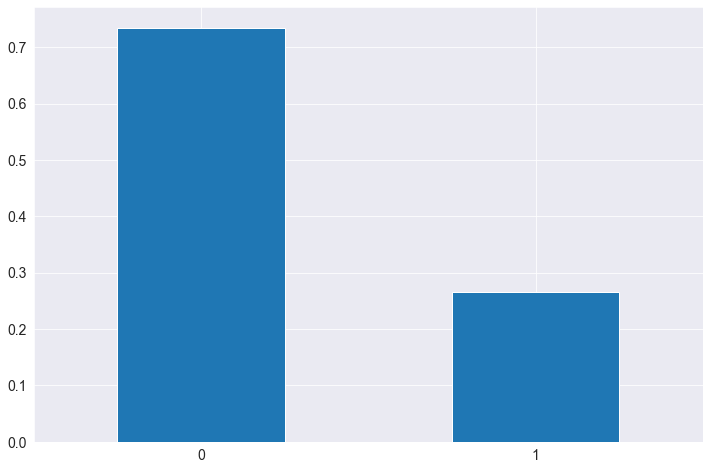

In [103]:
new_df['Churn_Yes'].value_counts(normalize=True).plot.bar(rot=0);

In [104]:
# Segregating features and target variable
X = new_df.drop(['customerID','Churn_Yes'],axis=1)
y = new_df['Churn_Yes']

In [105]:
# Creating instance of Over-sampling technique
smote = SMOTE(random_state=108)

In [106]:
# Creating over-sampling data
X_smote , y_smote = smote.fit_sample(X,y)

In [107]:
# Spliting training and Testing data without any technique
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=108,stratify=y)

In [108]:
# Spliting training and testing data for over-sampling data
X_sm_train,X_sm_test,y_sm_train,y_sm_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=108,stratify=y_smote)

Since we are using stratify option in our split, we don't need to check for the proportion of data in train and test based on our target variable. They will be same proportion as in the data-set. Stratify ensures that.

## Model training, testing and tuning

In [109]:
# Creating lists to save metrics of normal and over-sampled data

all_metric = []
all_metric_sm = []

In [110]:
# Let's create a function for choosing parameters for tuning all the models that we are going to build

def params(mod_name):
    if mod_name.startswith('L'):
        param = {'penalty':['l1','l2'],
                'C':[0.01,0.1,1,10,100],
                'solver':['lbfgs', 'saga']}
        
    elif mod_name.startswith('N'):
        param = {'var_smoothing':[10**-8,10**-9,10**-10]}
        
    elif mod_name.startswith('K'):
        param = {'n_neighbors':[5,9,13,17,21,25,29,33,35],
                'weights':['distance']}
        
    elif mod_name.startswith('S'):
        param = {'C':[0.1,1,10],
                'gamma':[0.1,1,10],
                'class_weight':['balanced']}
        
    elif mod_name.startswith('D'):
        param = {'criterion':['gini','entropy'],
                'max_depth':[5,7,9,11],
                'class_weight':['balanced']}
        
    elif mod_name.startswith('B'):
        param = {'n_estimators':[25,50],
                 'max_samples':[0.8,0.9],
                 'random_state':[108]}
        
    elif mod_name.startswith('R'):
        param = {'class_weight':['balanced'],
                 'random_state':[108],
                 'n_estimators':[100,200,300],
                 'max_depth':[5,7,9,11]
                }
        
    elif mod_name.startswith('G'):
        param = {'learning_rate':[0.01,0.05,0.1,0.2],
                 'random_state':[108],
                 'n_estimators':[100,200]
                }
        
    elif mod_name.startswith('X'):
        param = {
                 "objective": ['multi:softmax'],
                "num_class":[2],
                "eval_metric": ['logloss'],
                "eta":[0.05, 0.10, 0.20, 0.30 ],
                 "max_depth":[ 13, 15, 17, 20],
                'random_state':[108],
                 #"min_child_weight" : [ 1, 3, 5, 7 ],
                 #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
#                  'subsample': [0.6, 0.8, 1.0],
                 #'n_estimators': [100,200,300]
                 }
        
    return param

In [111]:
# Created a function which can fit the model based on the parameters passed in it and return the performance metrics

def evaluate_model(X_train, y_train, mod, model_name, X_test = X_test, y_test = y_test):
    param = params(model_name)
    s_split = StratifiedShuffleSplit(n_splits=3,test_size=0.2,random_state=108)
    model = GridSearchCV(mod,param_grid=param,cv=s_split)
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    preds = model.predict(X_test)
    s_split = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=108)
    scores = cross_val_score(model, X_train, y_train, cv=s_split, scoring="accuracy")
    diff = scores.mean() - accuracy_score(y_test,preds)
    start = "\033[1m"
    end = '\033[0m'
    
    print(start+'Best Parameters are:'+end,model.best_params_)
    print(start+"Training Score:"+end,accuracy_score(y_train,train_preds))
    print(start+"Cross V Score: "+end,scores.mean()," +/-" ,scores.std())
    print(start+"Testing Score:"+end, accuracy_score(y_test,preds))
    print(start+"Cross & Test Diff:"+end,diff)
    print(start+"\n \t\t\t\tConfusion Matrix "+end)
    print("\t\t\t\t-----------------")
    cm = confusion_matrix(y_test,preds)
    cm_df = pd.DataFrame(cm,index=['No','Yes'],columns=['No','Yes'])
    p = sns.heatmap(cm_df,annot=True,cmap='RdBu_r',annot_kws={'size':15})
    _ = p.set(xlabel='Predicted Labels',ylabel='True Labels',xticklabels=['No','Yes'],
              yticklabels=['No','Yes'])
    plt.show()
    print("\n")
    print(start+"\t\t\tClassification Report\n"+end,classification_report(y_test, preds))
    
    record_metric = {'Model_name':model_name,
                 'Training_score': accuracy_score(y_train,train_preds),
                 'Cross_val_score':scores.mean(),
                  'Testing_score':accuracy_score(y_test,preds),
                  'Recall_score':recall_score(y_test,preds),
                 'Precision_score':precision_score(y_test,preds),
                  'F1_score':f1_score(y_test,preds)}


    return record_metric

In [112]:
# Let's create instances of all the models that we are going to build here

log_reg = LogisticRegression(class_weight='balanced',max_iter=1000)

nb = GaussianNB()

knn = KNeighborsClassifier()

svm = SVC()

dtree = DecisionTreeClassifier()

bag = BaggingClassifier()

rforest = RandomForestClassifier()

grad_boost = GradientBoostingClassifier()

xg_boost = xgb.XGBClassifier(random_state=108)

Let's start building our model, which will also be tuned automatically, since we have created a function of our parameters and passed it into our model building function which will take appropriate parameters based on the name of the model.

Best Parameters are: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Score: 0.7565922920892495
Cross V Score:  0.7521298174442189  +/- 0.0030493501781689728
Testing Score: 0.754850922858495
Cross & Test Diff: -0.0027211054142760593

 				Confusion Matrix 
				-----------------


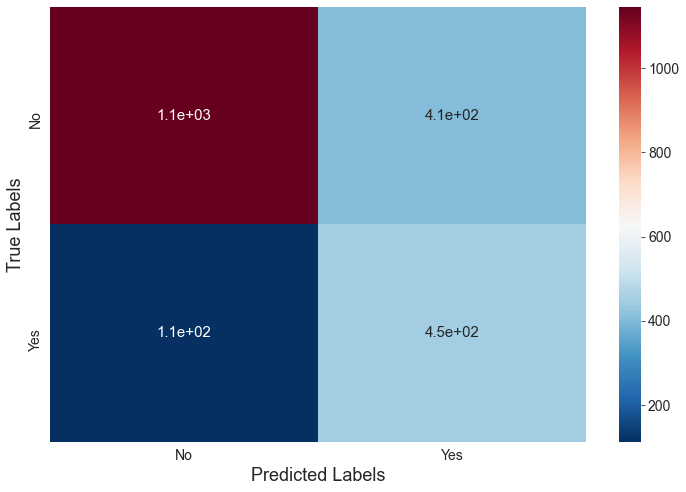



			Classification Report
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1552
           1       0.53      0.80      0.63       561

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.72      2113
weighted avg       0.81      0.75      0.77      2113



In [80]:
# This is our Logistic Regression model with normal data-set
log_reg_metric = evaluate_model(X_train,y_train,log_reg,'Logistic Regression')

In [81]:
# Let's append these metrics in our list
all_metric.append(log_reg_metric)

Best Parameters are: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Training Score: 0.7872428551705094
Cross V Score:  0.7846790890269151  +/- 0.006983635964485038
Testing Score: 0.7906602254428341
Cross & Test Diff: -0.0059811364159190195

 				Confusion Matrix 
				-----------------


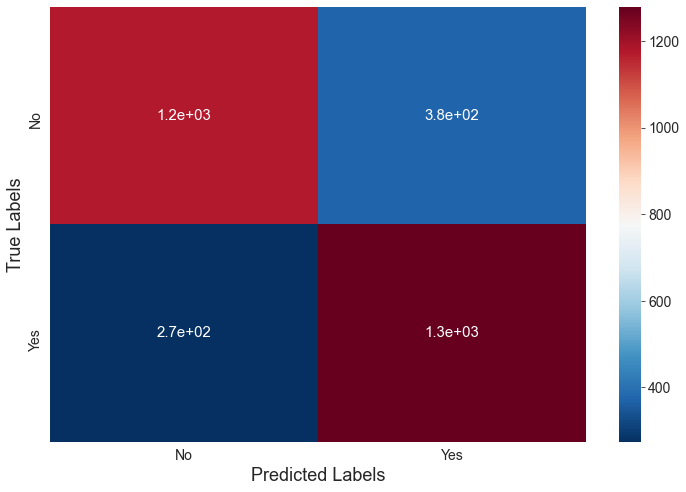



			Classification Report
               precision    recall  f1-score   support

           0       0.81      0.76      0.78      1552
           1       0.77      0.82      0.80      1553

    accuracy                           0.79      3105
   macro avg       0.79      0.79      0.79      3105
weighted avg       0.79      0.79      0.79      3105



In [82]:
# Logistic Regression Model with Over-sampled data

log_reg_metric_sm = evaluate_model(X_sm_train,y_sm_train,log_reg,'Logistic Regression',X_test=X_sm_test,y_test=y_sm_test)

In [83]:
all_metric_sm.append(log_reg_metric_sm)

Best Parameters are: {'var_smoothing': 1e-08}
Training Score: 0.7535496957403651
Cross V Score:  0.7448275862068965  +/- 0.005034350363485158
Testing Score: 0.7520113582584004
Cross & Test Diff: -0.007183772051503889

 				Confusion Matrix 
				-----------------


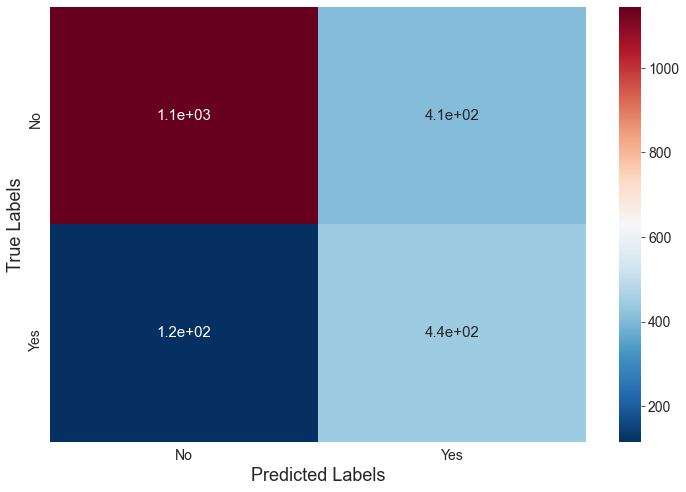



			Classification Report
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1552
           1       0.52      0.79      0.63       561

    accuracy                           0.75      2113
   macro avg       0.71      0.77      0.72      2113
weighted avg       0.81      0.75      0.76      2113



In [85]:
# Naive Bayes with normal data

nb_metric = evaluate_model(X_train,y_train,nb,'Naive Bayes')

In [86]:
all_metric.append(nb_metric)

Best Parameters are: {'var_smoothing': 1e-08}
Training Score: 0.775783515118045
Cross V Score:  0.7773636991028294  +/- 0.009488738298024683
Testing Score: 0.7816425120772947
Cross & Test Diff: -0.004278812974465307

 				Confusion Matrix 
				-----------------


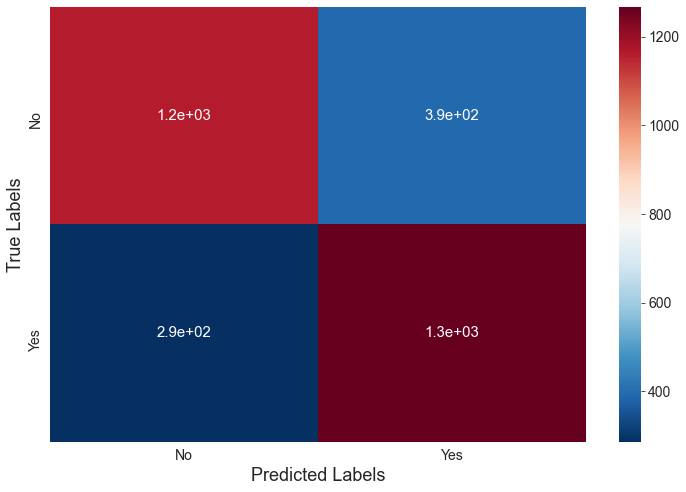



			Classification Report
               precision    recall  f1-score   support

           0       0.80      0.75      0.77      1552
           1       0.76      0.82      0.79      1553

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105



In [87]:
# Naive Bayes with Over-sampled Data
nb_metric_sm = evaluate_model(X_sm_train,y_sm_train,nb,'Naive Bayes',X_test=X_sm_test,y_test=y_sm_test)

In [88]:
all_metric_sm.append(nb_metric_sm)

Best Parameters are: {'n_neighbors': 33, 'weights': 'distance'}
Training Score: 0.9614604462474645
Cross V Score:  0.7772819472616632  +/- 0.011084037397415225
Testing Score: 0.7856128726928537
Cross & Test Diff: -0.008330925431190517

 				Confusion Matrix 
				-----------------


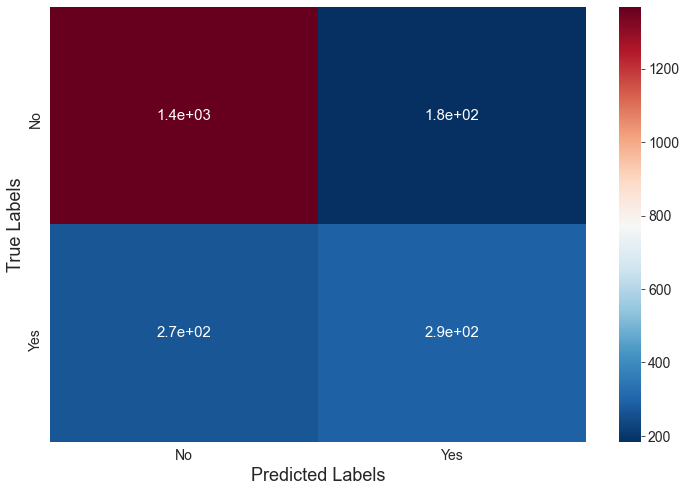



			Classification Report
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1552
           1       0.61      0.52      0.56       561

    accuracy                           0.79      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



In [89]:
# KNN with normal Data

knn_metric = evaluate_model(X_train,y_train,knn,'K Nearest Neighbors')

In [90]:
all_metric.append(knn_metric)

Best Parameters are: {'n_neighbors': 5, 'weights': 'distance'}
Training Score: 0.9505729670026232
Cross V Score:  0.7864734299516909  +/- 0.006742125461322161
Testing Score: 0.7938808373590982
Cross & Test Diff: -0.007407407407407307

 				Confusion Matrix 
				-----------------


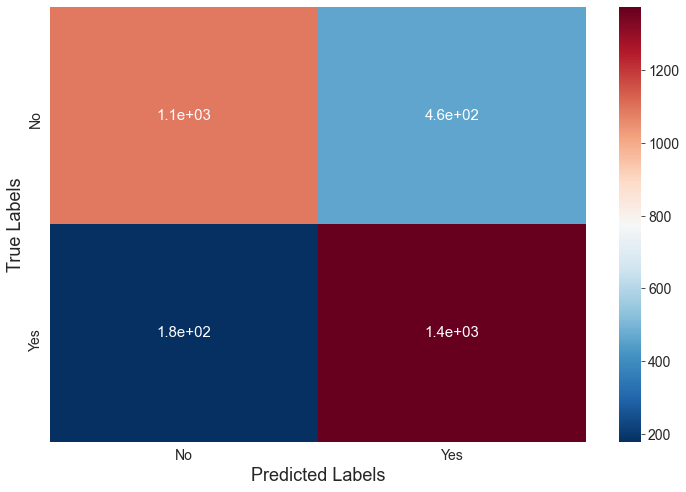



			Classification Report
               precision    recall  f1-score   support

           0       0.86      0.70      0.77      1552
           1       0.75      0.89      0.81      1553

    accuracy                           0.79      3105
   macro avg       0.80      0.79      0.79      3105
weighted avg       0.80      0.79      0.79      3105



In [91]:
# KNN with Over-sampled data

knn_metric_sm = evaluate_model(X_sm_train,y_sm_train,knn,'K Nearest Neighbors',X_test=X_sm_test,y_test=y_sm_test)

In [92]:
all_metric_sm.append(knn_metric_sm)

Best Parameters are: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 1}
Training Score: 0.8415821501014199
Cross V Score:  0.7862068965517242  +/- 0.0066474521737013665
Testing Score: 0.7841930903928065
Cross & Test Diff: 0.0020138061589176637

 				Confusion Matrix 
				-----------------


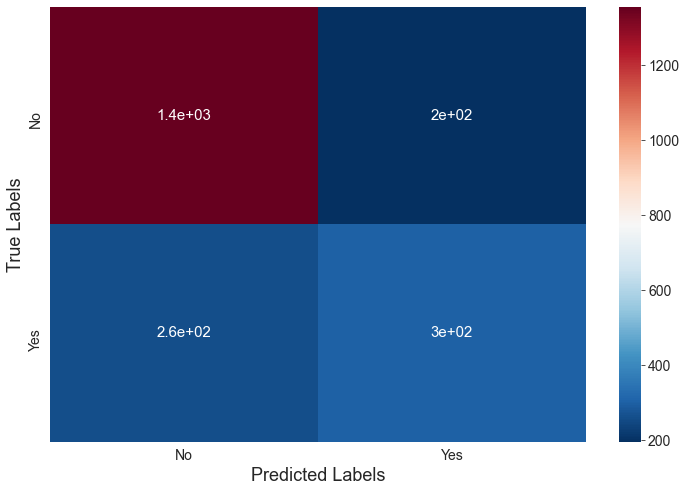



			Classification Report
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      1552
           1       0.61      0.54      0.57       561

    accuracy                           0.78      2113
   macro avg       0.72      0.71      0.71      2113
weighted avg       0.78      0.78      0.78      2113



In [93]:
# Support Vector Machines with normal data

svm_metric = evaluate_model(X_train,y_train,svm,'Support Vector Machines')

In [94]:
all_metric.append(svm_metric)

Best Parameters are: {'C': 10, 'class_weight': 'balanced', 'gamma': 1}
Training Score: 0.9534723181002347
Cross V Score:  0.8274672187715666  +/- 0.008270063314807584
Testing Score: 0.8328502415458937
Cross & Test Diff: -0.0053830227743271175

 				Confusion Matrix 
				-----------------


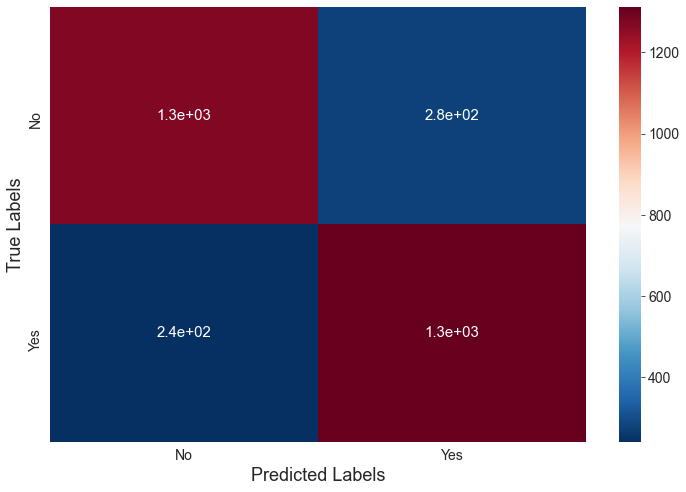



			Classification Report
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1552
           1       0.83      0.84      0.83      1553

    accuracy                           0.83      3105
   macro avg       0.83      0.83      0.83      3105
weighted avg       0.83      0.83      0.83      3105



In [96]:
# Support Vector Machines with Over-sampled data

svm_metric_sm = evaluate_model(X_sm_train,y_sm_train,svm,'Support Vector Machines',X_test=X_sm_test,y_test=y_sm_test)

In [97]:
all_metric_sm.append(svm_metric_sm)

Best Parameters are: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7}
Training Score: 0.7466531440162272
Cross V Score:  0.7190669371196754  +/- 0.0158682411485663
Testing Score: 0.7061050638902036
Cross & Test Diff: 0.012961873229471843

 				Confusion Matrix 
				-----------------


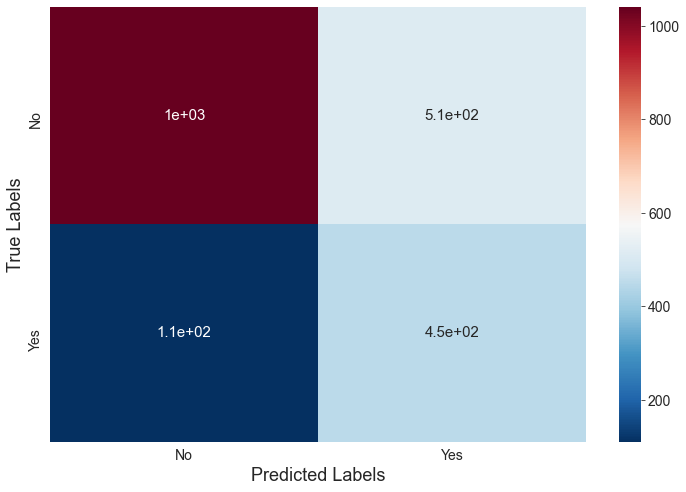



			Classification Report
               precision    recall  f1-score   support

           0       0.90      0.67      0.77      1552
           1       0.47      0.80      0.59       561

    accuracy                           0.71      2113
   macro avg       0.69      0.74      0.68      2113
weighted avg       0.79      0.71      0.72      2113



In [98]:
# Decision Tree classifier with Normal Data

dtree_metric = evaluate_model(X_train,y_train,dtree,'Decision Tree')

In [99]:
all_metric.append(dtree_metric)

Best Parameters are: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 11}
Training Score: 0.8659395278199641
Cross V Score:  0.7856452726017944  +/- 0.004930454409797586
Testing Score: 0.7780998389694042
Cross & Test Diff: 0.0075454336323902416

 				Confusion Matrix 
				-----------------


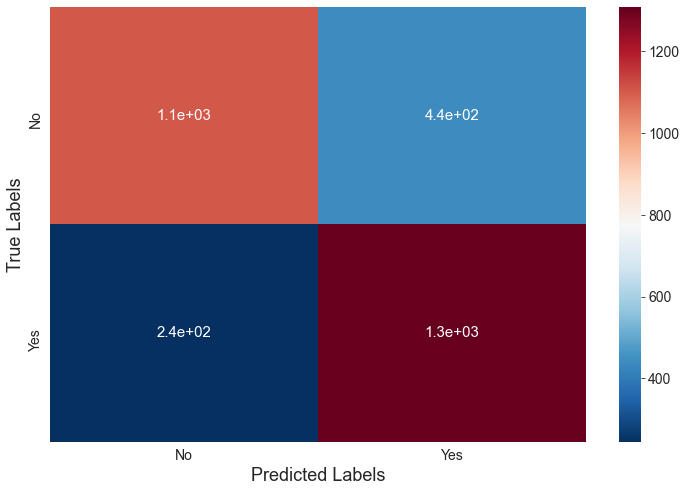



			Classification Report
               precision    recall  f1-score   support

           0       0.82      0.71      0.76      1552
           1       0.75      0.84      0.79      1553

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105



In [100]:
# Decision Tree Classifier with Over-sampled data

dtree_metric_sm = evaluate_model(X_sm_train,y_sm_train,dtree,'Decision Tree',X_test=X_sm_test,y_test=y_sm_test)

In [101]:
all_metric_sm.append(dtree_metric_sm)

Best Parameters are: {'max_samples': 0.8, 'n_estimators': 50, 'random_state': 108}
Training Score: 0.957606490872211
Cross V Score:  0.7657200811359026  +/- 0.012618524150098023
Testing Score: 0.7681022243256034
Cross & Test Diff: -0.0023821431897007583

 				Confusion Matrix 
				-----------------


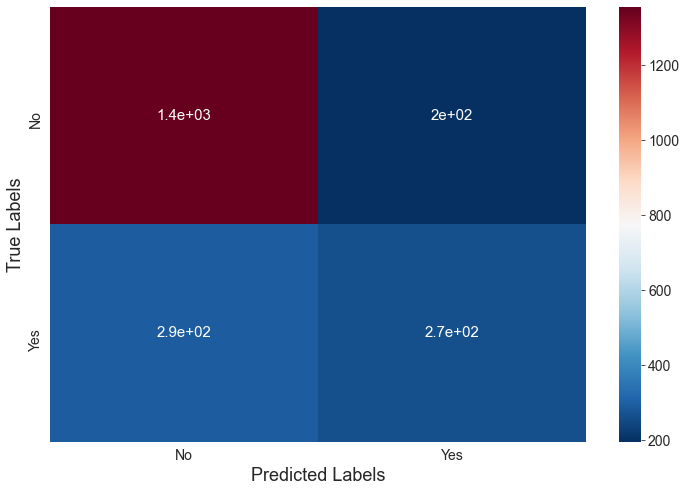



			Classification Report
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      1552
           1       0.58      0.48      0.52       561

    accuracy                           0.77      2113
   macro avg       0.70      0.67      0.68      2113
weighted avg       0.76      0.77      0.76      2113



In [102]:
# Bagging Classfier with normal data

bag_metric = evaluate_model(X_train,y_train,bag,"Bagging Classifier")

In [103]:
all_metric.append(bag_metric)

Best Parameters are: {'max_samples': 0.8, 'n_estimators': 50, 'random_state': 108}
Training Score: 0.9512632886925307
Cross V Score:  0.8129744651483781  +/- 0.0063100783716563
Testing Score: 0.8215780998389695
Cross & Test Diff: -0.008603634690591333

 				Confusion Matrix 
				-----------------


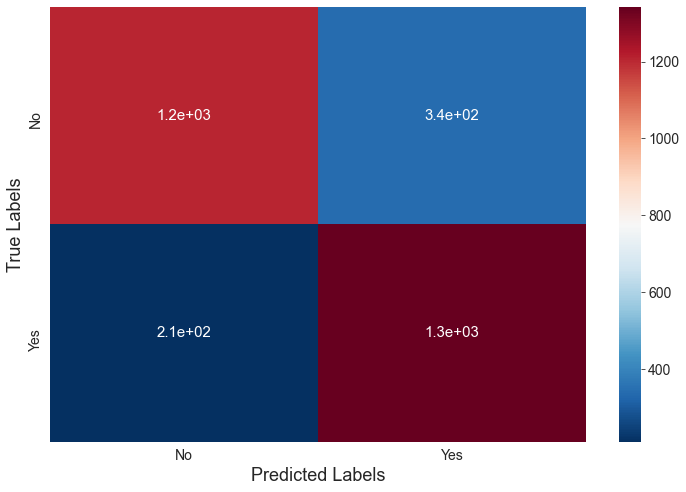



			Classification Report
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1552
           1       0.80      0.86      0.83      1553

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.82      3105
weighted avg       0.82      0.82      0.82      3105



In [104]:
# Bagging Classifier with Over-sampled data

bag_metric_sm = evaluate_model(X_sm_train,y_sm_train,bag,"Bagging Classifier",X_test=X_sm_test,y_test=y_sm_test)

In [105]:
all_metric_sm.append(bag_metric_sm)

Best Parameters are: {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 200, 'random_state': 108}
Training Score: 0.8691683569979716
Cross V Score:  0.762474645030426  +/- 0.005457859653985251
Testing Score: 0.77520113582584
Cross & Test Diff: -0.012726490795414103

 				Confusion Matrix 
				-----------------


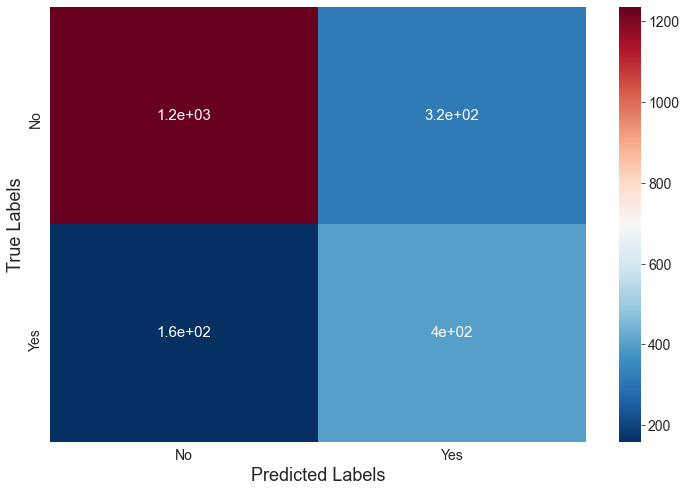



			Classification Report
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      1552
           1       0.56      0.72      0.63       561

    accuracy                           0.78      2113
   macro avg       0.72      0.76      0.73      2113
weighted avg       0.80      0.78      0.78      2113



In [106]:
# Random Forest Classifier with normal data

rforest_metric = evaluate_model(X_train,y_train,rforest,"Random Forest")

In [107]:
all_metric.append(rforest_metric)

Best Parameters are: {'class_weight': 'balanced', 'max_depth': 11, 'n_estimators': 300, 'random_state': 108}
Training Score: 0.8809885406599476
Cross V Score:  0.8168391994478951  +/- 0.006025915791012566
Testing Score: 0.8154589371980676
Cross & Test Diff: 0.0013802622498274575

 				Confusion Matrix 
				-----------------


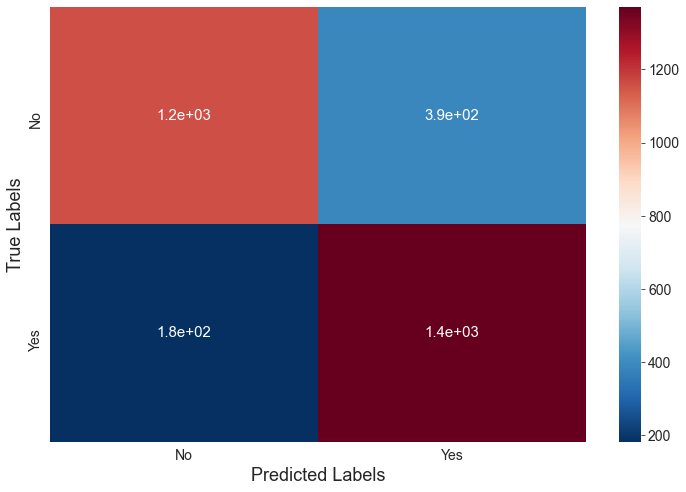



			Classification Report
               precision    recall  f1-score   support

           0       0.86      0.75      0.80      1552
           1       0.78      0.88      0.83      1553

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.81      3105
weighted avg       0.82      0.82      0.81      3105



In [108]:
# Random Forest Classifier with Over-sampled data

rforest_metric_sm = evaluate_model(X_sm_train,y_sm_train,rforest,"Random Forest",X_test=X_sm_test,y_test=y_sm_test)

In [109]:
all_metric_sm.append(rforest_metric_sm)

Best Parameters are: {'learning_rate': 0.05, 'n_estimators': 200, 'random_state': 108}
Training Score: 0.8109533468559837
Cross V Score:  0.7935091277890466  +/- 0.0032454361054766955
Testing Score: 0.8031235210601041
Cross & Test Diff: -0.009614393271057509

 				Confusion Matrix 
				-----------------


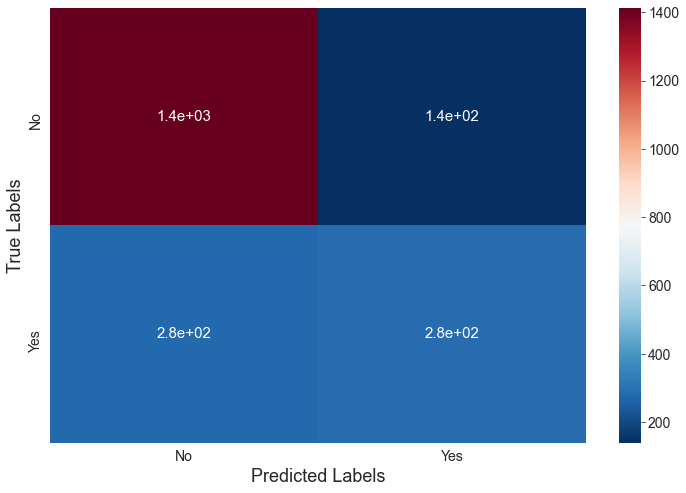



			Classification Report
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.67      0.51      0.58       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



In [110]:
# Gradient Boosting Classifier with Normal data

grad_boost_metric = evaluate_model(X_train,y_train,grad_boost,"Gradient Boosting Classifier")

In [111]:
all_metric.append(grad_boost_metric)

Best Parameters are: {'learning_rate': 0.2, 'n_estimators': 200, 'random_state': 108}
Training Score: 0.8232776473836808
Cross V Score:  0.7917184265010353  +/- 0.004218276546566219
Testing Score: 0.8028985507246377
Cross & Test Diff: -0.011180124223602372

 				Confusion Matrix 
				-----------------


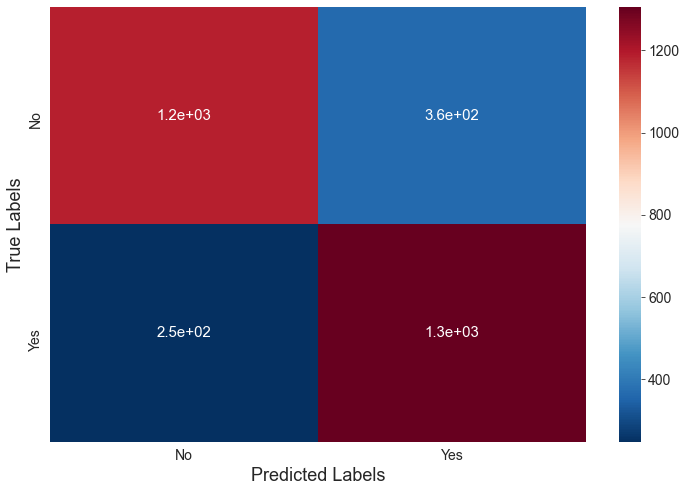



			Classification Report
               precision    recall  f1-score   support

           0       0.83      0.76      0.80      1552
           1       0.78      0.84      0.81      1553

    accuracy                           0.80      3105
   macro avg       0.80      0.80      0.80      3105
weighted avg       0.80      0.80      0.80      3105



In [112]:
# Gradient Boosting classifier with over-sampled data

grad_boost_metric_sm = evaluate_model(X_sm_train,y_sm_train,grad_boost,"Gradient Boosting Classifier",X_test=X_sm_test,
                                     y_test=y_sm_test)

In [113]:
all_metric_sm.append(grad_boost_metric_sm)

Best Parameters are: {'eta': 0.05, 'eval_metric': 'logloss', 'max_depth': 20, 'num_class': 2, 'objective': 'multi:softmax', 'random_state': 108}
Training Score: 0.9549695740365112
Cross V Score:  0.7563894523326572  +/- 0.008567428836487975
Testing Score: 0.759110269758637
Cross & Test Diff: -0.002720817425979849

 				Confusion Matrix 
				-----------------


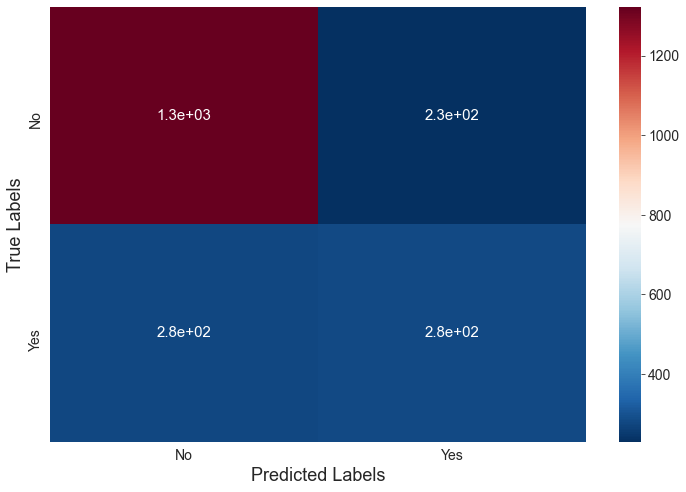



			Classification Report
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1552
           1       0.55      0.50      0.53       561

    accuracy                           0.76      2113
   macro avg       0.69      0.68      0.68      2113
weighted avg       0.75      0.76      0.76      2113



In [114]:
# XGBoost classifier with normal data

xg_boost_metric = evaluate_model(X_train,y_train,xg_boost,'XGBoost')

In [115]:
all_metric.append(xg_boost_metric)

Best Parameters are: {'eta': 0.05, 'eval_metric': 'logloss', 'max_depth': 13, 'num_class': 2, 'objective': 'multi:softmax', 'random_state': 108}
Training Score: 0.9411845920198812
Cross V Score:  0.8117322291235336  +/- 0.006435634631814899
Testing Score: 0.8222222222222222
Cross & Test Diff: -0.010489993098688588

 				Confusion Matrix 
				-----------------


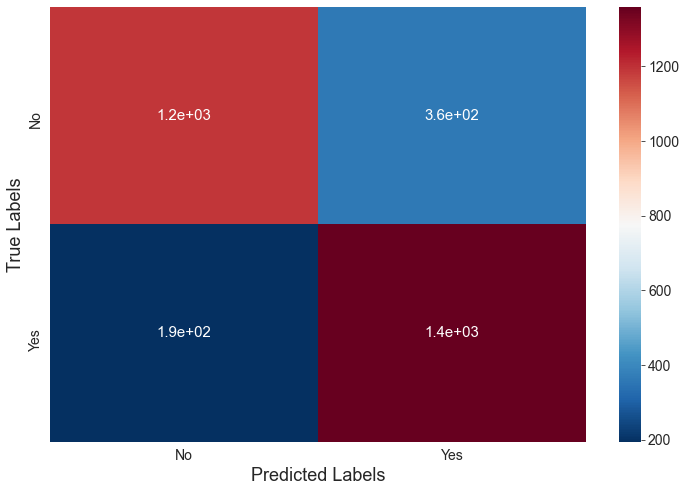



			Classification Report
               precision    recall  f1-score   support

           0       0.86      0.77      0.81      1552
           1       0.79      0.88      0.83      1553

    accuracy                           0.82      3105
   macro avg       0.83      0.82      0.82      3105
weighted avg       0.83      0.82      0.82      3105



In [116]:
# XGBoost classifier with Over-sampled data

xg_boost_metric_sm = evaluate_model(X_sm_train,y_sm_train,xg_boost,'XGBoost',X_test=X_sm_test,y_test=y_sm_test)

In [117]:
all_metric_sm.append(xg_boost_metric_sm)

Now let's put all the metrics into a dataframe and compare all the models together

In [124]:
# Metrics of normal data

met = pd.DataFrame(all_metric)
met.head()

Model_name  Training_score  Cross_val_score  Testing_score  \
0      Logistic Regression        0.756592         0.752130       0.754851   
1              Naive Bayes        0.753550         0.744828       0.752011   
2      K Nearest Neighbors        0.961460         0.777282       0.785613   
3  Support Vector Machines        0.841582         0.786207       0.784193   
4            Decision Tree        0.746653         0.719067       0.706105   

   Recall_score  Precision_score  F1_score  
0      0.800357         0.525146  0.634181  
1      0.793226         0.521688  0.629420  
2      0.520499         0.613445  0.563163  
3      0.536542         0.605634  0.568998  
4      0.803922         0.468815  0.592252

In [125]:
# Metrics of Over-sampled data

met_sm = pd.DataFrame(all_metric_sm)
met_sm

Model_name  Training_score  Cross_val_score  \
0           Logistic Regression        0.787243         0.784679   
1                   Naive Bayes        0.775784         0.777364   
2           K Nearest Neighbors        0.950573         0.786473   
3       Support Vector Machines        0.953472         0.827467   
4                 Decision Tree        0.865940         0.785645   
5            Bagging Classifier        0.951263         0.812974   
6                 Random Forest        0.880989         0.816839   
7  Gradient Boosting Classifier        0.823278         0.791718   
8                       XGBoost        0.941185         0.811732   

   Testing_score  Recall_score  Precision_score  F1_score  
0       0.790660      0.823567         0.772810  0.797382  
1       0.781643      0.815840         0.763713  0.788917  
2       0.793881      0.885383         0.748503  0.811209  
3       0.832850      0.844816         0.825157  0.834871  
4       0.778100      0.842241         0.746575  0.791528  
5       0.821578      0.864134         0.796439  0.828907  
6       0.815459      0.882807         0.778093  0.827149  
7       0.802899      0.840953         0.781568  0.810174  
8       0.822222      0.875080         0.791497  0.831193

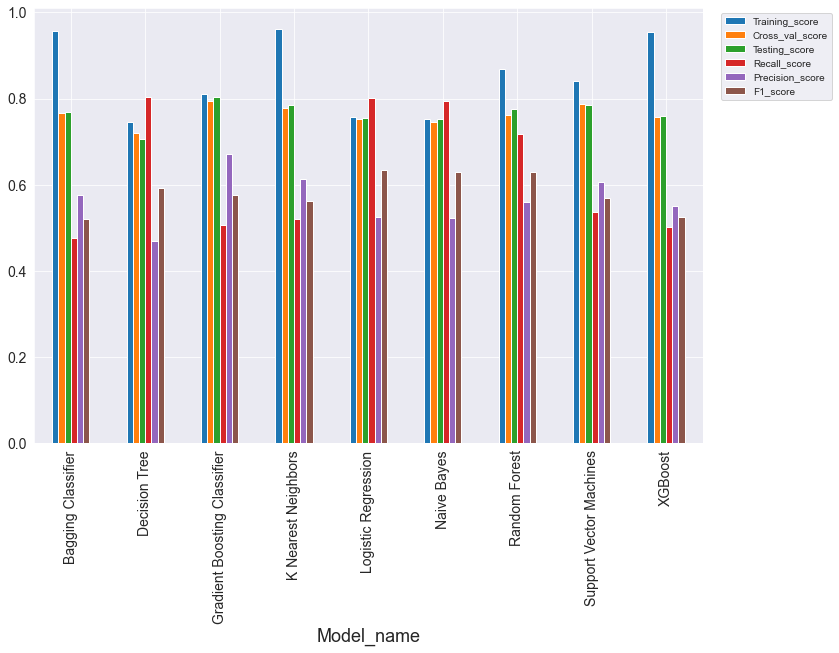

In [137]:
# Comparing evaluation metrics of normal data
met.groupby('Model_name').mean().plot(kind='bar',rot=90)
plt.legend(bbox_to_anchor=[1.2,1])

<b>As we can see that even though the test accuracies of all the models on the normal data coming out to be more or less the same, since it is an imbalanced dataset, F!-score would be a more appropriate measure than accuracy, in my opinion. F1-score of all the models is quite low, since either recall or precision score of all the models is low. F1-score being the harmonic mean of Recall and Precision shows the overall performance. <br>
Hence, I have used over-sampling technique called SMOTE, to improve my model.

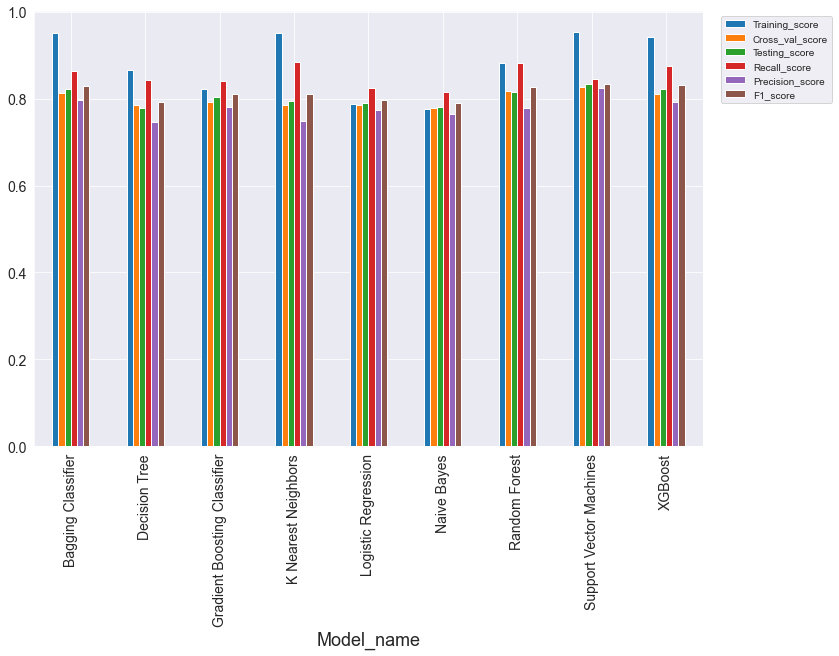

In [138]:
# Comparing evaluation metrics of over-sampled data

met_sm.groupby('Model_name').mean().plot(kind='bar',rot=90)
plt.legend(bbox_to_anchor=[1.2,1])

<b>After over-sampling, the F1-score of our models improved drastically, with the best one being 83% of XGBoost among the emsemble techniques. Hence, I am going to use this model for our prediction in GUI.<br>

Let me again make the model with the best parameters achieved and then I will pass it in the GUI.

In [20]:
global xg_boost_final

In [21]:
xg_boost_final = xgb.XGBClassifier(eta= 0.05, eval_metric= 'logloss', max_depth= 13, num_class= 2, 
                                   objective= 'multi:softmax', random_state= 108)

In [22]:
xg_boost_final.fit(X_sm_train,y_sm_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=0, max_depth=13, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_class=2, num_parallel_tree=1, objective='multi:softmax',
              random_state=108, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [23]:
y_pred = xg_boost_final.predict(X_sm_test)

In [32]:
import pickle

In [33]:
xgb_final = pickle.dumps(xg_boost_final) 

<b>Here, I have pickled the file and we can use this pickled file anywhere we want. But in this project, I am not going to load that file in the gui, since we are making the gui in the same ipynb file. But if someone wants to use it somewhere else, we can provide this pickled file to them to use it as per their needs.

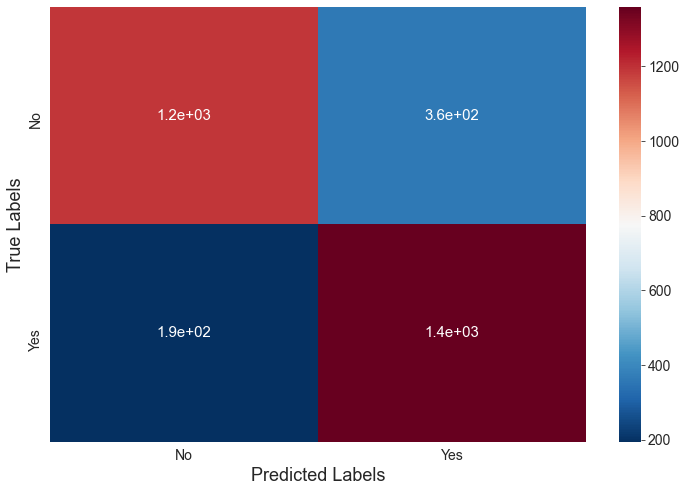

In [145]:
cm = confusion_matrix(y_sm_test,y_pred)
cm_df = pd.DataFrame(cm,index=['No','Yes'],columns=['No','Yes'])
p = sns.heatmap(cm_df,annot=True,cmap='RdBu_r',annot_kws={'size':15})
_ = p.set(xlabel='Predicted Labels',ylabel='True Labels',xticklabels=['No','Yes'],
          yticklabels=['No','Yes'])
plt.show()

<b>The Model has around 1200 True Negatives and 1400 True positives. Consecutively, the model also has 190 False negatives and 360 False Positives from our test data. We can say that our model is a decent one.

In [146]:
print(classification_report(y_sm_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1552
           1       0.79      0.88      0.83      1553

    accuracy                           0.82      3105
   macro avg       0.83      0.82      0.82      3105
weighted avg       0.83      0.82      0.82      3105



<b>Let's analyze the classification report of this logistic regression model in more detail:</b>


* <b>Precision</b>: This can be defined as the ratio of <b>True Positives to the Total Number of Predicted Positives</b>, i.e., 

$$ Precision = \frac {True Positives} {True Positives + False Positives} $$


* <b>Recall(or Sensitivity)</b>: It is defined as the ratio of <b>True Positives to the Actual Number of Positives</b>, i.e.,

$$ Recall = \frac {True Positives} {True Positives + False Negatives} $$


* <b>F1-Score</b>: It is defined as the harmonic mean of Precision and Recall, i.e.,:

$$ F1 Score = \frac {2 * Precision * Recall} {Precision + Recall} $$ 

* Support column tells us how many observations were present of each class in our test set on which this model has performed the prediction and gave us this result. 

Precision and Recall, together give us the idea, how our model is performing overall and whether the motive which we are trying to achieve has been achieved or not. F1-Score simply sums up what Precision and Recall are conveying individually. These parameters are more important in this data-set than the accuracy scores.

Then comes our <b>Accuracy</b> parameter in our classification report, which we have already seen before we even built our confusion matrix. Let's now first understand what is accuracy:

* <b>Accuracy</b>: It is defined as the ratio of the True Predictions to the overall predictions by the models, i.e,:

$$ Accuracy = \frac {True Positives + True Negatives} {True Positives + True Negatives + False Positives + False Negatives}$$

Here, we can see that there are two averages, which are also accuracies:
* Macro Average: This is the uniform average/accuracy without taking into consideration the weights of each class in predictions.

* Weighted Average : This is the weighted average/accuracy where we have taken into consideration the weights of each class in predictions. 



<b>So after over-sampling, the F1-score of the model has improved as we can see that for both 0 and 1, it is around 83%, which is a decent score. Even accuracy is also coming out to be around 83%, which means we can say that our model is a decent one.

## GUI

In [31]:
# Creating instance of tkinter gui windows.
root = Tk()
root.title("Emsemble Technique Project: Churn-GUI")
root.geometry("1000x800")

# Function for checking whether a entered number is numeric or not
def test_val_int(inStr,acttyp):
    if acttyp == '1': #insert
        if not inStr.isdigit():
            messagebox.showwarning(title='Warning',message='Entered Number is not valid. Please enter again')
            return False
    return True

# Function for checking whether a number entered a flaot or not
def check_float(f):
    try:
        f = float(f)
        return True
    except:
        return False
    
# If the number is not float then show a warning
def test_val_float(inStr,acttyp):
    if acttyp == '1': #insert
        if not check_float(inStr):
            messagebox.showwarning(title='Warning',message='Entered Number is not valid. Please enter again')
            return False
        
    return True

# Creating first frame for labels
frame1 = LabelFrame(root,text='Features',padx=30,pady=50,bg='light blue',borderwidth=5)
frame1.grid(row=0,column=0,sticky=NW)

# Creating 2nd frame for entering values
frame2 = LabelFrame(root,text='Enter Values',padx=30,pady=50,bg='light blue',borderwidth=5)
frame2.grid(row=0,column=1,sticky=NW)

# Label and Radio-buttons for Gender feature
gender_label = Label(frame1,text='Gender:',bg='light blue',padx=5,pady=6,font = ('calibri', 10, 'bold'))
gender_label.grid(row=0,column=0,sticky=NW)
gender_var = IntVar()
gender_var.set(' ')
male = Radiobutton(frame2,text='Male',variable=gender_var,value=1,bg='light blue',padx=5,pady=5)
female = Radiobutton(frame2,text='Female',variable=gender_var,value=0,bg='light blue',padx=5,pady=5)
male.grid(row=0,column=1,sticky=NW)
female.grid(row=0,column=2,sticky=NW)

yesno = [('Yes',1),('No',0)]

# Label and Radio-buttons for SeniorCitizen feature
sc_label = Label(frame1,text='Senior Citizen:',bg='light blue',padx=5,pady=6,font = ('calibri', 10, 'bold'))
sc_label.grid(row=1,column=0,sticky=NW)
sc_var = IntVar()
sc_var.set(' ')
m=1
for i,j in yesno:
    sc = Radiobutton(frame2,text=i,variable=sc_var,value=j,bg='light blue',padx=5,pady=5)
    sc.grid(row=1,column=m,sticky=NW)
    m+=1
    
# Label and Radio-buttons for Partner feature
part_label = Label(frame1,text='Partners:',bg='light blue',padx=5,pady=7,font = ('calibri', 10, 'bold'))
part_label.grid(row=2,column=0,sticky=NW)
part_var = IntVar()
part_var.set(' ')
m=1
for i,j in yesno:
    part = Radiobutton(frame2,text=i,variable=part_var,value=j,bg='light blue',padx=5,pady=5)
    part.grid(row=2,column=m,sticky=NW)
    m+=1

# Label and Radio-buttons for Dependents feature
dep_label = Label(frame1,text='Dependents:',bg='light blue',padx=5,pady=7,font = ('calibri', 10, 'bold'))
dep_label.grid(row=3,column=0,sticky=NW)
dep_var = IntVar()
dep_var.set(' ')
m=1
for i,j in yesno:
    dep = Radiobutton(frame2,text=i,variable=dep_var,value=j,bg='light blue',padx=5,pady=5)
    dep.grid(row=3,column=m,sticky=NW)
    m+=1

# Label and Entry box for Tenure feature
ten_label = Label(frame1,text='Tenure:',bg='light blue',padx=5,pady=5,font = ('calibri', 10, 'bold'))
ten_label.grid(row=4,column=0,sticky=NW)
ten_box = Entry(frame2,width=20,bd=3,validate='key')
ten_box['validatecommand'] = (ten_box.register(test_val_int),'%P','%d')
ten_box.insert(0,0)
ten_box.grid(row=4,column=1,sticky=NW)
Label(frame2,text="(Only interger values are accepted)",bg='light blue').grid(row=4,column=2,sticky=NE)

# Function for disabling the following feature, if PhoneService is not activated for a customer 
def check_no(j,var1,var2):
    if j == 0:
        ml_var.set(0)
        var1.configure(state='disabled')
        var2.configure(state='disabled')
    else:
        ml_var.set(0)
        var1.configure(state='normal')
        var2.configure(state='normal')

# Label and Radio-buttons for PhoneService feature
ps_label = Label(frame1,text='Phone Service:',bg='light blue',padx=5,pady=5,font = ('calibri', 10, 'bold'))
ps_label.grid(row=5,column=0,sticky=NW)
ps_var = IntVar()
ps_var.set(' ')
m=1
for i,j in yesno:
    ps = Radiobutton(frame2,text=i,variable=ps_var,value=j,bg='light blue',padx=5,pady=5,
                    command=lambda: check_no(ps_var.get(),ml_yes,ml_no))
    ps.grid(row=5,column=m,sticky=NW)
    m+=1

# Label and Radio-buttons for MultipleLines feature
ml_label = Label(frame1,text='Multiple Lines:',bg='light blue',padx=5,pady=5,font = ('calibri', 10, 'bold'))
ml_label.grid(row=6,column=0,sticky=NW)
ml_var = IntVar()
ml_var.set(' ')

ml_yes = Radiobutton(frame2,text='Yes',variable=ml_var,value=1,bg='light blue',padx=5,pady=5)
ml_yes.grid(row=6,column=1,sticky=NW)
ml_no = Radiobutton(frame2,text='No',variable=ml_var,value=0,bg='light blue',padx=5,pady=5)
ml_no.grid(row=6,column=2,sticky=NW)


# All the following functions are for disabling all the Internet related services buttons, if a customer has not -
# - opted for InternetService
def feature_no(j,btn,var):
    if j == 'No':
        var.set(0)
        btn[0].configure(state='disabled')
        btn[1].configure(state='disabled')
    else:
        var.set(" ")
        btn[0].configure(state='normal')
        btn[1].configure(state='normal')
def internet_no(event):
    current = is_var.get()
    inter_btn = [(onlsec_yes,onlsec_no),
                  (onlbac_yes,onlbac_no),
                  (devpro_yes,devpro_no),
                 (techsup_yes,techsup_no),
                 (strtv_yes,strtv_no),
                 (strmov_yes,strmov_no)]
    inter_vars = [onlsec_var,onlbac_var,devpro_var,techsup_var,strtv_var,strmov_var]
    
    for v in range(len(inter_vars)):
        feature_no(current,inter_btn[v],inter_vars[v])
        
def inter_no(event):
    cur = is_var.get()
    if cur == 'No':
        return False
    else:
        return True

# Label and Drop-down menu for InternetService feature
is_label = Label(frame1,text='Internet Service:',bg='light blue',padx=5,pady=3,font = ('calibri', 10, 'bold'))
is_label.grid(row=7,column=0,sticky=NW)
is_var = StringVar()
is_combo = ttk.Combobox(frame2,width=20,textvariable=is_var,state='readonly')
is_combo.bind("<<ComboboxSelected>>",internet_no)
is_combo['values'] = ['No','DSL','Fibre optic']
is_combo.current()
is_combo.grid(row=7,column=1,sticky=NW)
    
# Label and Radio-buttons for OnlineSecurity feature
onlsec_label = Label(frame1,text='Online Security:',bg='light blue',padx=5,pady=7,font = ('calibri', 10, 'bold'))
onlsec_label.grid(row=8,column=0,sticky=NW)
onlsec_var = IntVar()
onlsec_var.set(' ')
onlsec_yes = Radiobutton(frame2,text='Yes',variable=onlsec_var,value=1,bg='light blue',padx=5,pady=5)
onlsec_yes.grid(row=8,column=1,sticky=NW)
onlsec_no = Radiobutton(frame2,text='No',variable=onlsec_var,value=0,bg='light blue',padx=5,pady=5)
onlsec_no.grid(row=8,column=2,sticky=NW)

# Label and Radio-buttons for OnileBackup feature
onlbac_label = Label(frame1,text='Online Backup:',bg='light blue',padx=5,pady=7,font = ('calibri', 10, 'bold'))
onlbac_label.grid(row=9,column=0,sticky=NW)
onlbac_var = IntVar()
onlbac_var.set(' ')
onlbac_yes = Radiobutton(frame2,text='Yes',variable=onlbac_var,value=1,bg='light blue',padx=5,pady=5)
onlbac_yes.grid(row=9,column=1,sticky=NW)
onlbac_no = Radiobutton(frame2,text='No',variable=onlbac_var,value=0,bg='light blue',padx=5,pady=5)
onlbac_no.grid(row=9,column=2,sticky=NW)

# Label and Radio-buttons for DeviceProtection feature
devpro_label = Label(frame1,text='Device Protection:',bg='light blue',padx=5,pady=7,font = ('calibri', 10, 'bold'))
devpro_label.grid(row=10,column=0,sticky=NW)
devpro_var = IntVar()
devpro_var.set(' ')
devpro_yes = Radiobutton(frame2,text='Yes',variable=devpro_var,value=1,bg='light blue',padx=5,pady=5)
devpro_yes.grid(row=10,column=1,sticky=NW)
devpro_no = Radiobutton(frame2,text='No',variable=devpro_var,value=0,bg='light blue',padx=5,pady=5)
devpro_no.grid(row=10,column=2,sticky=NW)

# Label and Radio-buttons for TechSupport feature    
techsup_label = Label(frame1,text='Tech Support:',bg='light blue',padx=5,pady=7,font = ('calibri', 10, 'bold'))
techsup_label.grid(row=11,column=0,sticky=NW)
techsup_var = IntVar()
techsup_var.set(' ')
techsup_yes = Radiobutton(frame2,text='Yes',variable=techsup_var,value=1,bg='light blue',padx=5,pady=5)
techsup_yes.grid(row=11,column=1,sticky=NW)
techsup_no = Radiobutton(frame2,text='No',variable=techsup_var,value=0,bg='light blue',padx=5,pady=5)
techsup_no.grid(row=11,column=2,sticky=NW)

# Label and Radio-buttons for StreaningTV feature    
strtv_label = Label(frame1,text='Streaming TV:',bg='light blue',padx=5,pady=7,font = ('calibri', 10, 'bold'))
strtv_label.grid(row=12,column=0,sticky=NW)
strtv_var = IntVar()
strtv_var.set(' ')
strtv_yes = Radiobutton(frame2,text='Yes',variable=strtv_var,value=1,bg='light blue',padx=5,pady=5)
strtv_yes.grid(row=12,column=1,sticky=NW)
strtv_no = Radiobutton(frame2,text='No',variable=strtv_var,value=0,bg='light blue',padx=5,pady=5)
strtv_no.grid(row=12,column=2,sticky=NW)

# Label and Radio-buttons for StreamingMovbies feature    
strmov_label = Label(frame1,text='Streaming Movies:',bg='light blue',padx=5,pady=4,font = ('calibri', 10, 'bold'))
strmov_label.grid(row=13,column=0,sticky=NW)
strmov_var = IntVar()
strmov_var.set(' ')
strmov_yes = Radiobutton(frame2,text='Yes',variable=strmov_var,value=1,bg='light blue',padx=5,pady=5)
strmov_yes.grid(row=13,column=1,sticky=NW)
strmov_no = Radiobutton(frame2,text='No',variable=strmov_var,value=0,bg='light blue',padx=5,pady=5)
strmov_no.grid(row=13,column=2,sticky=NW)

# Label and Drop-down menu for Contract feature
con_label = Label(frame1,text='Contract:',bg='light blue',padx=5,pady=6,font = ('calibri', 10, 'bold'))
con_label.grid(row=14,column=0,sticky=NW)
con_var = StringVar()
con_combo = ttk.Combobox(frame2,width=20,textvariable=con_var,state='readonly')
con_combo['values'] = ['Month-to-month','One year','Two year']
con_combo.current()
con_combo.grid(row=14,column=1,sticky=NW)

# Label and Radio-buttons for PaperlessBilling feature
pprbl_label = Label(frame1,text='Paperless Billing:',bg='light blue',padx=5,pady=3,font = ('calibri', 10, 'bold'))
pprbl_label.grid(row=15,column=0,sticky=NW)
pprbl_var = IntVar()
pprbl_var.set(' ')
m=1
for i,j in yesno:
    pprbl = Radiobutton(frame2,text=i,variable=pprbl_var,value=j,bg='light blue',padx=5,pady=5)
    pprbl.grid(row=15,column=m,sticky=NW)
    m+=1
    
# Label and Dropdown menu for PaymentMethod feature
pay_label = Label(frame1,text='Payment Method:',bg='light blue',padx=5,pady=2,font = ('calibri', 10, 'bold'))
pay_label.grid(row=16,column=0,sticky=NW)
pay_var = StringVar()
pay_combo = ttk.Combobox(frame2,width=20,textvariable=pay_var,height=5,state='readonly')
pay_combo['values'] = ['Electronic check','Mailed check','Bank transfer (automatic)','Credit card (automatic)']
pay_combo.current()
pay_combo.grid(row=16,column=1,sticky=NW)

# Label and Entry-box for MonthlyCharges feature
mon_label = Label(frame1,text='Monthly Charges:',bg='light blue',padx=5,pady=3,font = ('calibri', 10, 'bold'))
mon_label.grid(row=17,column=0,sticky=NW)
mon_box = Entry(frame2,width=20,bd=3,validate='key')#,validatecommand=lambda: validate_entry("%P"))
mon_box['validatecommand'] = (mon_box.register(test_val_float),'%P','%d')
mon_box.insert(0,0.0)
mon_box.grid(row=17,column=1,sticky=NW)
Label(frame2,text="(Decimal values are accepted)",bg='light blue').grid(row=17,column=2,sticky=NE)

# Label and Entry-box for TotalCharges feature
tot_label = Label(frame1,text='Total Charges:',bg='light blue',padx=5,pady=2,font = ('calibri', 10, 'bold'))
tot_label.grid(row=18,column=0,sticky=NW)
tot_box = Entry(frame2,width=20,bd=3,validate='key')
tot_box['validatecommand'] = (tot_box.register(test_val_float),'%P','%d')
tot_box.insert(0,0.0)
tot_box.grid(row=18,column=1,sticky=NW)
Label(frame2,text="(Decimal values are accepted)",bg='light blue').grid(row=18,column=2,sticky=NE)

# Function for submit button
def submit():
    global all_values
    global print_values, keys, values
    
    all_values = {'gender':gender_var.get(), 
                  'SeniorCitizen':sc_var.get() , 
                  'Partner':part_var.get() , 
                  'Dependents':dep_var.get() ,
                    'tenure':ten_box.get() , 
                  'PhoneService':ps_var.get() , 
                  'MultipleLines':ml_var.get() , 
                  'InternetService':is_var.get() ,
                   'OnlineSecurity':onlsec_var.get() , 
                  'OnlineBackup':onlbac_var.get() , 
                  'DeviceProtection':devpro_var.get() , 
                  'TechSupport':techsup_var.get() ,
                   'StreamingTV':strtv_var.get() , 
                  'StreamingMovies':strmov_var.get() , 
                  'Contract':con_var.get() , 
                  'PaperlessBilling':pprbl_var.get() ,
                   'PaymentMethod':pay_var.get() , 
                  'MonthlyCharges':mon_box.get() , 
                  'TotalCharges':tot_box.get() }

    keys = list(all_values.keys())
    values = list(all_values.values())
    for i in range(len(keys)):
        if values[i] == 0:
            if keys[i] == 'gender':
                cur = f"{keys[i]} \t:  Female"
            else:
                cur = f"{keys[i]} \t:  No"
        elif values[i] == 1:
            if keys[i] == 'gender':
                cur = f"{keys[i]} \t:  Male"
            else:
                cur = f"{keys[i]} \t:  Yes"
        else:
            cur = f"{keys[i]} \t:  {values[i]}"   
        
        pnt_label = Label(frame3,text=cur,bg='light blue',padx=20,justify='left')
        pnt_label.grid(row=i+2,column=0,sticky=W)
    
    # Enable the Predict Button
    predict_btn.configure(state='normal')
    
# Function for Predict Button
def pred():
    global pred
    global pred_dict
    
    # Entrybox which will show whether a person will churn or not
    chur_enter = Entry(frame3,width=20,bd=3,font = ('calibri', 10, 'bold'))
    chur_enter.grid(row=1,column=2)
    
    # Entering all the values in a list,pred, as per the sequence of features in our model
    pred = []
    
    pred.append(int(sc_var.get()))
    
    if int(ten_box.get()) >= 0 and int(ten_box.get()) < 9: 
        pred.append(0)
    elif int(ten_box.get()) >= 9 and int(ten_box.get()) < 29: 
        pred.append(1)
    elif int(ten_box.get()) >= 29 and int(ten_box.get()) < 55: 
        pred.append(2)
    elif int(ten_box.get()) >= 55: 
        pred.append(3)
        
    if float(mon_box.get()) >= 0 and float(mon_box.get()) < 35.5: 
        pred.append(0)
    elif float(mon_box.get()) >= 35.5 and float(mon_box.get()) < 70.35: 
        pred.append(1)
    elif float(mon_box.get()) >= 70.35 and float(mon_box.get()) < 89.85: 
        pred.append(2)
    elif float(mon_box.get()) >= 89.85: 
        pred.append(3)
        
    if float(tot_box.get()) >= 0 and float(tot_box.get()) < 398.55: 
        pred.append(0)
    elif float(tot_box.get()) >= 398.55 and float(tot_box.get()) < 1394.55: 
        pred.append(1)
    elif float(tot_box.get()) >= 1394.55 and float(tot_box.get()) < 3786.6: 
        pred.append(2)
    elif float(tot_box.get()) >= 3786.6: 
        pred.append(3)

    pred.append(int(gender_var.get()))
    pred.append(int(part_var.get()))
    pred.append(int(dep_var.get()))
    pred.append(int(ps_var.get()))
    pred.append(int(ml_var.get()))
    
    if is_var.get() == 'No':
        pred.append(0)
        pred.append(1)
    elif is_var.get() == 'Fibre optic':
        pred.append(1)
        pred.append(0)
    elif is_var.get() == 'DSL':
        pred.append(0)
        pred.append(0)
        
    pred.append(int(onlsec_var.get()))
    pred.append(int(onlbac_var.get()))
    pred.append(int(devpro_var.get()))
    pred.append(int(techsup_var.get()))
    pred.append(int(strtv_var.get()))
    pred.append(int(strmov_var.get()))

    if con_var.get() == 'Month-to-month':
        pred.append(0)
        pred.append(0)
    elif con_var.get() == 'One year':
        pred.append(1)
        pred.append(0)
    elif con_var.get() == 'Two year':
        pred.append(0)
        pred.append(1)
    
    pred.append(int(pprbl_var.get()))
    
    if pay_var.get() == 'Credit card (automatic)':
        pred.append(1)
        pred.append(0)
        pred.append(0)
    elif pay_var.get() == 'Electronic check':
        pred.append(0)
        pred.append(1)
        pred.append(0)
    elif pay_var.get() == 'Mailed check':
        pred.append(0)
        pred.append(0)
        pred.append(1)
    elif pay_var.get() == 'Bank transfer (automatic)':
        pred.append(0)
        pred.append(0)
        pred.append(0)
    
    pred_dict = {'SeniorCitizen':[pred[0]], 
             'tenure':[pred[1]],
             'MonthlyCharges':[pred[2]],
             'TotalCharges':[pred[3]], 
               'gender_Male':[pred[4]],
             'Partner_Yes':[pred[5]], 
             'Dependents_Yes':[pred[6]], 
             'PhoneService_Yes':[pred[7]],
               'MultipleLines_Yes':[pred[8]],
             'InternetService_Fiber optic':[pred[9]],
               'InternetService_No':[pred[10]], 
             'OnlineSecurity_Yes':[pred[11]], 
             'OnlineBackup_Yes':[pred[12]],
               'DeviceProtection_Yes':[pred[13]], 
             'TechSupport_Yes':[pred[14]], 
             'StreamingTV_Yes':[pred[15]],
               'StreamingMovies_Yes':[pred[16]], 
             'Contract_One year':[pred[17]], 
             'Contract_Two year':[pred[18]],
               'PaperlessBilling_Yes':[pred[19]], 
             'PaymentMethod_Credit card (automatic)':[pred[20]],
           'PaymentMethod_Electronic check':[pred[21]], 
             'PaymentMethod_Mailed check':[pred[22]]
            }
    

    # Making a dataframe of the values and then predicting it from our model and displaying it
    pred = pd.DataFrame(pred_dict)
    for i in pred.columns:
        pred.loc[0,i] = pd.to_numeric(pred.loc[0,i])
    ch = xg_boost_final.predict(pred)
    if ch == 1:
        chur_enter.insert(1,"Will Churn")
    else:
        chur_enter.insert(1,"Will Not Churn")
    
    #Clear/resetting all the columns after prediction
    ten_box.delete(0,END)
    mon_box.delete(0,END)
    tot_box.delete(0,END)
    gender_var.set(" ")
    sc_var.set(" ")
    part_var.set(" ")
    dep_var.set(" ")
    ps_var.set(" ")
    ml_var.set(" ")
    is_combo.set(" ")
    onlsec_var.set(" ")
    onlbac_var.set(" ")
    devpro_var.set(" ")
    techsup_var.set(" ")
    strtv_var.set(" ")
    strmov_var.set(" ")
    con_combo.set(" ")
    pprbl_var.set(" ")
    pay_combo.set(" ")

# Frame3 for buttons and displaying the output
frame3 = LabelFrame(root,padx=50,pady=50,bg='light blue',borderwidth=5)
frame3.grid(row=0,column=3,sticky=NW)

submit_btn = Button(frame3,text='Submit',command=submit,padx=7,pady=5,font = ('calibri', 10, 'bold'),
                bg=None,fg="#6C3483",activebackground="#A569BD",borderwidth=2,anchor='center')
submit_btn.grid(row=0,column=0,sticky=NW)

predict_btn = Button(frame3,text='Predict',command=pred,padx=7,pady=5,anchor='center',font = ('calibri', 10, 'bold'),
                    bg=None,fg="#6C3483",activebackground="#A569BD",borderwidth=2,state='disabled')
predict_btn.grid(row=1,column=0,sticky=NW)


root.mainloop()

## Conclusion:

The problem statement was to find out which customers have high chances of churning from the telecom company based on the features provided.

I tried to predict it using most of the supervised and ensemble techniques and most of them were giving the similar results.  
<b>But overall, XG_Boost seems to have performed the best among all the ensemble techniques and Support Vector Machines performed the best among the supervised learning techniques. </b>

As I was doing the analysis of the data, I have also given the areas on which company must look into and highlighted the alarming points for the company to take actions on. 

The most prominent thing that I observed was that people using Fiber Optics Internet services of the company were the most of them who are churning. Interestingly, customers who opt for Fiber Optics services are also the ones who pay the company the most. This means that your company's Fiber optics services are too costly for the services provided by you compared to your competitors in the market or your services are not upto the marks to the extent that customers get disgusted and churn. This is one area that the company must look into on an urgent basis.

If the company is able to retain its Fiber optics customers, then it won't be much affected by churning as only low paying customers would be churning away. 

Company must also try to look into its pricing, and make them competitive in the market.

I hope the model that I have provided helps the company retain as many customers as possible and possibly help the company target the customers based on their customized needs. 

## Suggestions

<b>Quality</b>: Quality of the data seems pretty decent since except for just 11 missing values, rest were in place and with the almost right data-types for all. 

<b>Quantity</b>: Even though the quantity of the data was sufficient to build a good model, the data was imbalanced. But this is not the fault of the data-collection team since it is not in their hands. Plus, it is always beneficial to collect more and more data. So, my only suggestion would be to collect more and more data. 

<b>Variety</b>: We have just dealt with the structured tabular data in our model building process and used a supervised learning method which deals with only structured data. But as far as variety of the data is concerned, it is always helpful to collect more and more data in any form that we could. 

<b>Velocity</b>: Since we are not doing any real-time analysis. So it would be difficult to comment on the velocity of the data. But as far as the entire process is concerned, it is always beneficial to collect the data as fast as possible, so that we could come up with better strategies to target the customers in the current situation. Data would be of no use if it gets outdated and then it would be difficult to target customers today based on outdated data.

<b>Veracity</b>: Since the data has been provided by the company itself, hence the data is completely authentic. As far as noise and abnormalities in the data are concerned, the abnormalities that we saw in the data is not because of the inauthentic data but due to their own nature.